In [6]:
! pip install textstat

In [4]:
!pip install pandas numpy scikit-learn matplotlib seaborn textstat nltk transformers datasets peft accelerate torch evaluate
!pip install -U scikit-learn
import os
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import numpy as np

#Data Retrieval
from Retrieve_data_from_hugging_face import ds
print("Data downloaded successfully")
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("processed_data", exist_ok=True)
for split in ds.keys():
    file_path = os.path.join("data", f"data_merged_original_yuke.csv")
    ds[split].to_csv(file_path, index=False)
    print(f"Saved {split} split to {file_path}")

#import from data_preprocessing.py
from data_preprocessing import (
    split_raw_data_to_csv_dis_lora,
    preprocess_data_sgd,
    preprocess_data_nb,
    extract_linguistic_features_sgd,
    extract_linguistic_features_nb
)

#import from error_analysis.py
from error_analysis import run_error_analysis

# Split data
split_raw_data_to_csv_dis_lora()
print("Data split into train/val/test sets")
train_path = "./data/text_train.csv"
val_path = "./data/text_validation.csv"
test_path = "./data/text_test.csv"

#models
from sklearn.utils.class_weight import compute_class_weight

def train_sgd(X_train, y_train, use_linguistic_features=False):
    """Train optimized SGD model with fixed learning rate"""
    print("\nTraining SGD model...")
    start_time = time.time()

    model = SGDClassifier(
        loss='log_loss',
        penalty='elasticnet',
        alpha=1e-4,
        l1_ratio=0.15,
        max_iter=1000,
        random_state=42,
        learning_rate='optimal',
        eta0=0.01,
        early_stopping=False,
        class_weight='balanced',
        tol=1e-4
    )

    model.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    model_type = "with_features" if use_linguistic_features else "no_features"
    os.makedirs(f"models/sgd_{model_type}", exist_ok=True)
    joblib.dump(model, f"models/sgd_{model_type}/model.joblib")
    return model

def evaluate_model_sgd(model, X, y, set_name="Dataset", use_features=False):
    """Evaluation with metrics and confusion matrix"""
    pred = model.predict(X)
    proba = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    roc_auc = roc_auc_score(y, proba)
    cm = confusion_matrix(y, pred)

    print(f"\n{set_name} Set Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Human', 'AI'],
                yticklabels=['Human', 'AI'])
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

class NaiveBayesWithFeatures:
    """Custom Naive Bayes that combines text and linguistic features"""
    def __init__(self):
        self.text_nb = MultinomialNB()
        self.features_nb = GaussianNB()
        self.feature_weights = [0.7, 0.3]

    def fit(self, X, y):
        text_features, ling_features = X
        self.text_nb.fit(text_features, y)
        self.features_nb.fit(ling_features, y)
        return self

    def predict_proba(self, X):
        text_features, ling_features = X
        text_proba = self.text_nb.predict_proba(text_features)
        ling_proba = self.features_nb.predict_proba(ling_features)
        return (self.feature_weights[0]*text_proba +
                self.feature_weights[1]*ling_proba)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

def train_naive_bayes(X_train, y_train, use_linguistic_features=False):
    """Train Naive Bayes model with option for linguistic features"""
    print("\nTraining Naive Bayes model...")
    start_time = time.time()

    if use_linguistic_features:
        model = NaiveBayesWithFeatures()
        model.fit(X_train, y_train)
    else:
        model = MultinomialNB()
        model.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    model_type = "with_features" if use_linguistic_features else "no_features"
    os.makedirs(f"models/nb_{model_type}", exist_ok=True)
    joblib.dump(model, f"models/nb_{model_type}/model.joblib")

    return model

def evaluate_model_nb(model, X, y, set_name="Dataset", use_features=False):
    """Evaluate model performance"""
    if use_features and isinstance(model, NaiveBayesWithFeatures):
        if isinstance(X, tuple):
            pred = model.predict(X)
            proba = model.predict_proba(X)[:, 1]
        else:
            pred = model.text_nb.predict(X)
            proba = model.text_nb.predict_proba(X)[:, 1]
    else:
        pred = model.predict(X)
        proba = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    roc_auc = roc_auc_score(y, proba)
    cm = confusion_matrix(y, pred)

    print(f"\n{set_name} Set Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Human', 'AI'],
                yticklabels=['Human', 'AI'])
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Creating CSV from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

Saved train split to data/data_merged_original_yuke.csv
Data downloaded successfully


Creating CSV from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

Saved train split to data/data_merged_original_yuke.csv
Starting data preprocessing and splitting for CSV saving...
Data loaded successfully.
Duplicate text entries found. Removing duplicates...

Splitting combined DataFrame into training/testing sets (80/20)...
Test set DataFrame size: 20000

Splitting training/validation set further into final training and validation sets (80/20)...
Final training set DataFrame size: 63999
Final validation set DataFrame size: 16000
Splitting complete.

=== Label Distribution Analysis ===

Full Set Label Distribution:
Total samples: 99999
  Label 0: 50000 samples (50.00%)
  Label 1: 49999 samples (50.00%)

Training Set Label Distribution:
Total samples: 63999
  Label 0: 32047 samples (50.07%)
  Label 1: 31952 samples (49.93%)

Validation Set Label Distribution:
Total samples: 16000
  Label 0: 7918 samples (49.49%)
  Label 1: 8082 samples (50.51%)

Test Set Label Distribution:
Total samples: 20000
  Label 0: 10035 samples (50.18%)
  Label 1: 9965 sampl


Running SGD Model Error Analysis

Running SGD without linguistic features

Training SGD model...
Training completed in 365.38 seconds

Validation Set Performance:
Accuracy: 0.8571
F1 Score: 0.8610
ROC AUC: 0.9224


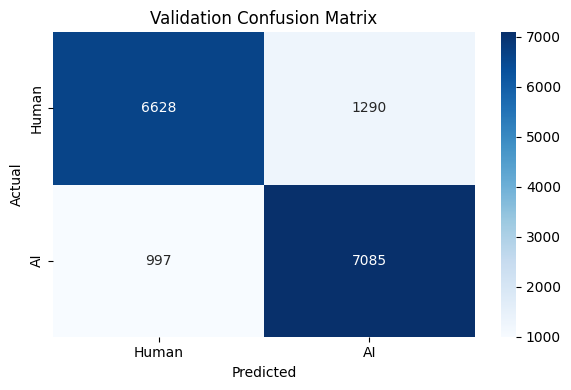


Running error analysis for SGD without features

--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
Correct Predictions:
 count    13713.000000
mean      2255.434332
std       2850.236608
min          5.000000
25%        884.000000
50%       1038.000000
75%       3351.000000
max      48723.000000
Name: text_length, dtype: float64

Incorrect Predictions:
 count     2287.000000
mean      2066.177962
std       2084.071537
min         16.000000
25%        655.500000
50%       1353.000000
75%       3268.500000
max      26340.000000
Name: text_length, dtype: float64

TN Predictions:
 count     6628.000000
mean      2391.900573
std       3730.010701
min         38.000000
25%        910.000000
50%        952.000000
75%       1944.250000
max      48723.000000
Name: text_length, dtype: float64

FP Predictions:
 count     1290.000000
mean      2106.026357
std       2419.047431
min         40.000000
25%        661.250000
50%       1222.500000
75%       3148.000000
max      263

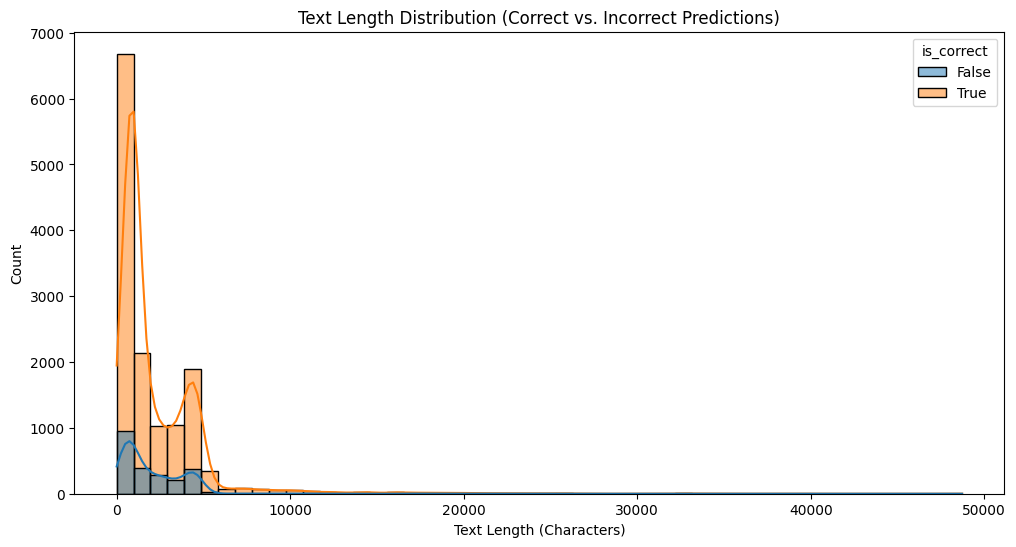

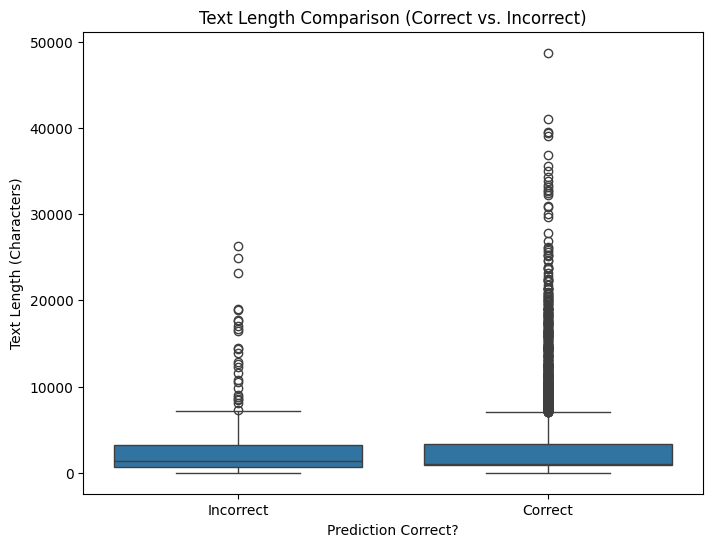

/content/error_analysis.py:182: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Result Type')


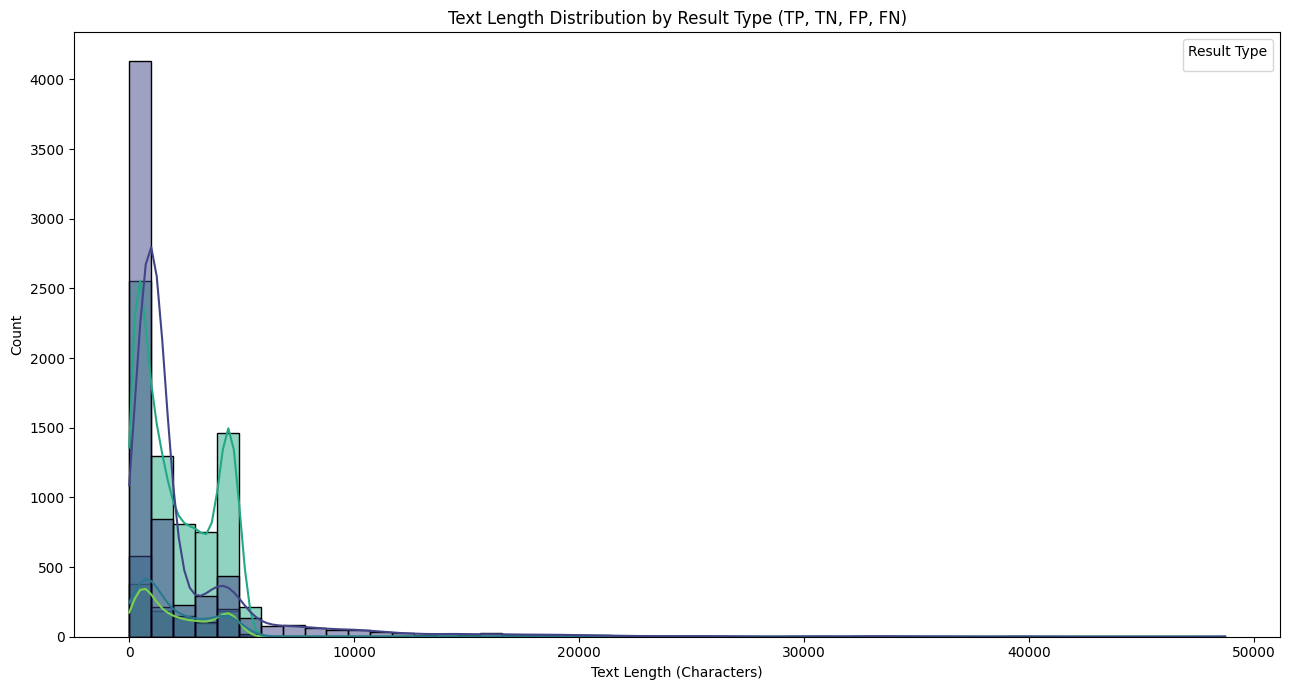

/content/error_analysis.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='result_type', y='text_length',


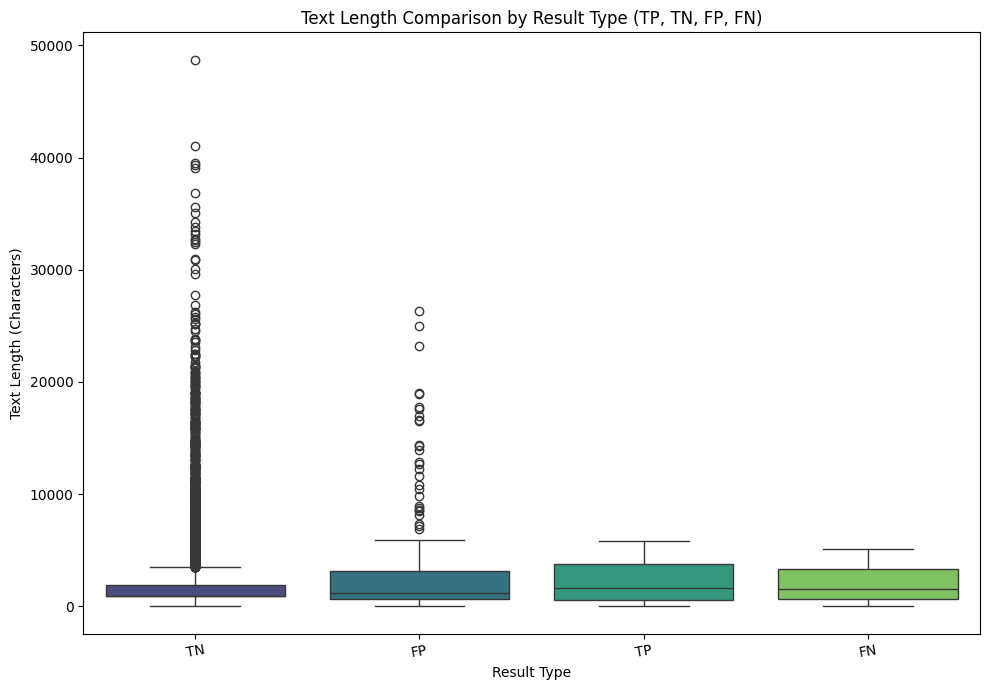


--- Analyzing Text Complexity ---


Calculating Complexity:   0%|          | 0/16000 [00:00<?, ?it/s]


Average Complexity Scores:
            difficult_words
is_correct                 
False             62.450372
True              65.903158


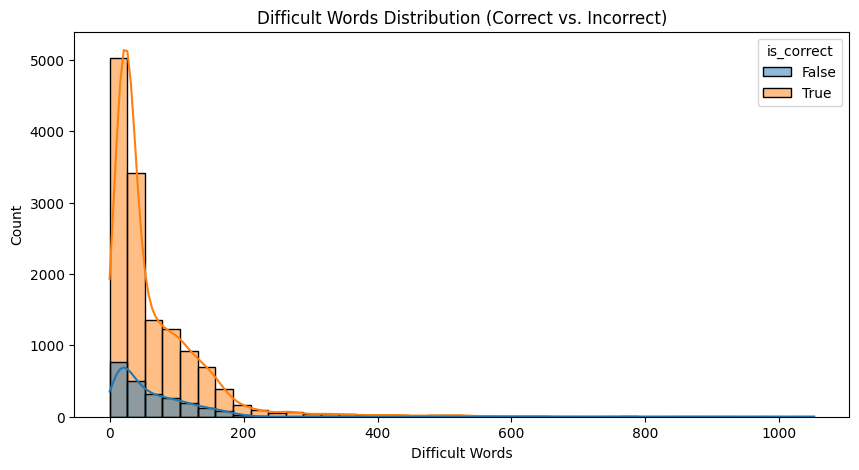


--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---

Descriptive Statistics for Complexity Metrics by Result Type:

--- Difficult Words ---
              count       mean         std  min   25%   50%    75%     max
result_type                                                               
TN           6628.0  71.901629  105.210133  0.0  22.0  29.0   70.0  1052.0
FP           1290.0  68.268992   69.070733  0.0  20.0  44.0  103.0   684.0
TP           7085.0  60.291602   46.460528  0.0  19.0  50.0   93.0   219.0
FN            997.0  54.921765   42.064541  0.0  20.0  44.0   82.0   198.0


/content/error_analysis.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data_metric, x='result_type', y=metric, order=type_order, palette='viridis')


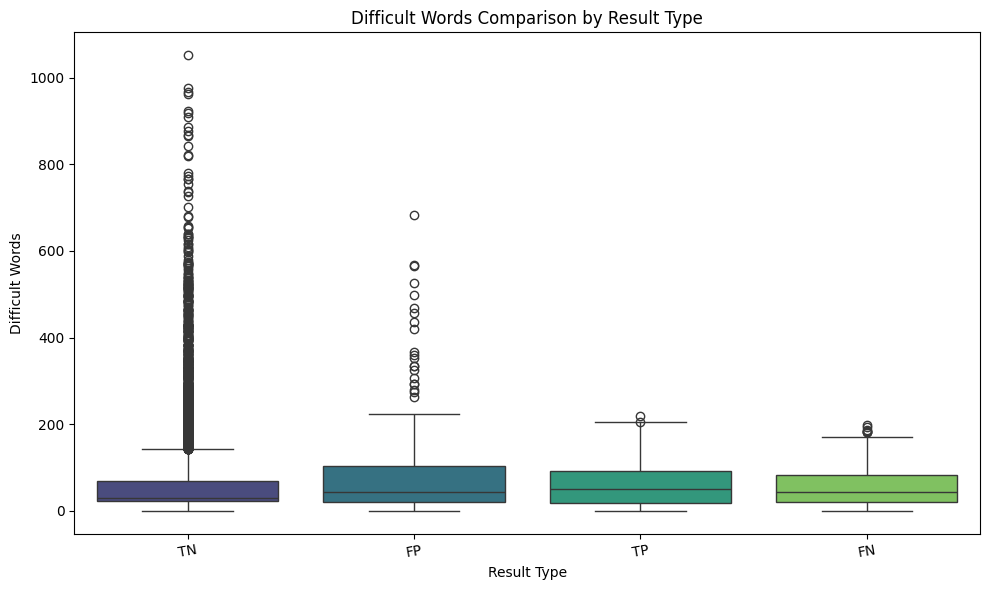

Could not generate legend for difficult_words histogram.


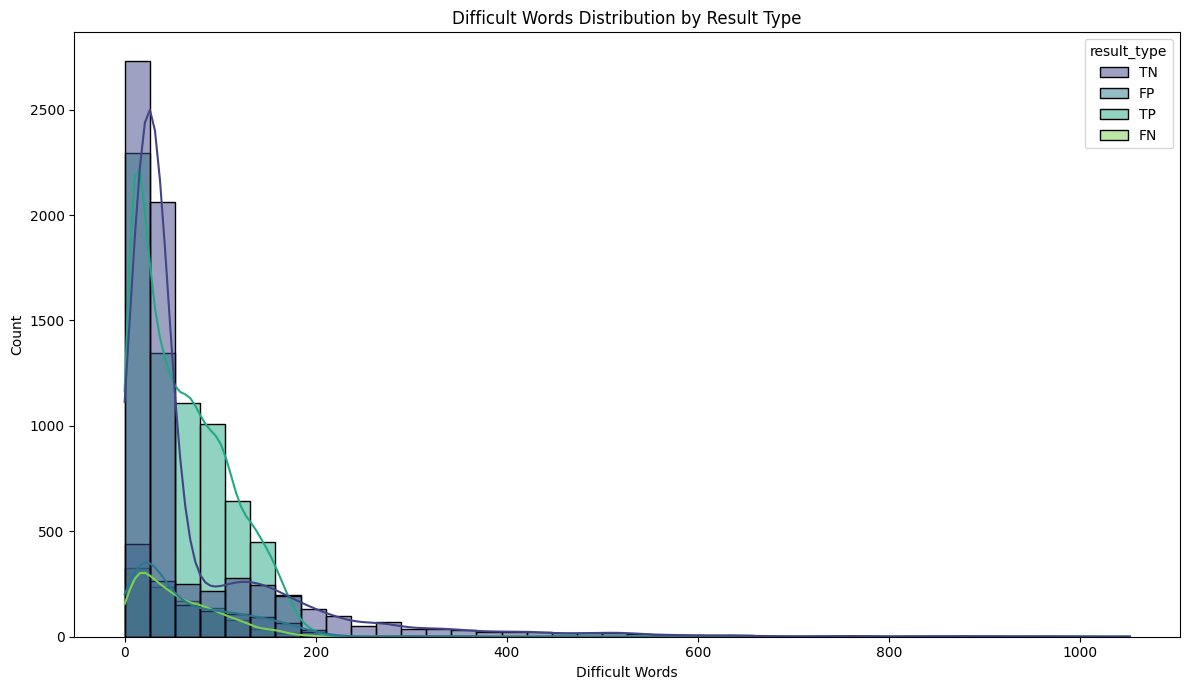


--- Analyzing Top Keywords ---

Top 20 Keywords for Correct Predictions:
   Keyword  Frequency
0     said      13255
1   people      12613
2      new      11578
3     time       9722
4     like       9117
5     just       8864
6     make       7090
7      way       5986
8      use       5926
9     know       5396
10   world       5394
11   years       5191
12    work       4841
13    good       4829
14    dont       4652
15    want       4626
16   going       4594
17    need       4548
18   think       4416
19    used       4368


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


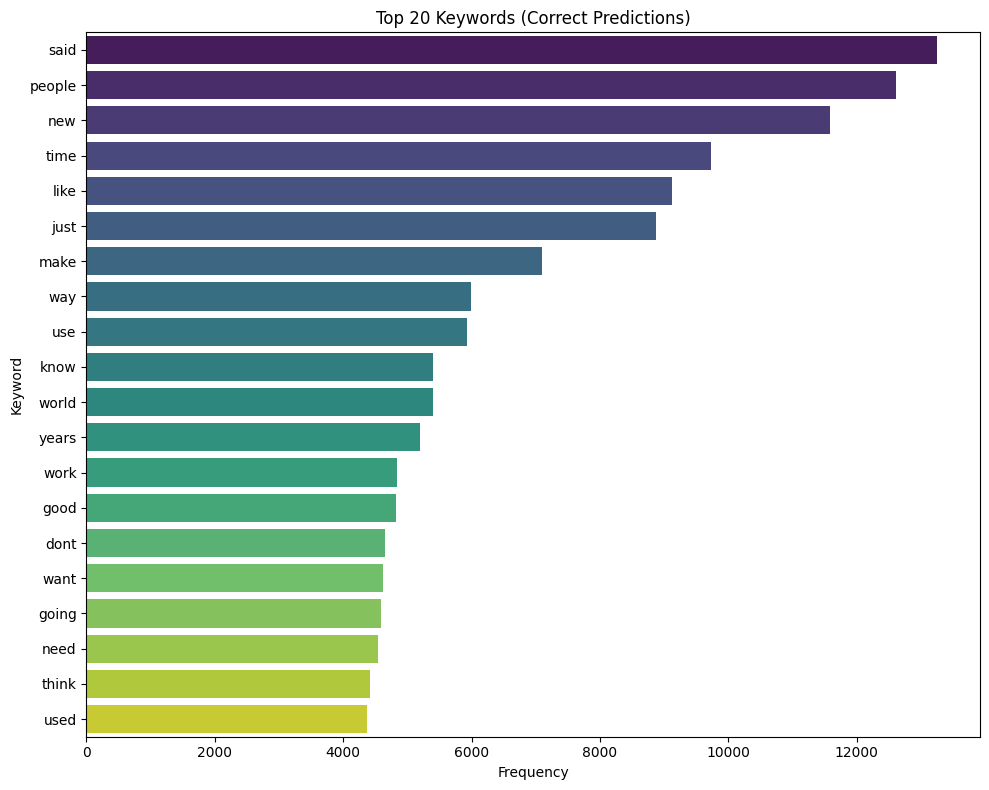


Top 20 Keywords for Incorrect Predictions:
   Keyword  Frequency
0     said       2202
1   people       1656
2      new       1625
3     time       1500
4     just       1472
5     like       1463
6     make       1026
7      use        951
8      way        885
9    years        866
10    dont        837
11    know        821
12   world        776
13    year        755
14    want        682
15    good        677
16    used        671
17   going        652
18    need        644
19   think        630


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


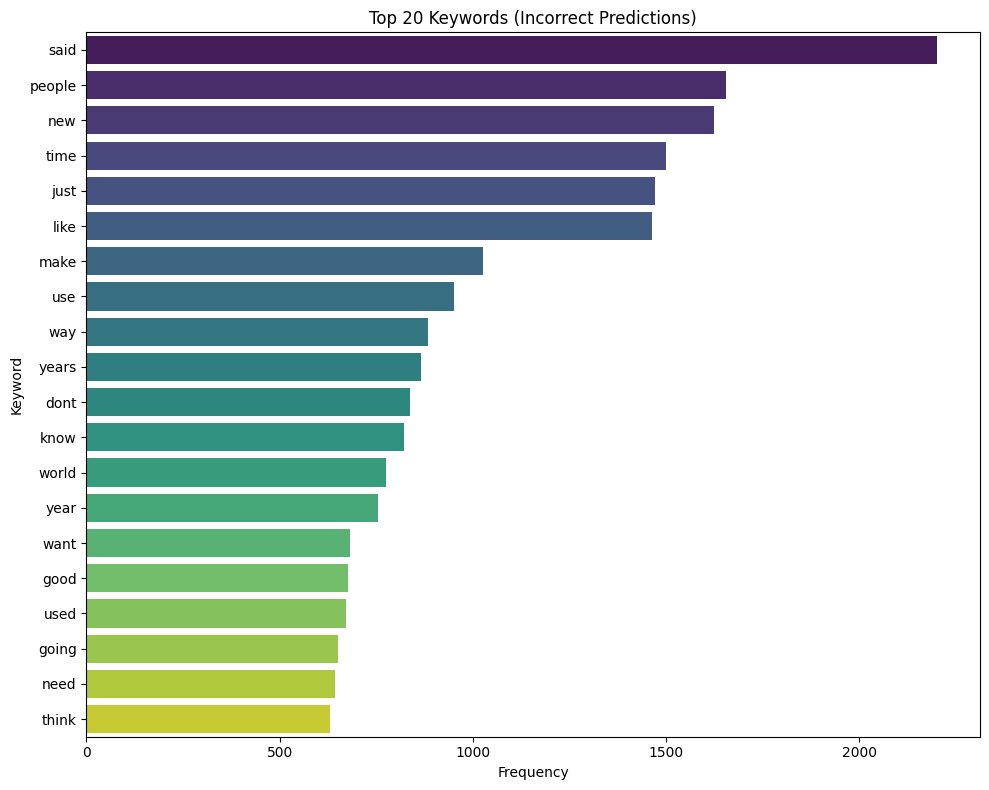


Top 20 Keywords for True Negatives:
      Keyword  Frequency
0      people       5264
1        time       4763
2        like       4353
3        just       4028
4         new       3713
5        said       3315
6     company       2880
7       world       2814
8         way       2664
9        life       2663
10        use       2563
11       work       2414
12       know       2404
13       make       2315
14       used       2276
15      years       2265
16  different       2250
17        man       2071
18   business       2071
19        did       2063


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


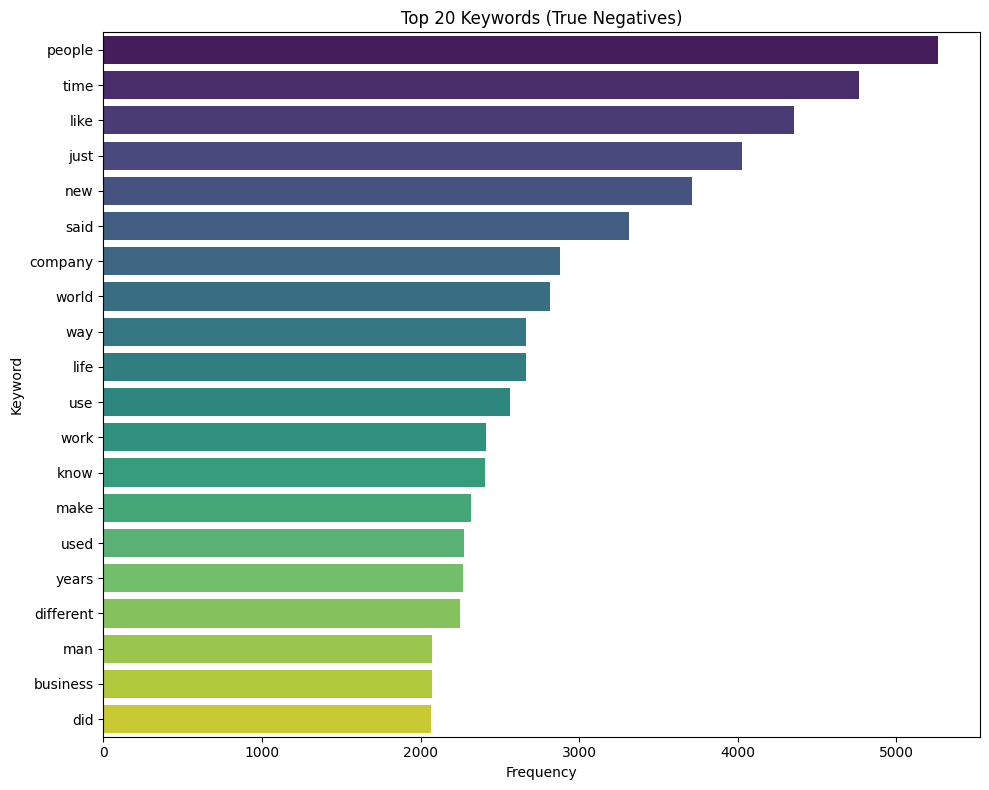


Top 20 Keywords for False Positives:
       Keyword  Frequency
0         said       1265
1       people       1025
2          new        959
3         time        798
4         like        785
5         just        748
6         make        556
7         year        537
8          use        534
9          way        504
10       years        477
11       world        460
12        dont        415
13  government        407
14        want        403
15        good        395
16       women        376
17        know        372
18       state        370
19      police        368


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


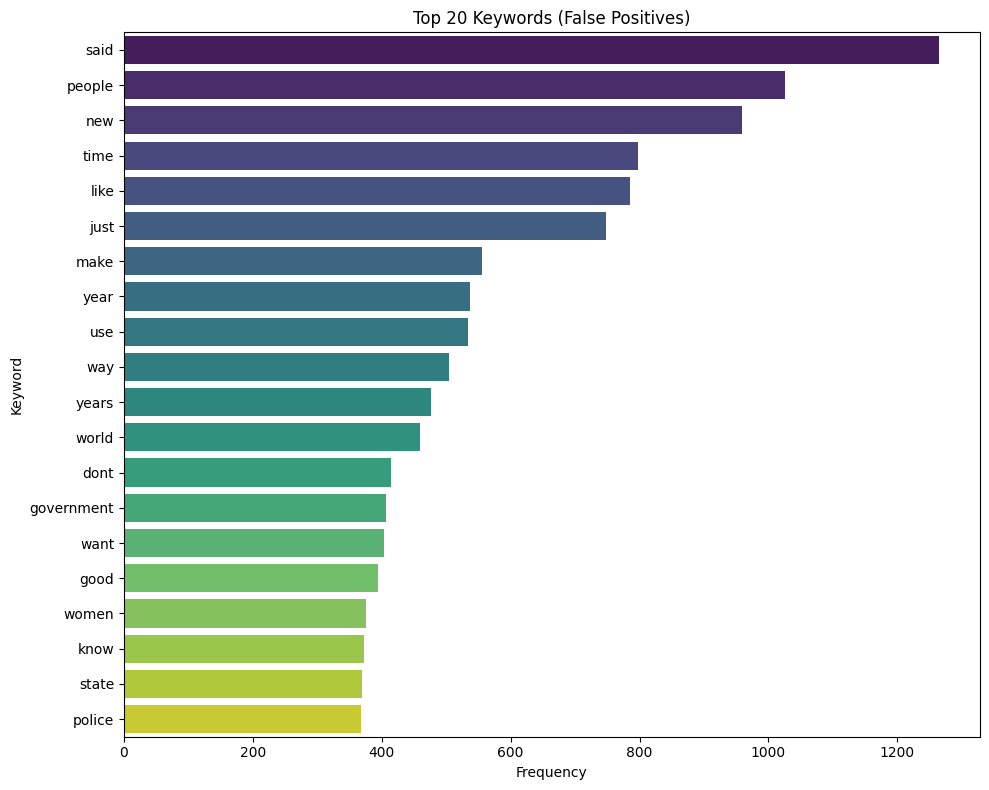


Top 20 Keywords for False Negatives:
   Keyword  Frequency
0     said        937
1     just        724
2     time        702
3     like        678
4      new        666
5   people        631
6     make        470
7     know        449
8     dont        422
9      use        417
10   years        389
11     way        381
12   right        339
13    used        337
14     man        335
15   going        324
16   world        316
17     did        287
18      im        287
19   think        285


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


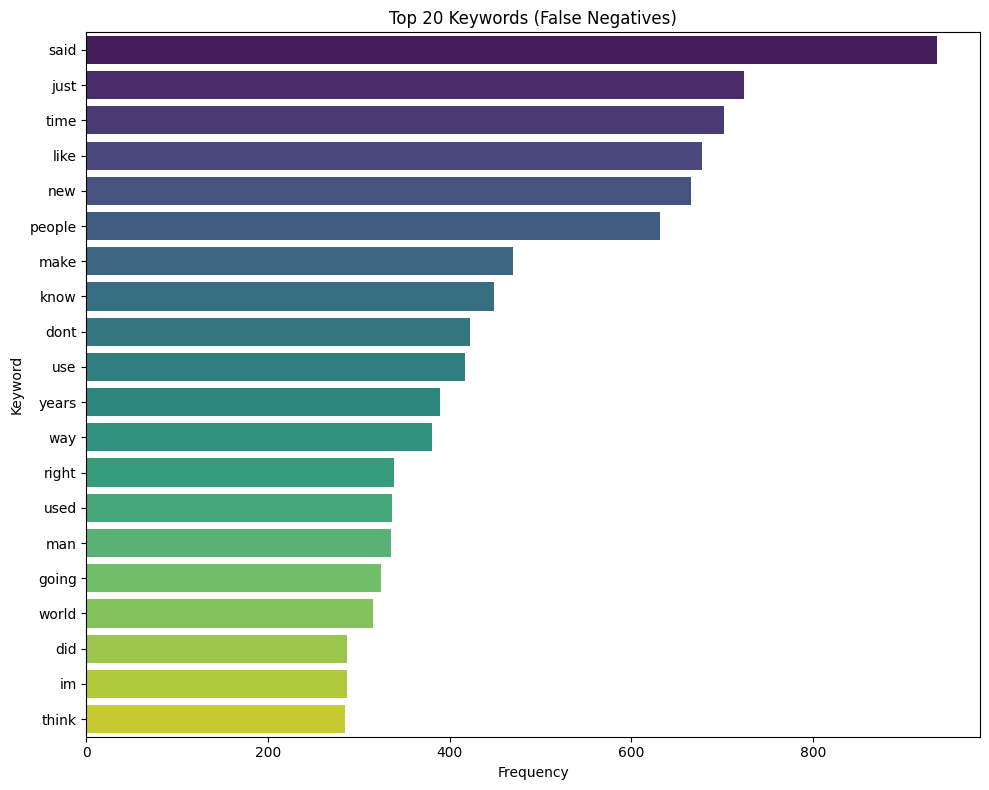


Top 20 Keywords for True Positives:
       Keyword  Frequency
0         said       9940
1          new       7865
2       people       7349
3         time       4959
4         just       4836
5         make       4775
6         like       4764
7         want       3496
8          use       3363
9          way       3322
10       going       3191
11        dont       3105
12       think       2999
13        know       2992
14        good       2985
15       years       2926
16        year       2919
17        game       2831
18  government       2793
19        need       2745


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


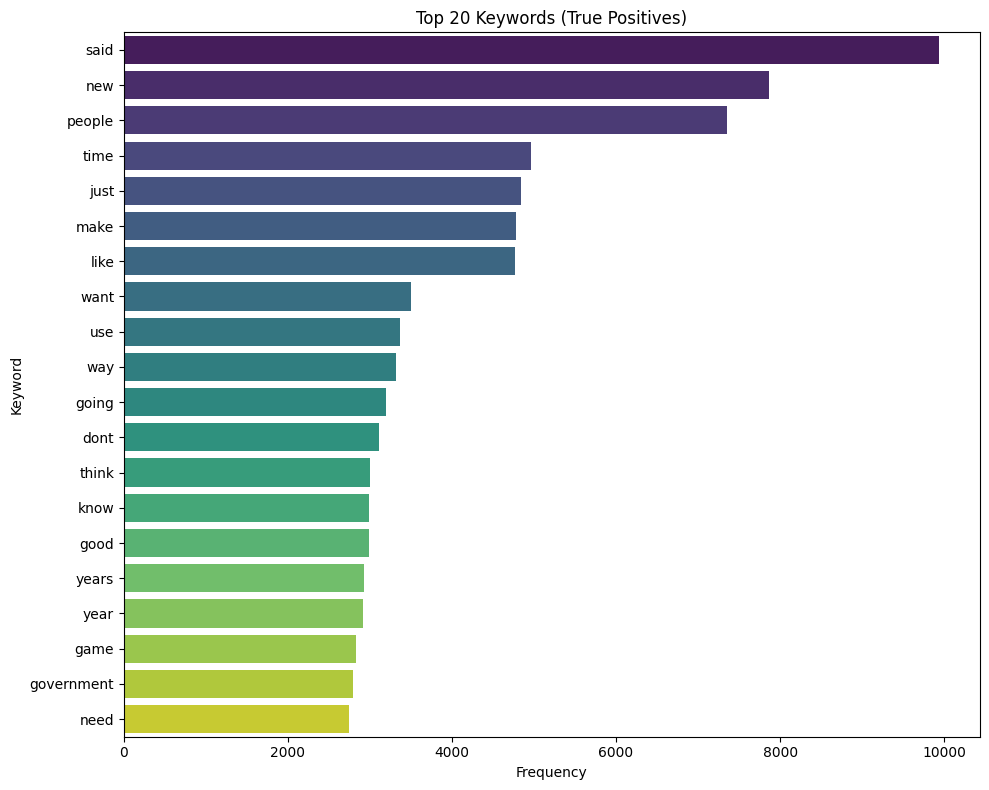


--- Analyzing N-grams ---

-- Top 2-grams --

Top 2-grams for Correct Predictions:
      2-gram  Frequency
0     of the      37986
1     in the      31505
2     to the      16250
3     on the      12641
4    and the      10292
5      to be       9878
6    for the       9445
7   that the       8967
8      it is       7909
9       in a       7734
10  with the       7625
11    at the       7079
12      is a       7012
13  from the       6577
14      of a       6285
15      as a       5782
16    by the       5700
17    it was       5496
18    is the       4813
19   this is       4564


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


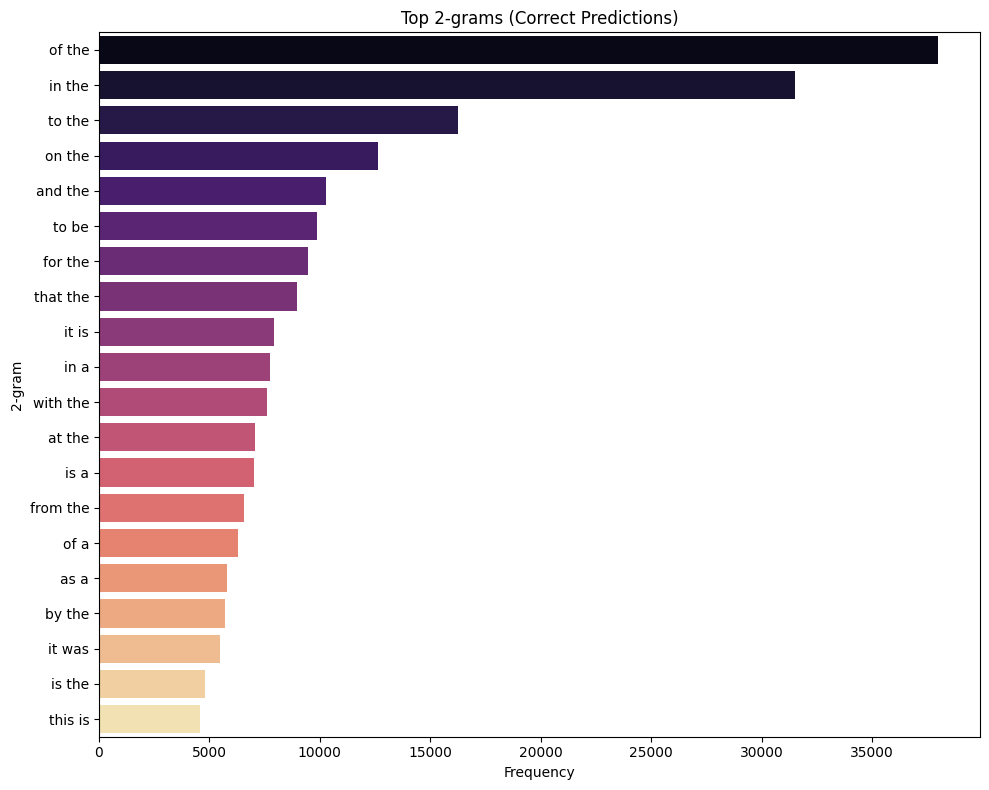


Top 2-grams for Incorrect Predictions:
      2-gram  Frequency
0     of the       5463
1     in the       4546
2     to the       2246
3     on the       1826
4    for the       1454
5    and the       1406
6      to be       1402
7   that the       1226
8     at the       1216
9       in a       1169
10      is a       1073
11  from the       1060
12  with the       1051
13     it is        996
14      of a        938
15      as a        861
16    by the        847
17    it was        804
18   will be        758
19    with a        737


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


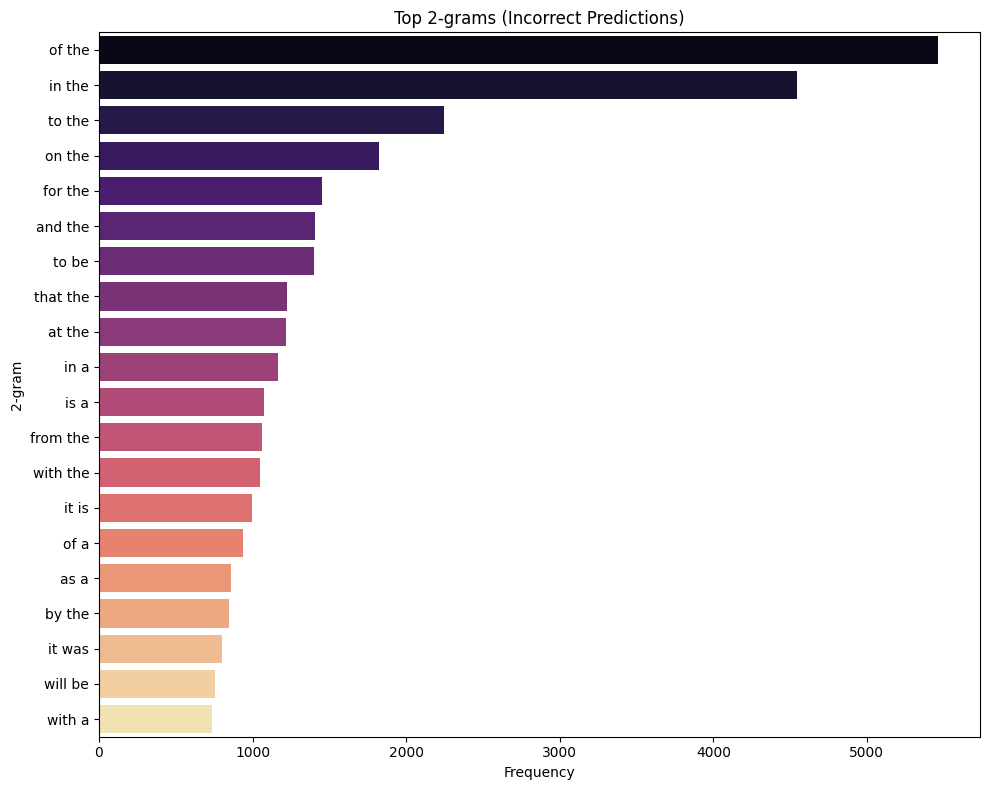

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


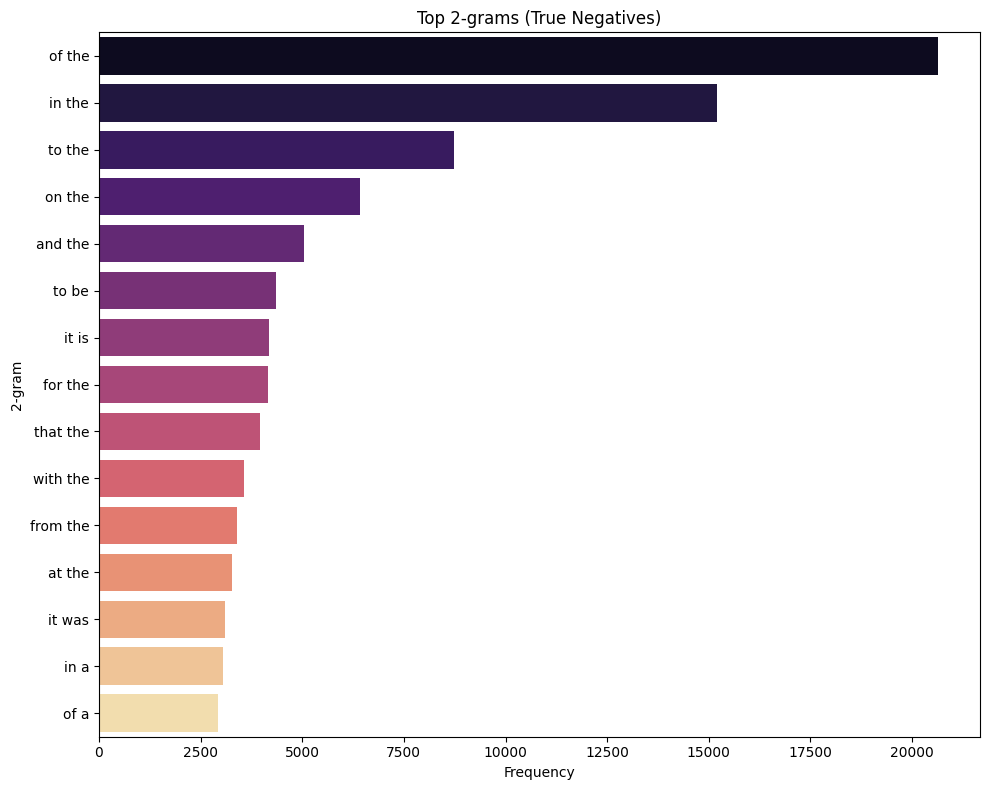

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


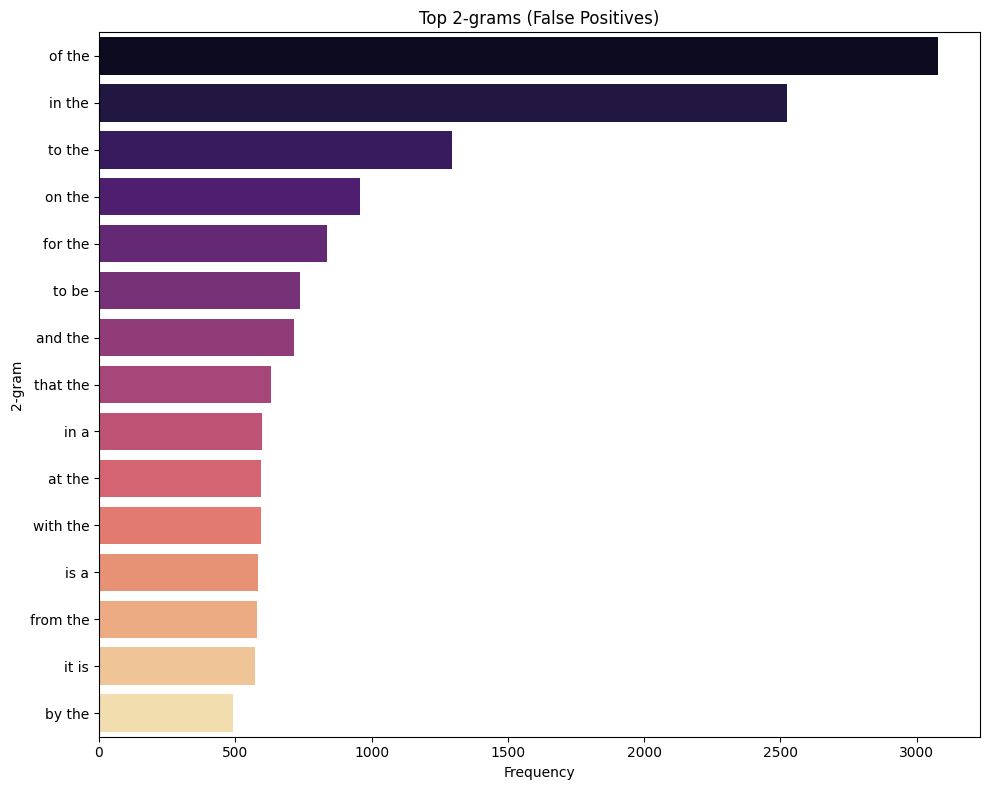

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


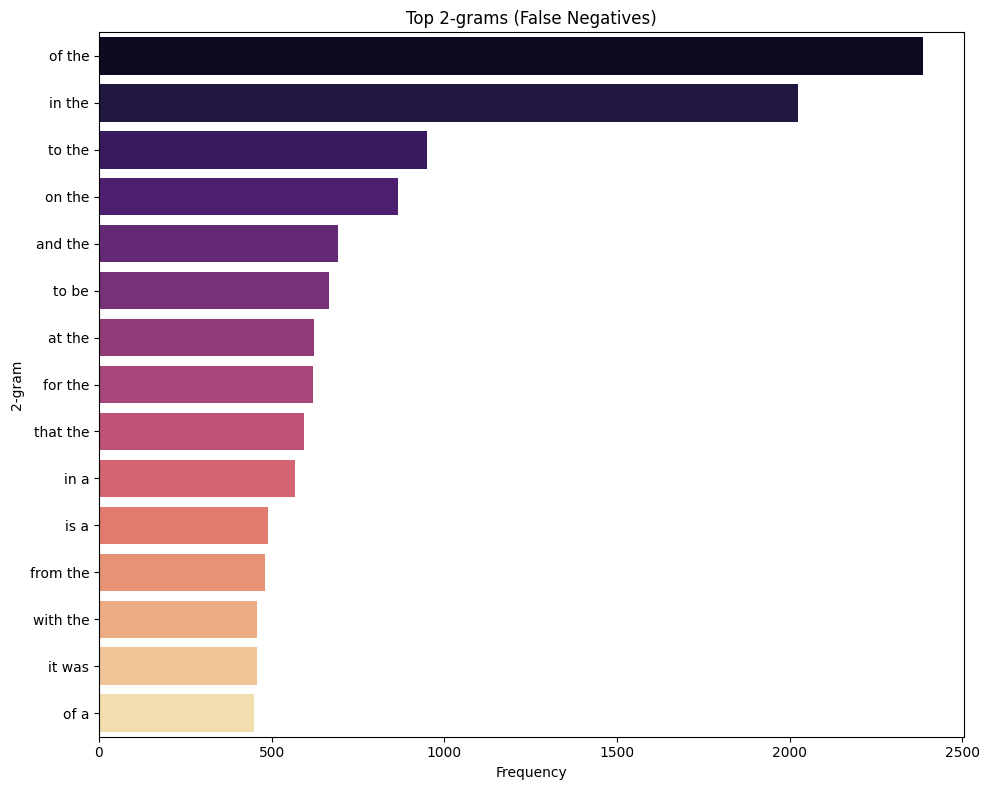

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


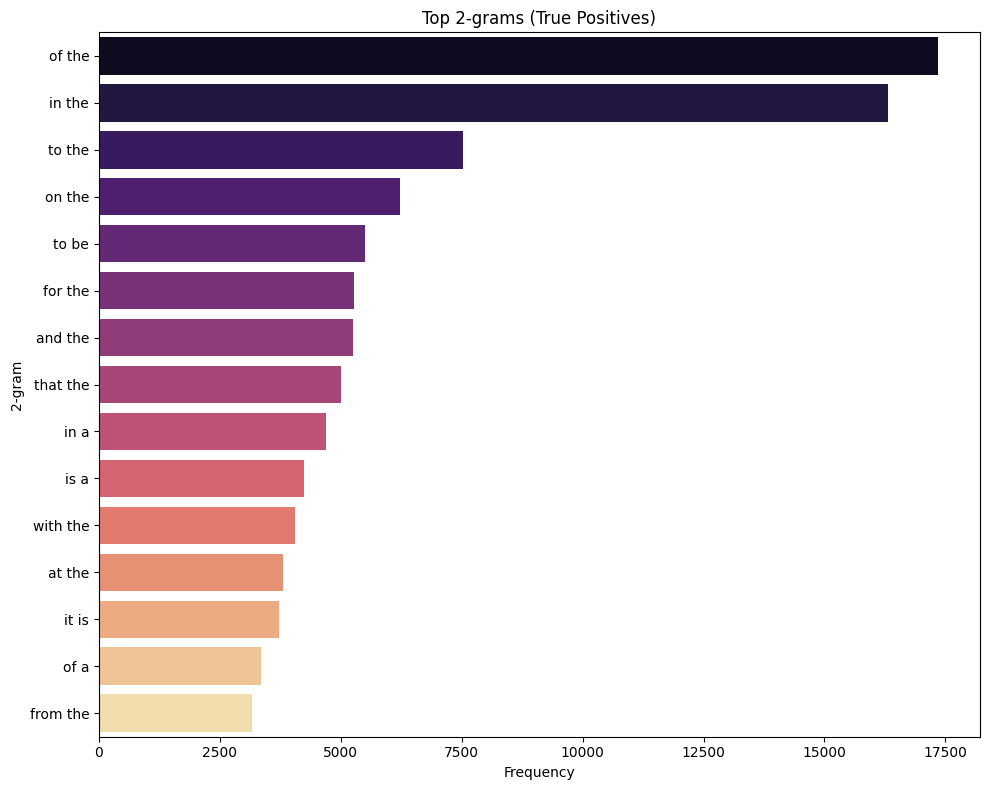


-- Top 3-grams --

Top 3-grams for Correct Predictions:
               3-gram  Frequency
0          one of the       2820
1            a lot of       2235
2   the united states       2153
3          as well as       1857
4         in order to       1443
5          be able to       1401
6       the fact that       1298
7         some of the       1185
8    according to the       1143
9         a number of       1005
10            to be a        988
11      the number of        950
12        part of the        896
13         there is a        888
14         the use of        861
15        as a result        817
16         the end of        798
17      in the united        797
18          this is a        793
19       in the world        783


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


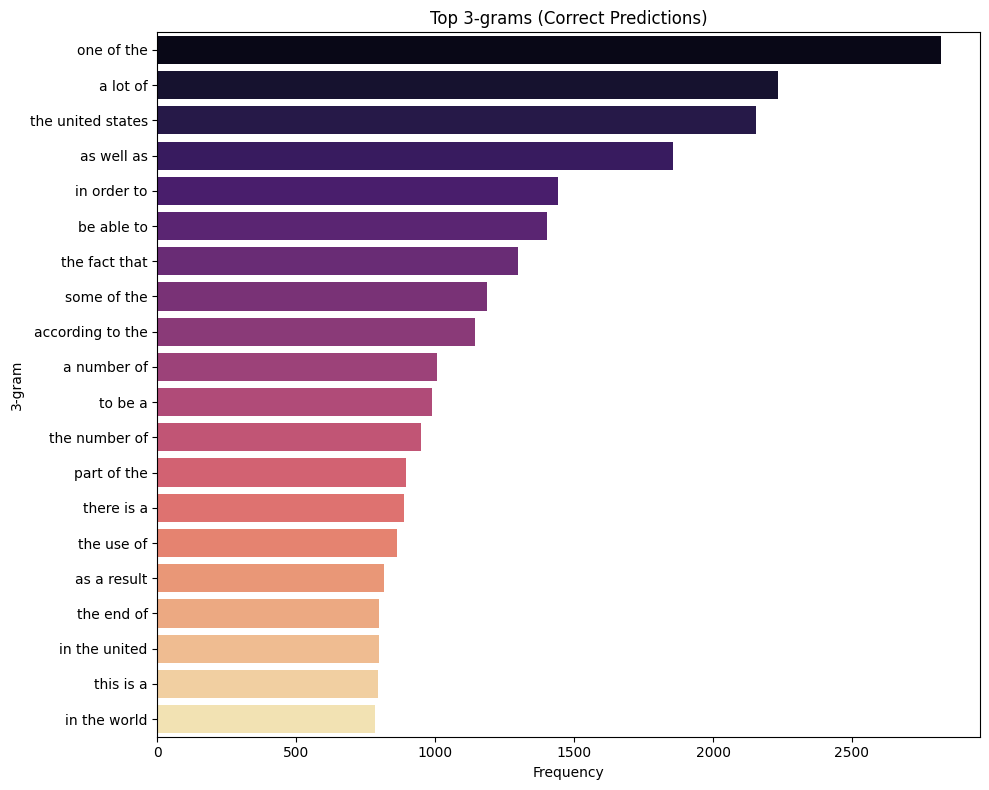


Top 3-grams for Incorrect Predictions:
               3-gram  Frequency
0          one of the        368
1            a lot of        282
2   the united states        247
3          as well as        224
4          be able to        208
5    according to the        184
6         some of the        163
7         part of the        158
8             to be a        155
9         in order to        150
10         the end of        148
11         out of the        137
12          this is a        136
13      the fact that        132
14        a number of        122
15       in the world        118
16     the first time        108
17         there is a        107
18        you want to        105
19           it was a        102


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


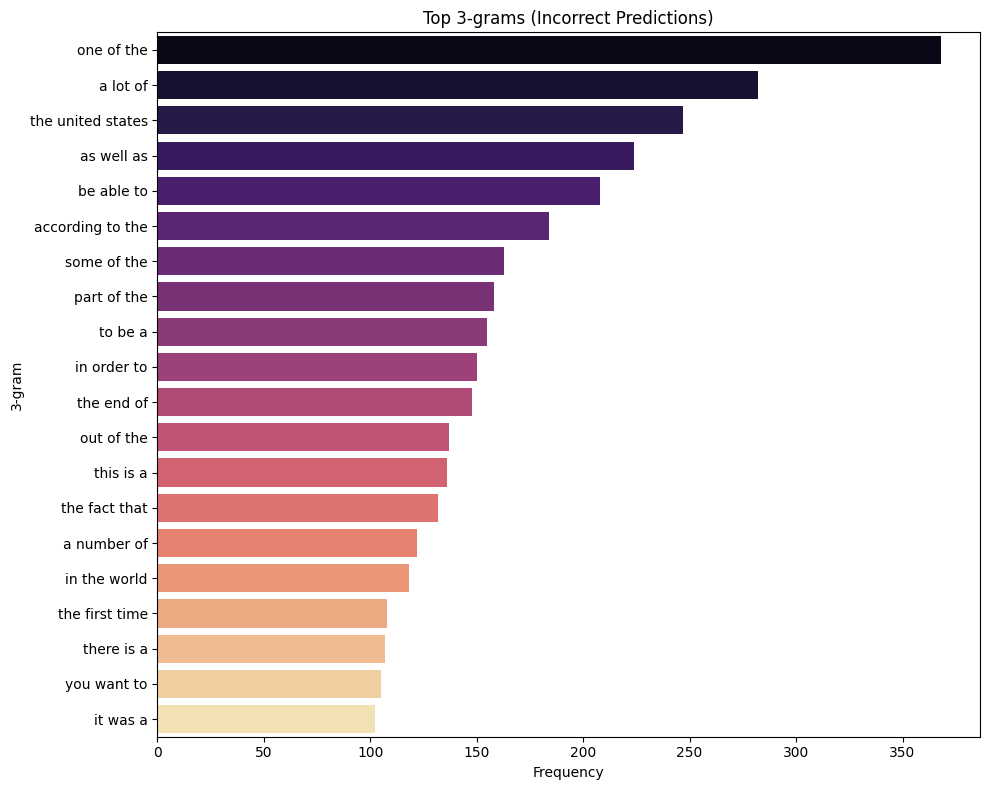

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


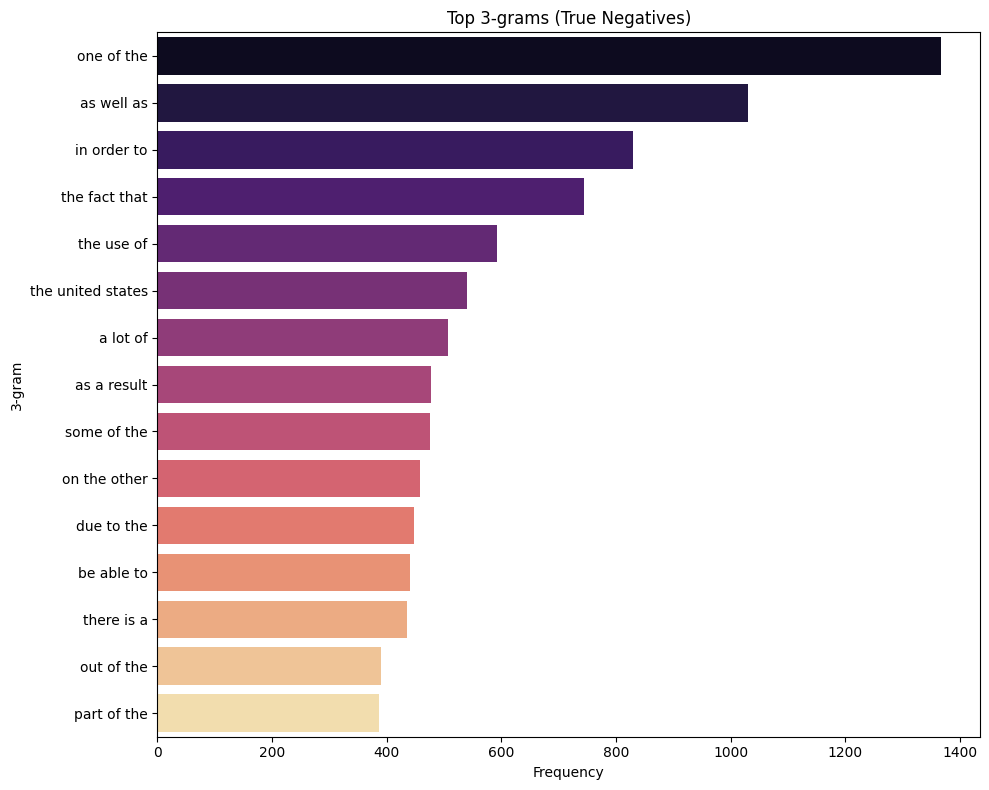

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


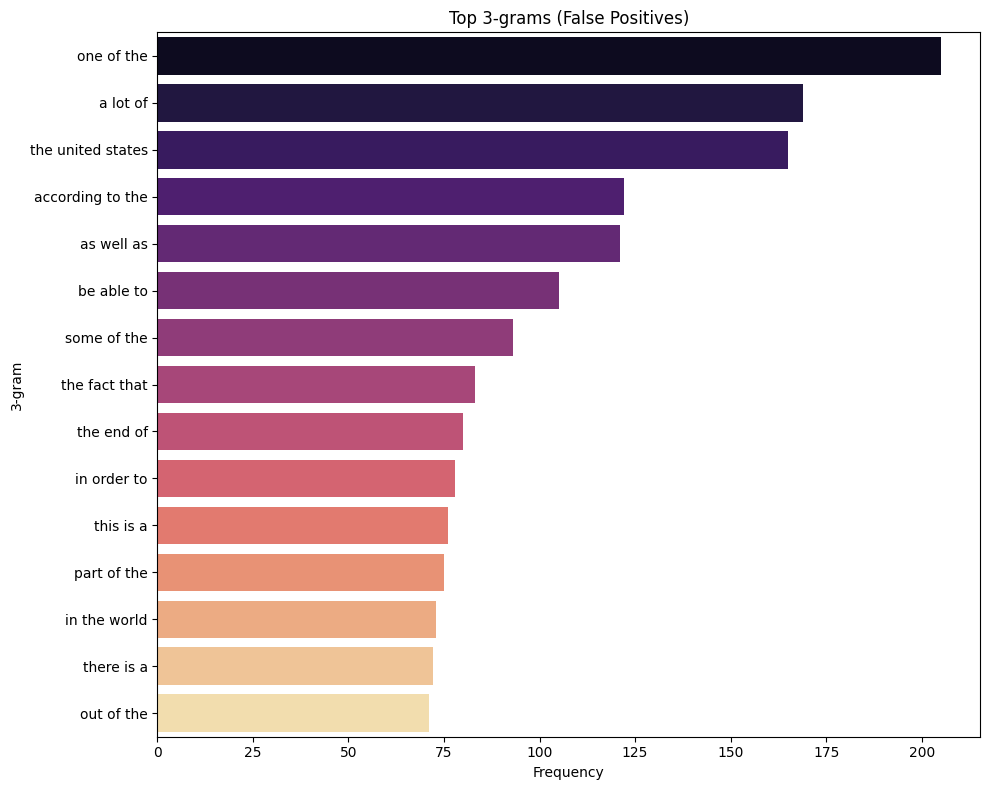

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


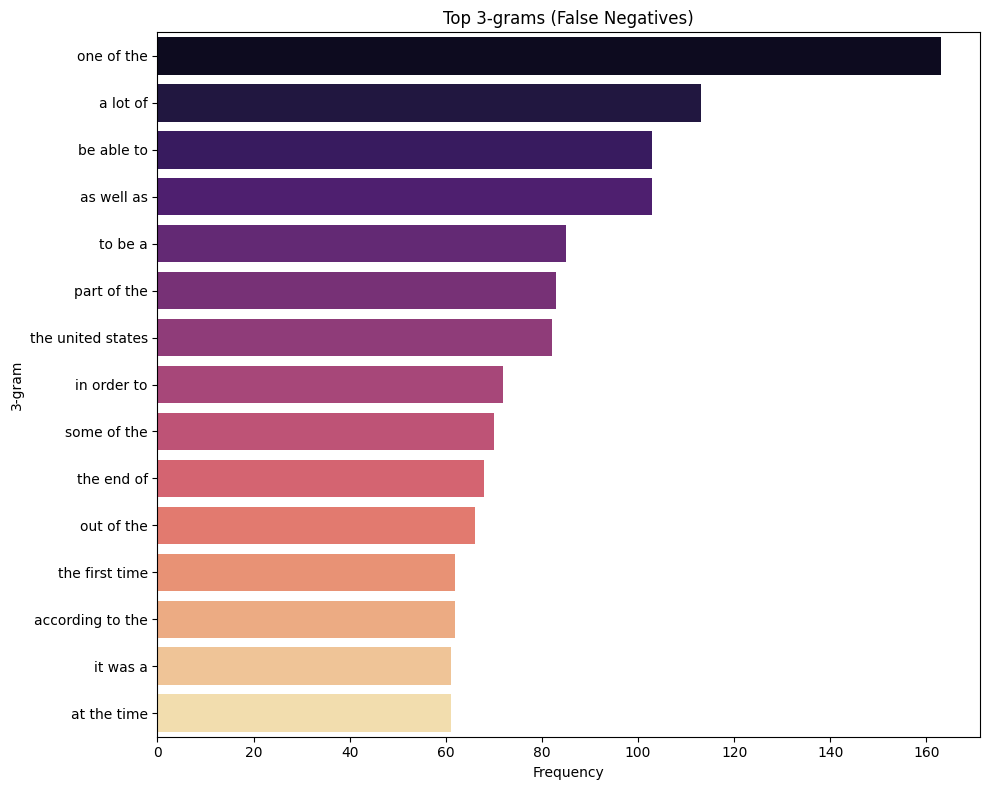

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


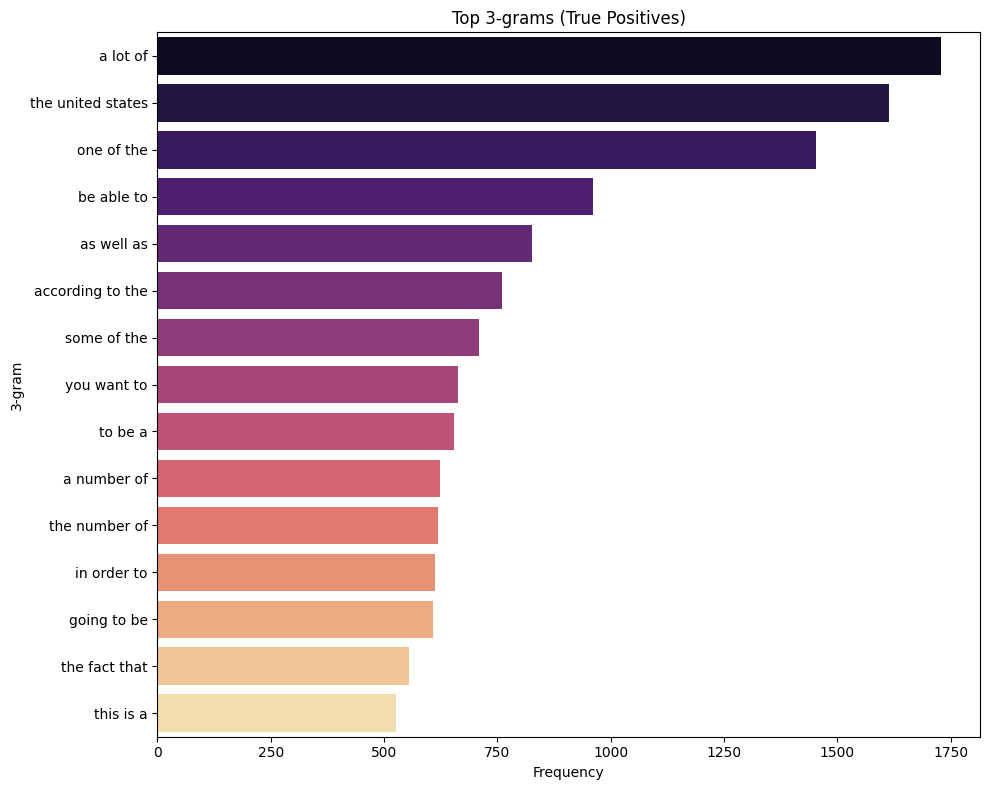


--- Analyzing Prediction Confidence ---


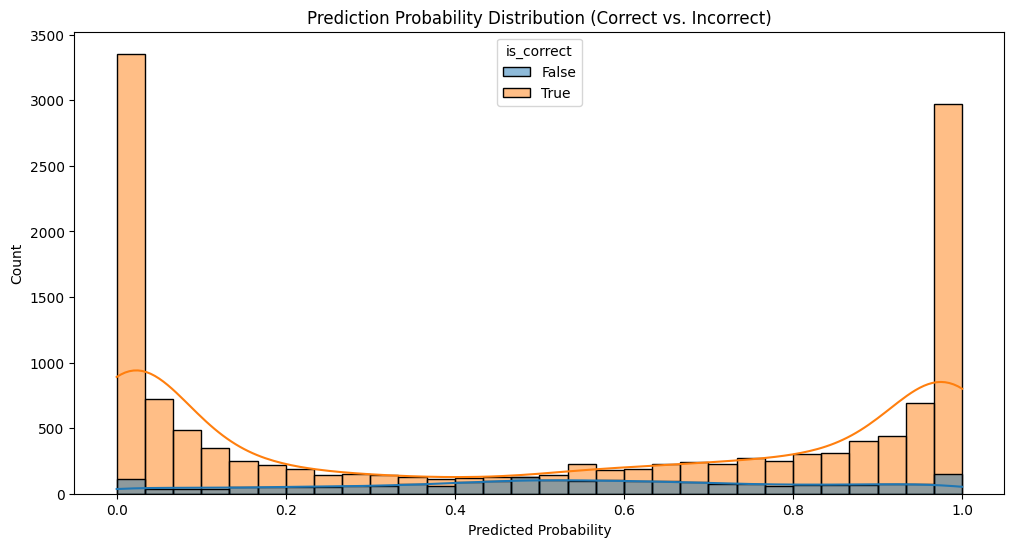


Average Prediction Probability:
is_correct
False    0.541522
True     0.497432
Name: pred_probability, dtype: float64

--- Analyzing Prediction Confidence by result type ---


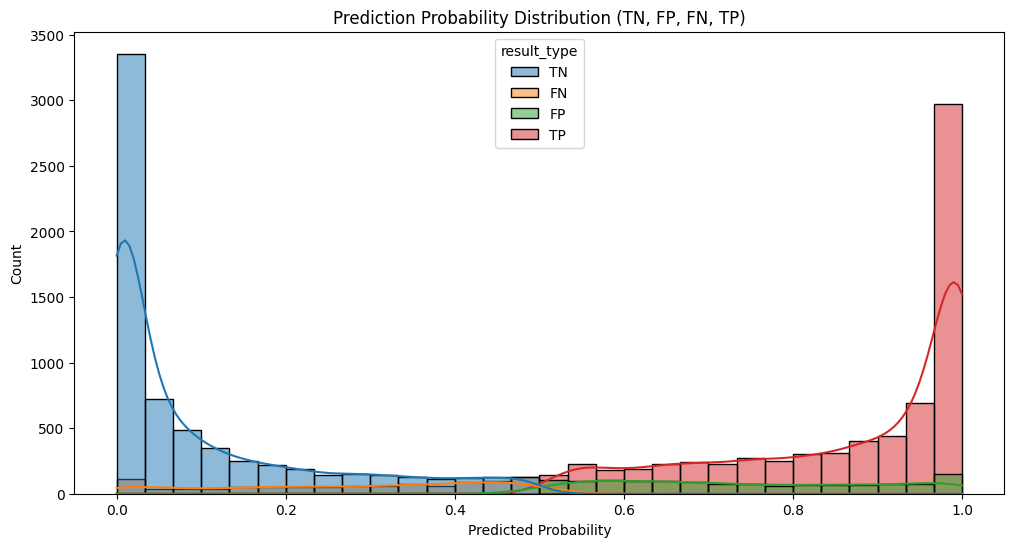


Average Prediction Probability:
result_type
FN    0.278292
FP    0.744964
TN    0.096649
TP    0.872363
Name: pred_probability, dtype: float64

--- Analyzing High-Confidence Errors Examples ---
Found 295 examples where the prediction was incorrect
but the model's confidence in the wrong prediction was > 0.90

--- Top 10 Most Confident Errors ---

--- Example Index: 9850 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 1.0000
  Text Snippet:     the history of the decade essay introduction the tragedy of the had a significant impact on the economical development of the united states as well as its role in the international relations ten years down the line the occurrences of that day are still fresh in peoples minds it is an incident that changed americas history and image within a relatively short period of time in the aftermath of the the united states had to face the challenges of the economical downturn war on terror oil crisis and ...
-------------------------

In [6]:
#### SGD Model Error Analysis(Without Features)

print("\n" + "="*80)
print("Running SGD Model Error Analysis")
print("="*80)

for use_features in [False]:
    print(f"\nRunning SGD {'with' if use_features else 'without'} linguistic features")

    #Preprocess data
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = preprocess_data_sgd(
        use_linguistic_features=use_features,
        train_csv_path=train_path,
        val_csv_path=val_path,
        test_csv_path=test_path
    )

    #Train model
    model = train_sgd(X_train, y_train, use_features)

    val_results = evaluate_model_sgd(model, X_val, y_val, "Validation", use_features)

    val_df = pd.read_csv(val_path)
    val_df = val_df.dropna(subset=['text', 'label'])
    val_df['label'] = val_df['label'].astype(int)

    vectorizer = joblib.load("processed_data/sgd_vectorizer.joblib")

    #predict
    if use_features:
        scaler = joblib.load("processed_data/sgd_scaler.joblib")
        text_features = vectorizer.transform(val_df['text']).toarray()
        ling_features = scaler.transform(
            val_df['text'].apply(extract_linguistic_features_sgd).apply(pd.Series)
        )
        combined_features = np.hstack([text_features, ling_features])
        val_df['prediction'] = model.predict(combined_features)
        val_df['pred_probability'] = model.predict_proba(combined_features)[:, 1]
    else:
        text_features = vectorizer.transform(val_df['text']).toarray()
        val_df['prediction'] = model.predict(text_features)
        val_df['pred_probability'] = model.predict_proba(text_features)[:, 1]

    val_df['is_correct'] = val_df['label'] == val_df['prediction']
    val_df['result_type'] = val_df.apply(
        lambda x: 'TP' if x['label']==1 and x['is_correct'] else
                 ('TN' if x['label']==0 and x['is_correct'] else
                 ('FP' if x['label']==0 else 'FN')), axis=1)

    output_dir = os.path.join("results", f"sgd_{'with_features' if use_features else 'no_features'}")
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nRunning error analysis for SGD {'with' if use_features else 'without'} features")
    run_error_analysis(val_df, output_dir, use_features)




Running SGD Model Error Analysis

Running SGD with linguistic features

Training SGD model...
Training completed in 365.52 seconds

Validation Set Performance:
Accuracy: 0.8536
F1 Score: 0.8562
ROC AUC: 0.9250


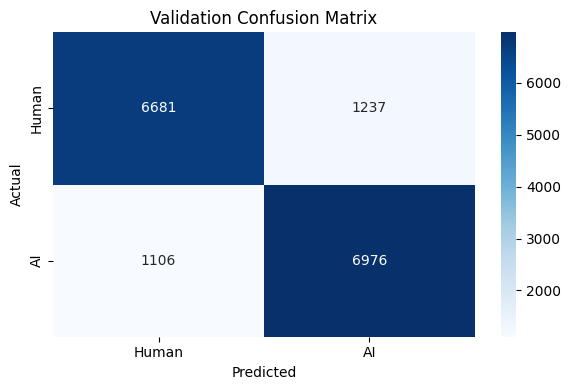


Running error analysis for SGD with features

--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
Correct Predictions:
 count    13657.000000
mean      2280.245808
std       2865.846116
min          5.000000
25%        889.000000
50%       1071.000000
75%       3379.000000
max      48723.000000
Name: text_length, dtype: float64

Incorrect Predictions:
 count     2343.000000
mean      1926.078959
std       1958.660597
min          7.000000
25%        561.500000
50%       1180.000000
75%       3121.000000
max      24951.000000
Name: text_length, dtype: float64

TN Predictions:
 count     6681.000000
mean      2393.991917
std       3745.171099
min         38.000000
25%        909.000000
50%        952.000000
75%       1956.000000
max      48723.000000
Name: text_length, dtype: float64

FP Predictions:
 count     1237.000000
mean      2082.482619
std       2209.773911
min         50.000000
25%        761.000000
50%       1255.000000
75%       3108.000000
max      24951.

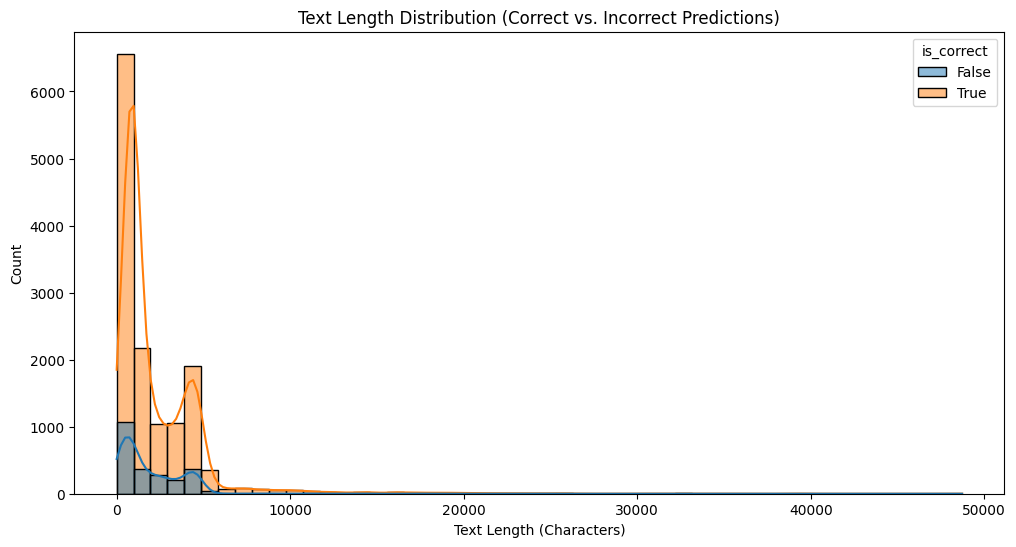

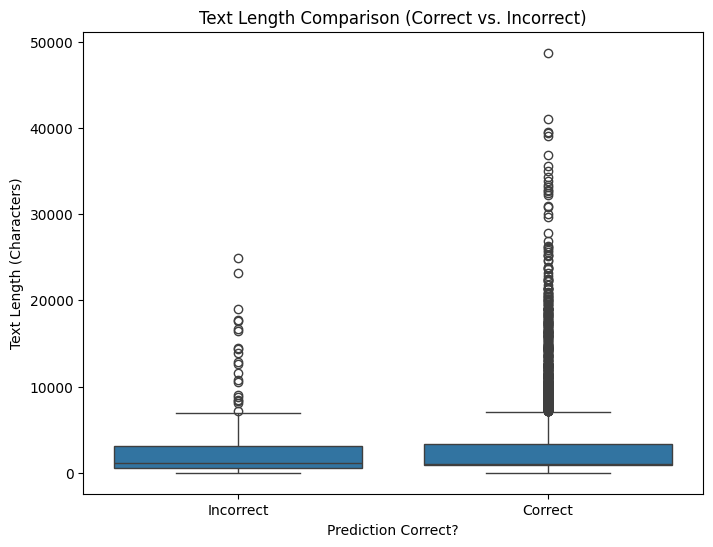

/content/error_analysis.py:182: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Result Type')


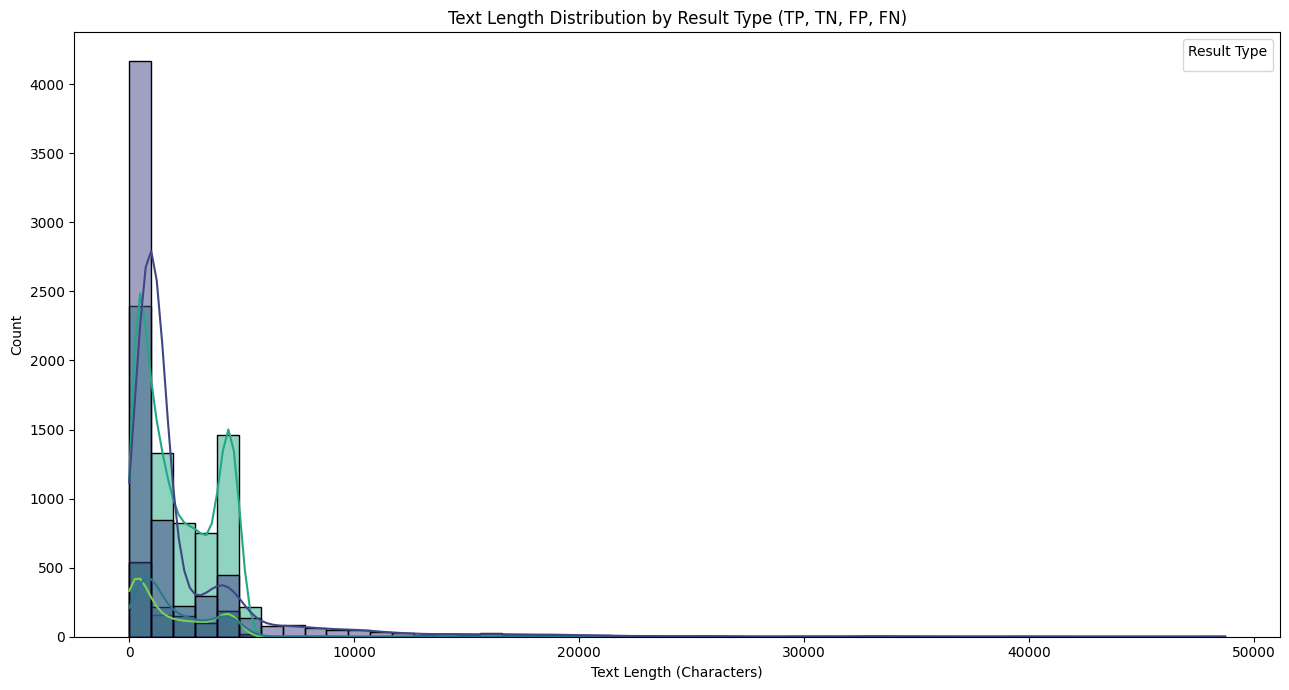

/content/error_analysis.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='result_type', y='text_length',


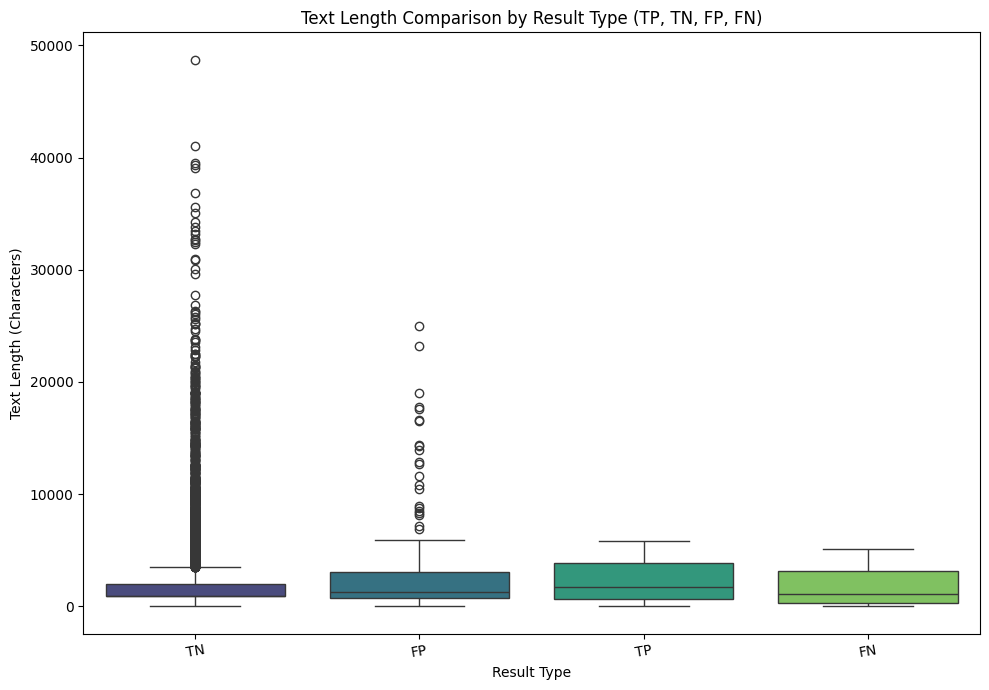


--- Analyzing Text Complexity ---


Calculating Complexity:   0%|          | 0/16000 [00:00<?, ?it/s]


Average Complexity Scores:
            difficult_words
is_correct                 
False             58.321810
True              66.625613


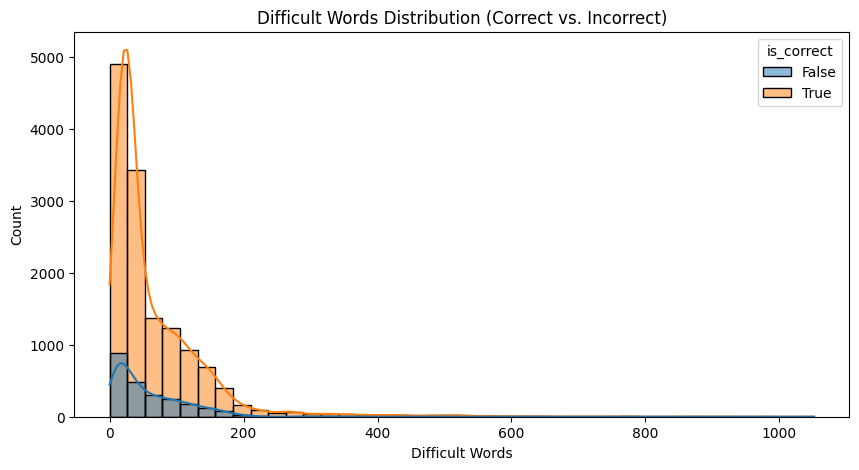


--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---

Descriptive Statistics for Complexity Metrics by Result Type:

--- Difficult Words ---
              count       mean         std  min   25%   50%    75%     max
result_type                                                               
TN           6681.0  72.051190  105.576408  0.0  22.0  29.0   71.0  1052.0
FP           1237.0  67.305578   63.843080  1.0  21.0  44.0  101.0   565.0
TP           6976.0  61.429472   46.049438  0.0  21.0  52.0   94.0   219.0
FN           1106.0  48.273960   43.830979  0.0  11.0  35.0   77.0   198.0


/content/error_analysis.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data_metric, x='result_type', y=metric, order=type_order, palette='viridis')


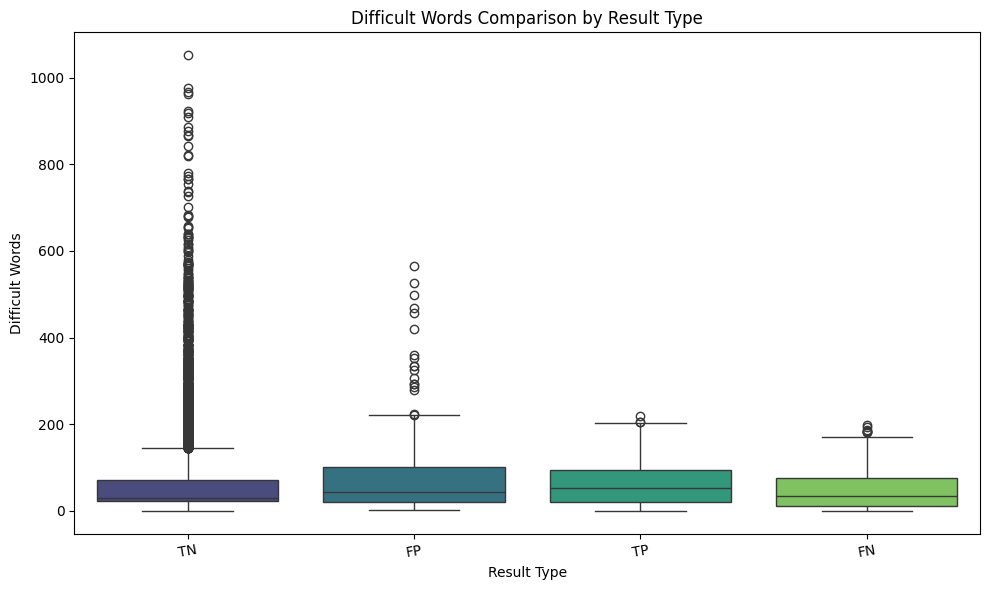

Could not generate legend for difficult_words histogram.


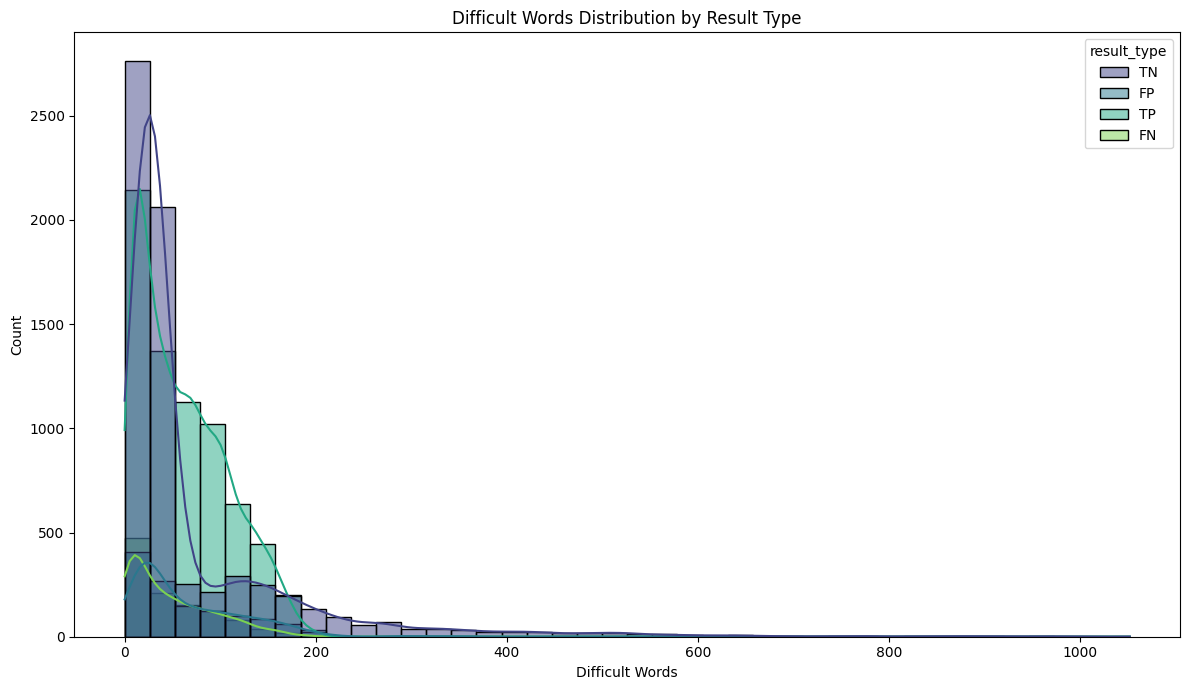


--- Analyzing Top Keywords ---

Top 20 Keywords for Correct Predictions:
   Keyword  Frequency
0     said      13261
1   people      12706
2      new      11645
3     time       9793
4     like       9178
5     just       8915
6     make       7141
7      way       6047
8      use       5982
9    world       5422
10    know       5414
11   years       5217
12    work       4863
13    good       4850
14    dont       4660
15    want       4632
16   going       4593
17    need       4567
18    used       4433
19   think       4408


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


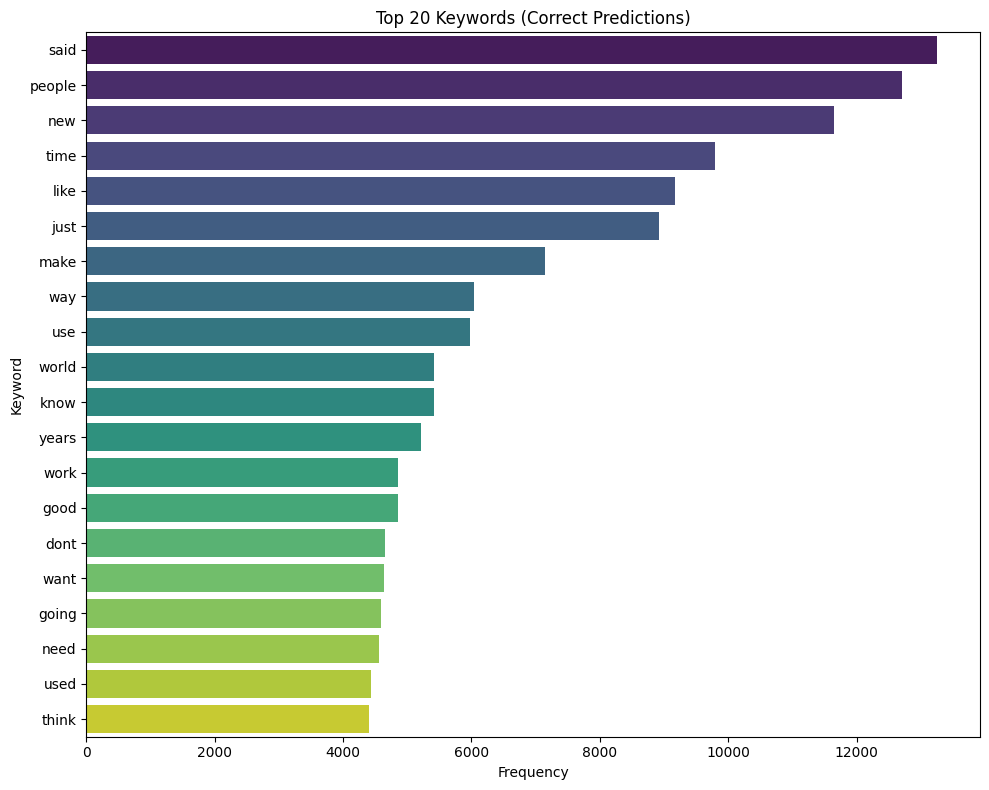


Top 20 Keywords for Incorrect Predictions:
   Keyword  Frequency
0     said       2196
1   people       1563
2      new       1558
3     time       1429
4     just       1421
5     like       1402
6     make        975
7      use        895
8    years        840
9     dont        829
10     way        824
11    know        803
12   world        748
13    year        727
14    want        676
15    good        656
16   going        653
17   think        638
18    need        625
19    used        606


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


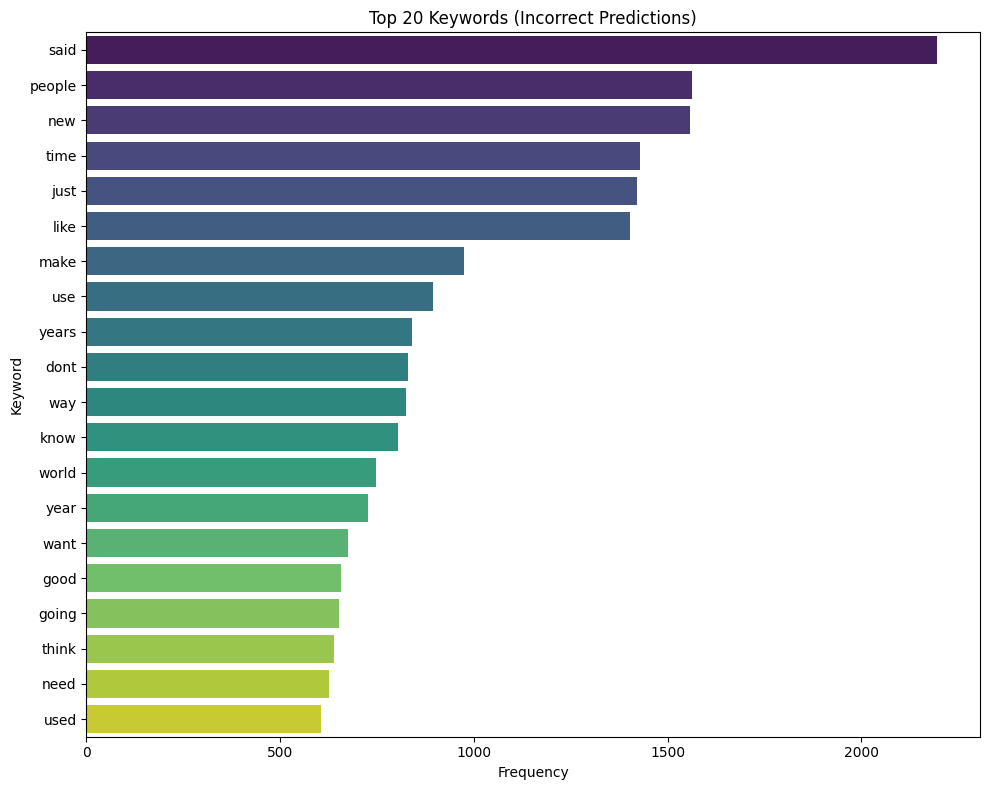


Top 20 Keywords for True Negatives:
      Keyword  Frequency
0      people       5328
1        time       4808
2        like       4382
3        just       4051
4         new       3757
5        said       3315
6     company       2900
7       world       2843
8         way       2708
9        life       2680
10        use       2593
11       work       2433
12       know       2409
13       make       2350
14       used       2305
15  different       2281
16      years       2277
17        man       2086
18        did       2062
19   business       2061


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


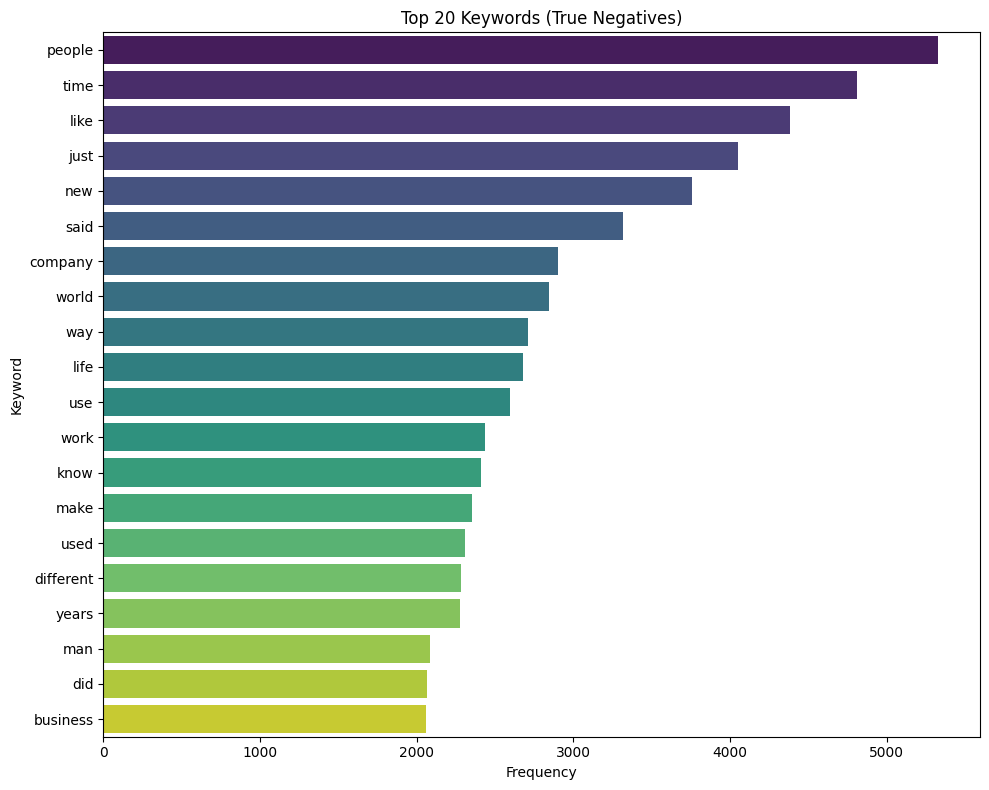


Top 20 Keywords for False Positives:
       Keyword  Frequency
0         said       1265
1       people        961
2          new        915
3         like        756
4         time        753
5         just        725
6         make        521
7         year        519
8          use        504
9        years        465
10         way        460
11       world        431
12        dont        415
13        want        392
14        good        382
15  government        375
16        know        367
17        need        348
18       think        340
19        work        337


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


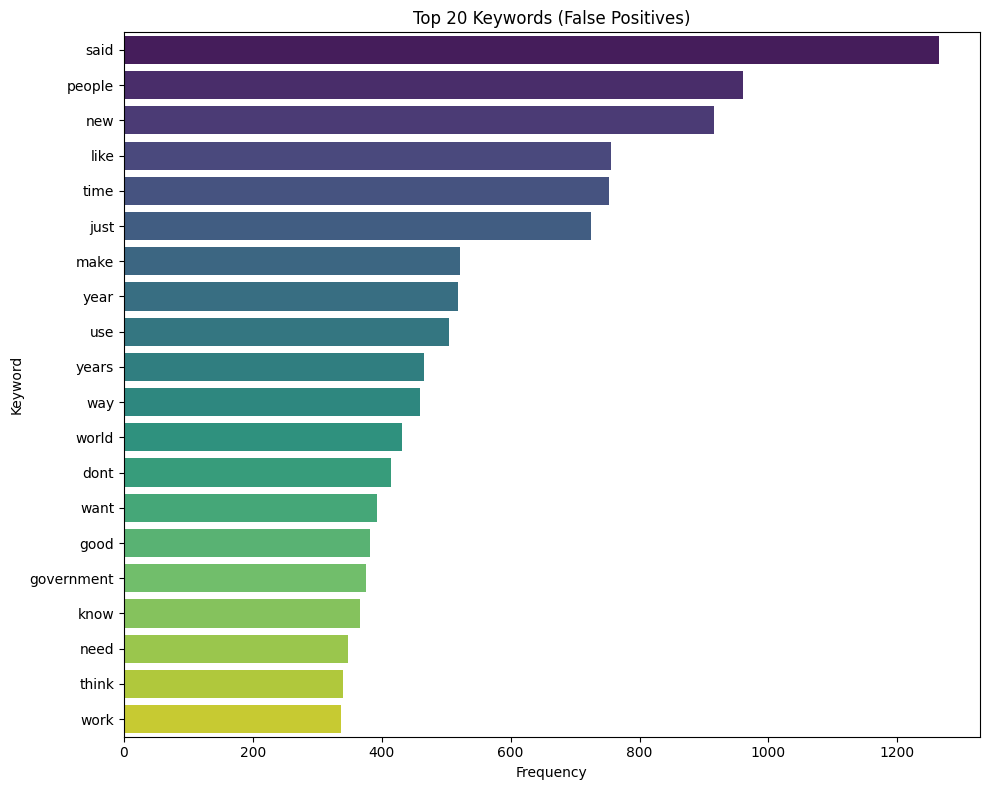


Top 20 Keywords for False Negatives:
   Keyword  Frequency
0     said        931
1     just        696
2     time        676
3     like        646
4      new        643
5   people        602
6     make        454
7     know        436
8     dont        414
9      use        391
10   years        375
11     way        364
12     man        324
13   going        322
14   right        317
15   world        317
16    used        301
17   think        298
18     did        288
19    want        284


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


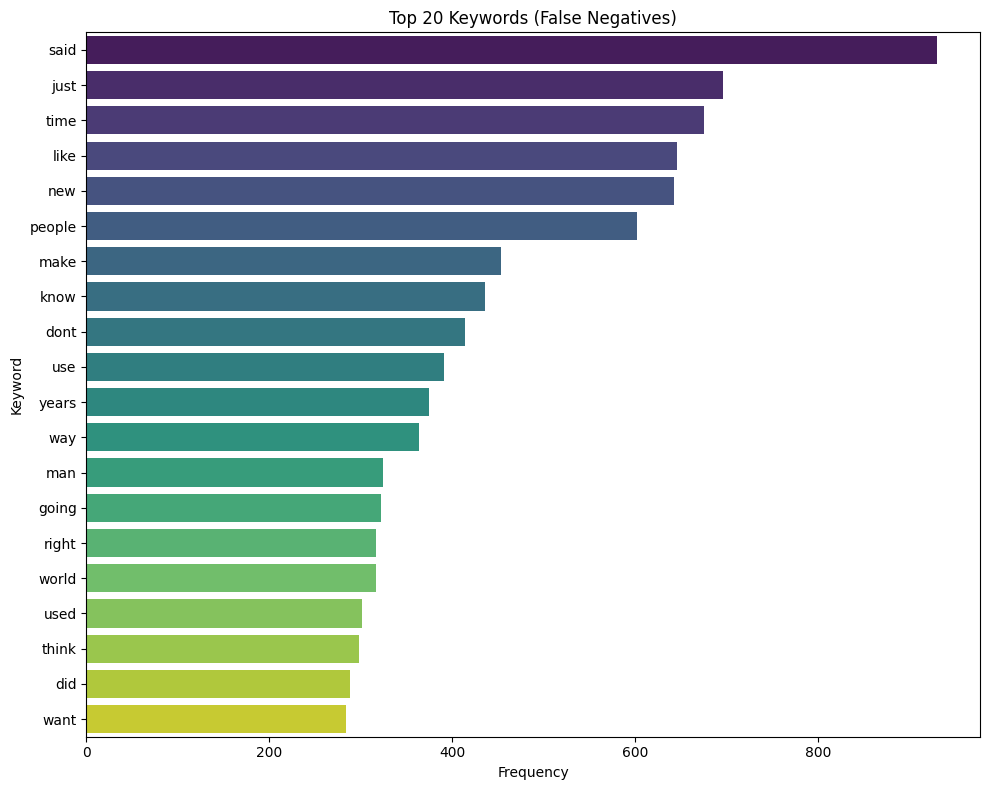


Top 20 Keywords for True Positives:
       Keyword  Frequency
0         said       9946
1          new       7888
2       people       7378
3         time       4985
4         just       4864
5         like       4796
6         make       4791
7         want       3491
8          use       3389
9          way       3339
10       going       3193
11        dont       3113
12        know       3005
13        good       2993
14       think       2986
15       years       2940
16        year       2929
17        game       2840
18  government       2819
19        need       2751


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


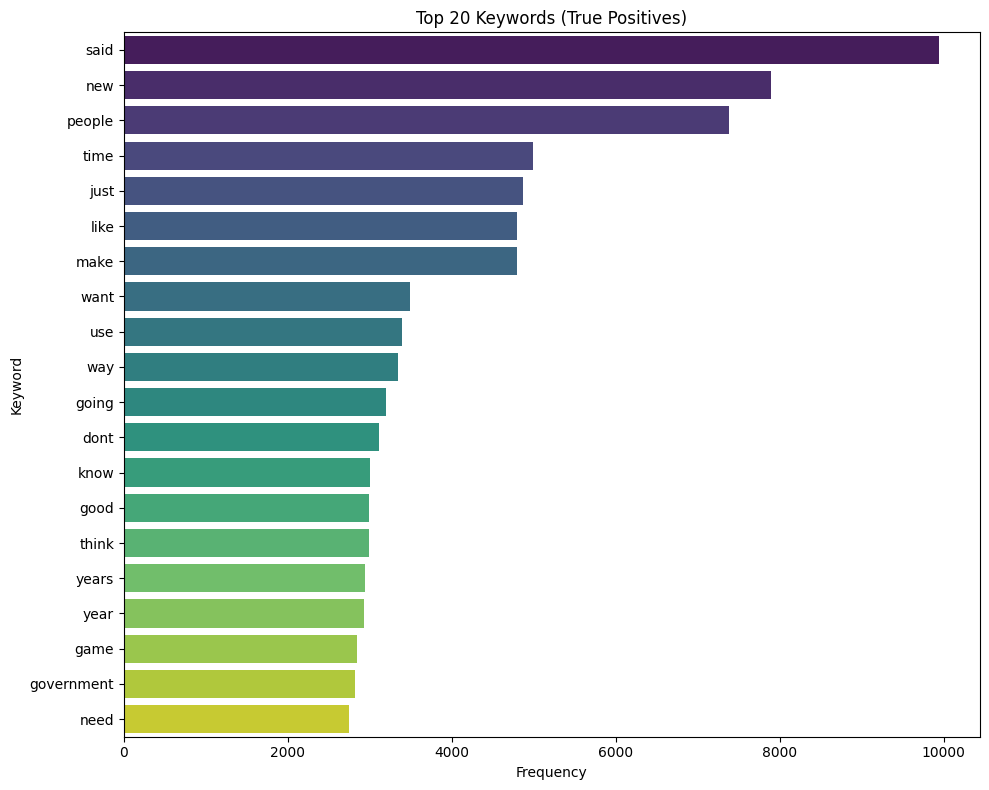


--- Analyzing N-grams ---

-- Top 2-grams --

Top 2-grams for Correct Predictions:
      2-gram  Frequency
0     of the      38256
1     in the      31779
2     to the      16358
3     on the      12707
4    and the      10370
5      to be       9963
6    for the       9508
7   that the       9029
8      it is       7974
9       in a       7782
10  with the       7666
11    at the       7128
12      is a       7051
13  from the       6605
14      of a       6330
15      as a       5835
16    by the       5752
17    it was       5539
18    is the       4861
19   this is       4585


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


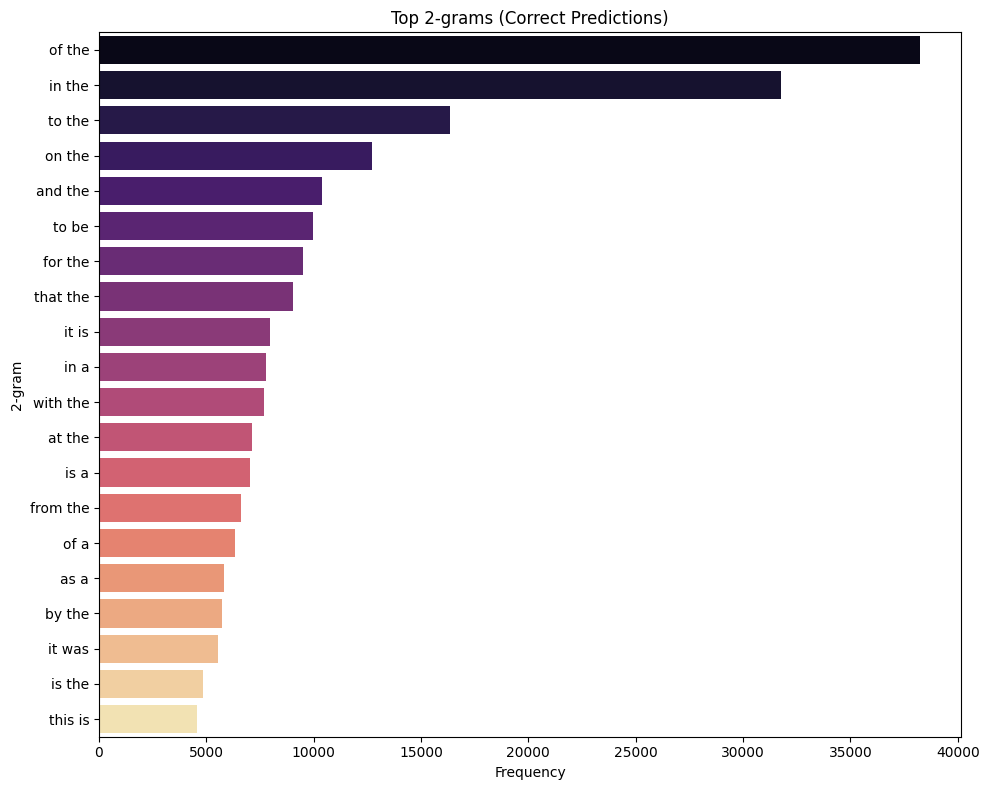


Top 2-grams for Incorrect Predictions:
      2-gram  Frequency
0     of the       5193
1     in the       4272
2     to the       2138
3     on the       1760
4    for the       1391
5    and the       1328
6      to be       1317
7     at the       1167
8   that the       1164
9       in a       1121
10      is a       1034
11  from the       1032
12  with the       1010
13     it is        931
14      of a        893
15      as a        808
16    by the        795
17    it was        761
18   will be        729
19    with a        707


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


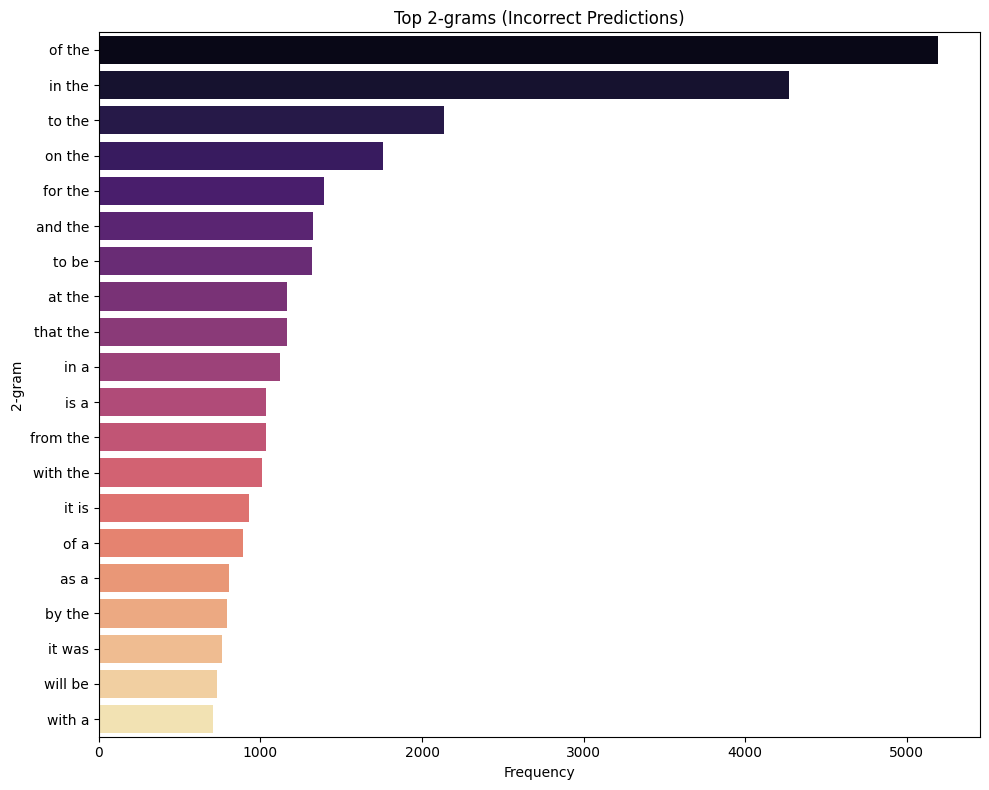

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


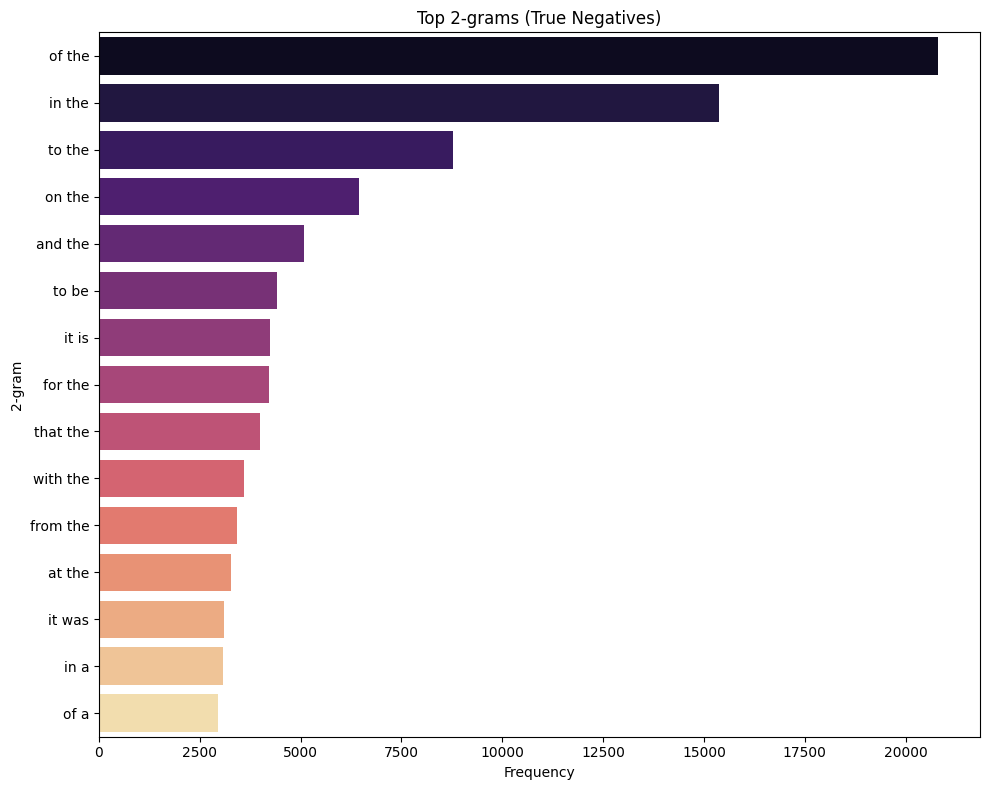

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


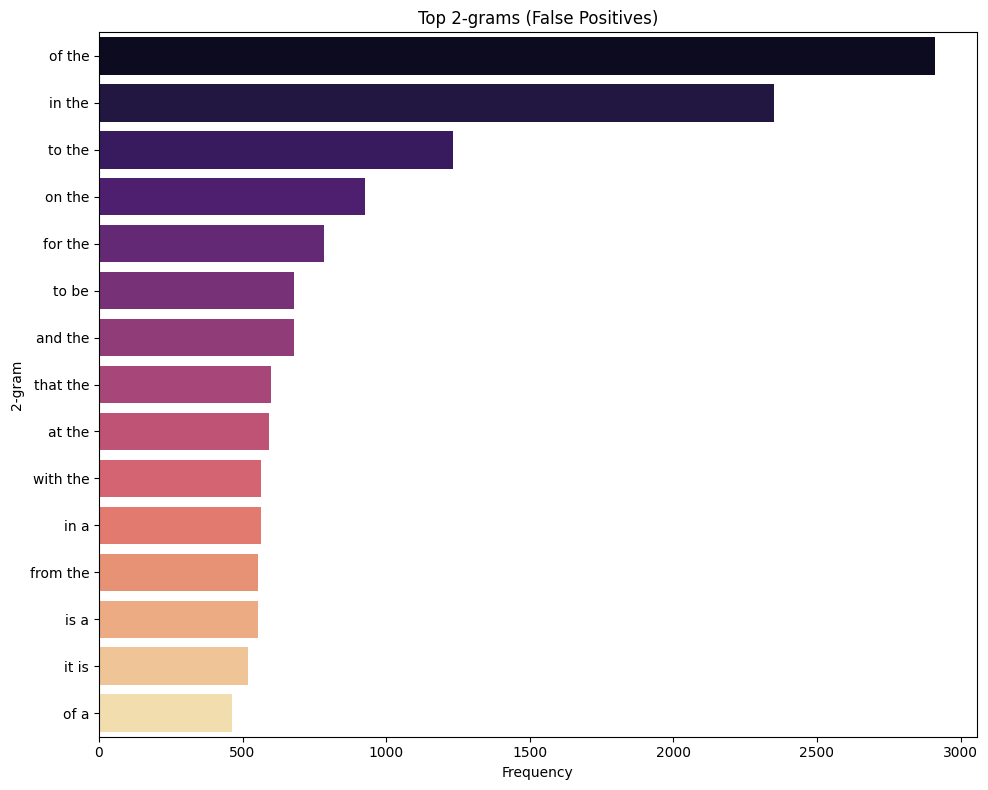

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


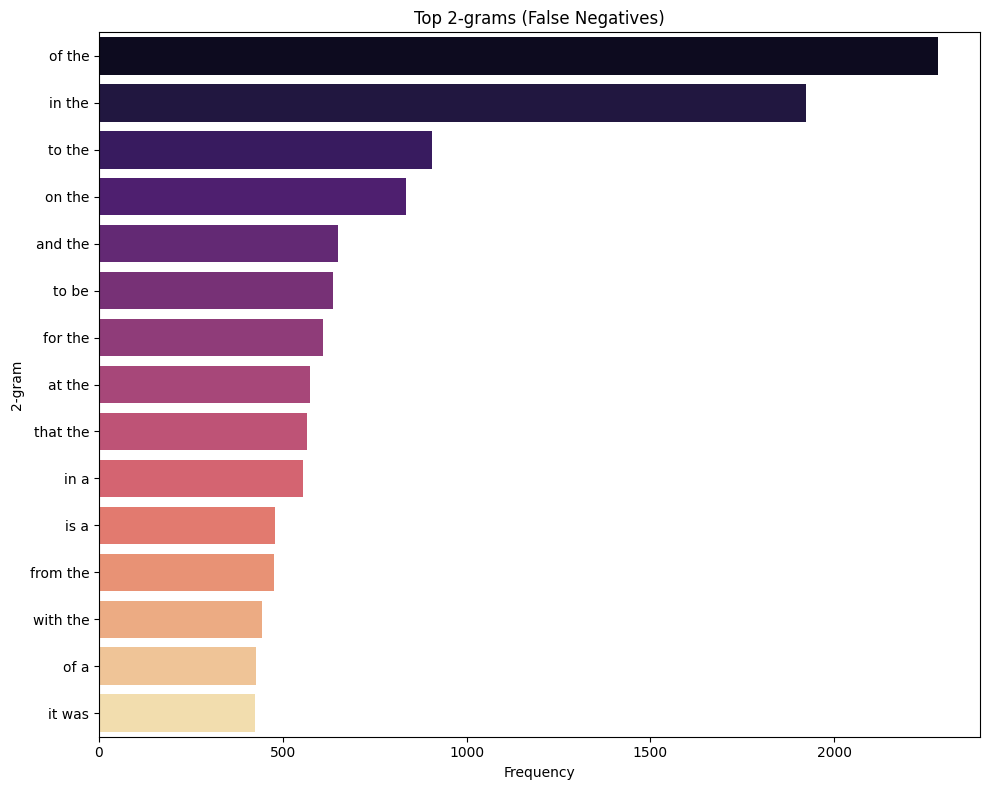

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


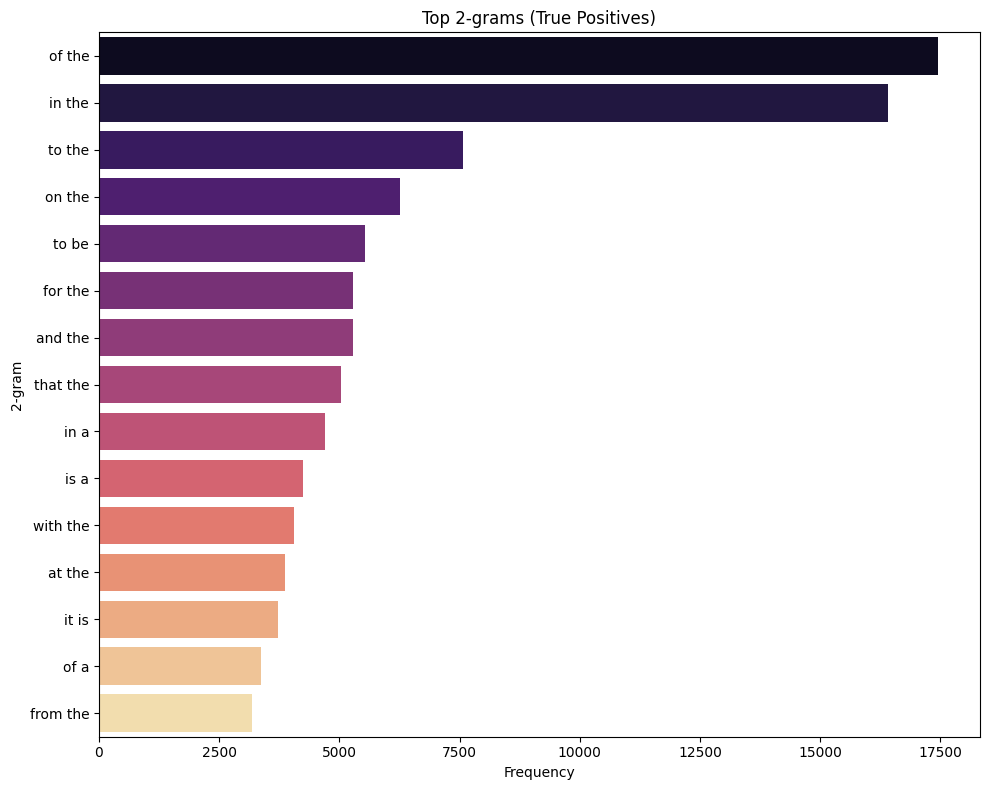


-- Top 3-grams --

Top 3-grams for Correct Predictions:
               3-gram  Frequency
0          one of the       2822
1            a lot of       2248
2   the united states       2169
3          as well as       1859
4         in order to       1442
5          be able to       1415
6       the fact that       1305
7         some of the       1192
8    according to the       1150
9         a number of       1007
10            to be a       1002
11      the number of        956
12        part of the        894
13         there is a        892
14         the use of        868
15        as a result        824
16         the end of        805
17      in the united        805
18          this is a        798
19       in the world        786


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


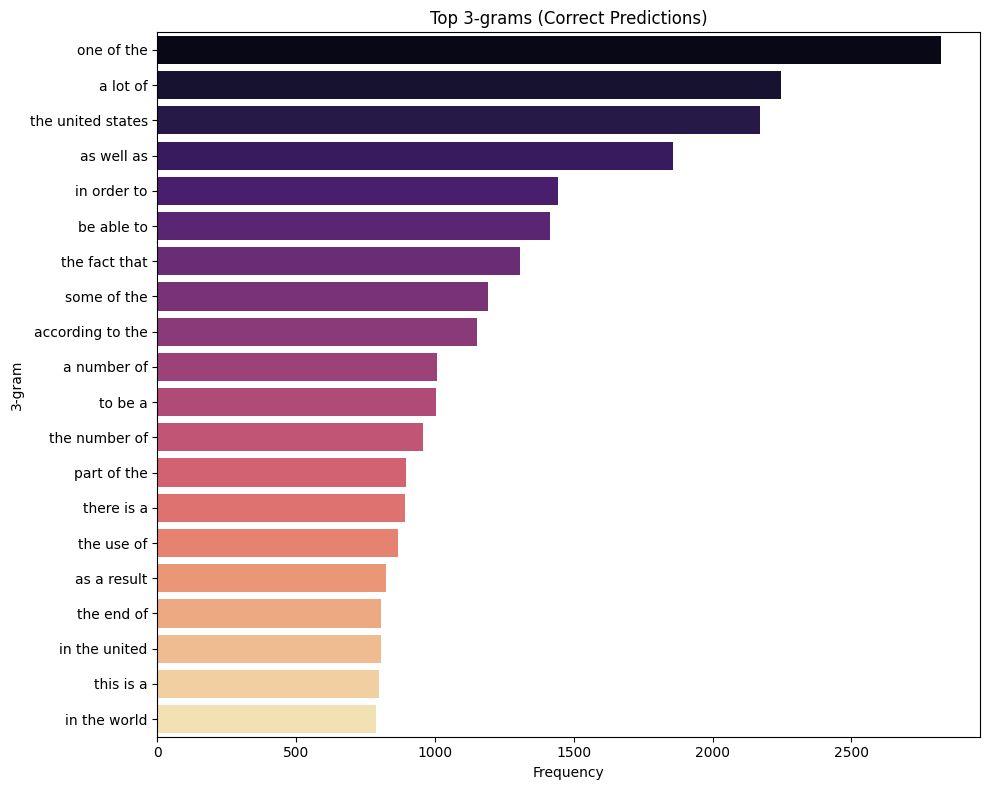


Top 3-grams for Incorrect Predictions:
               3-gram  Frequency
0          one of the        366
1            a lot of        269
2   the united states        231
3          as well as        222
4          be able to        194
5    according to the        177
6         part of the        160
7         some of the        156
8         in order to        151
9             to be a        141
10         the end of        141
11          this is a        131
12      the fact that        125
13         out of the        124
14        a number of        120
15       in the world        115
16     the first time        108
17        you want to        104
18         there is a        103
19        at the time        102


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


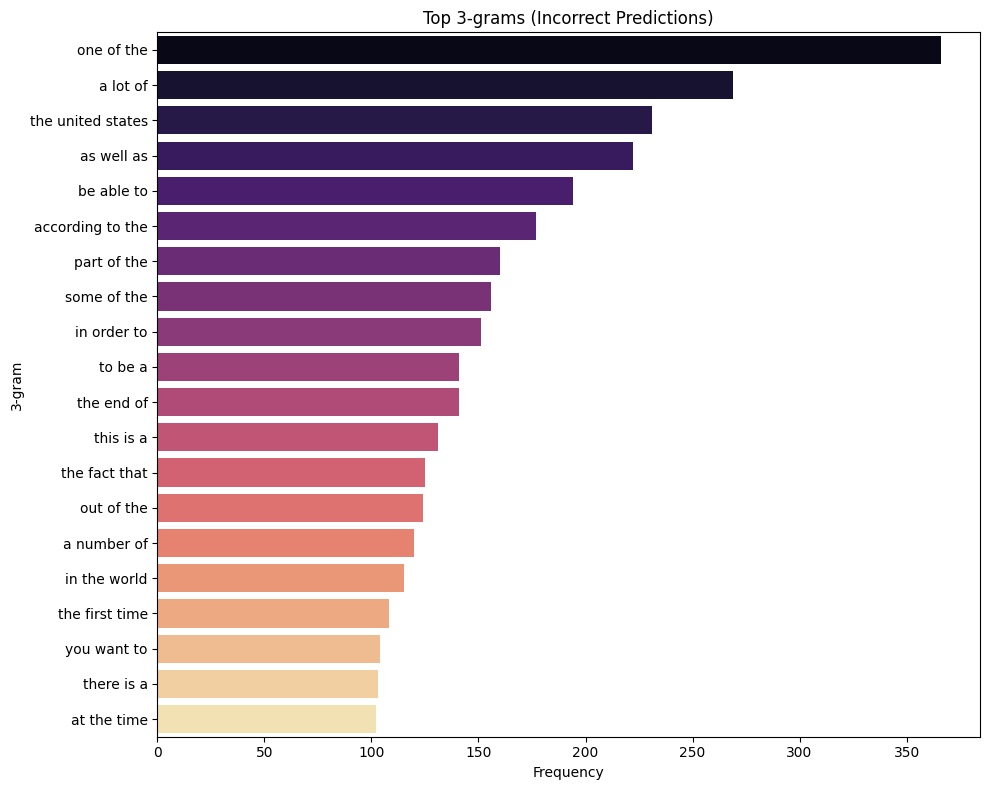

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


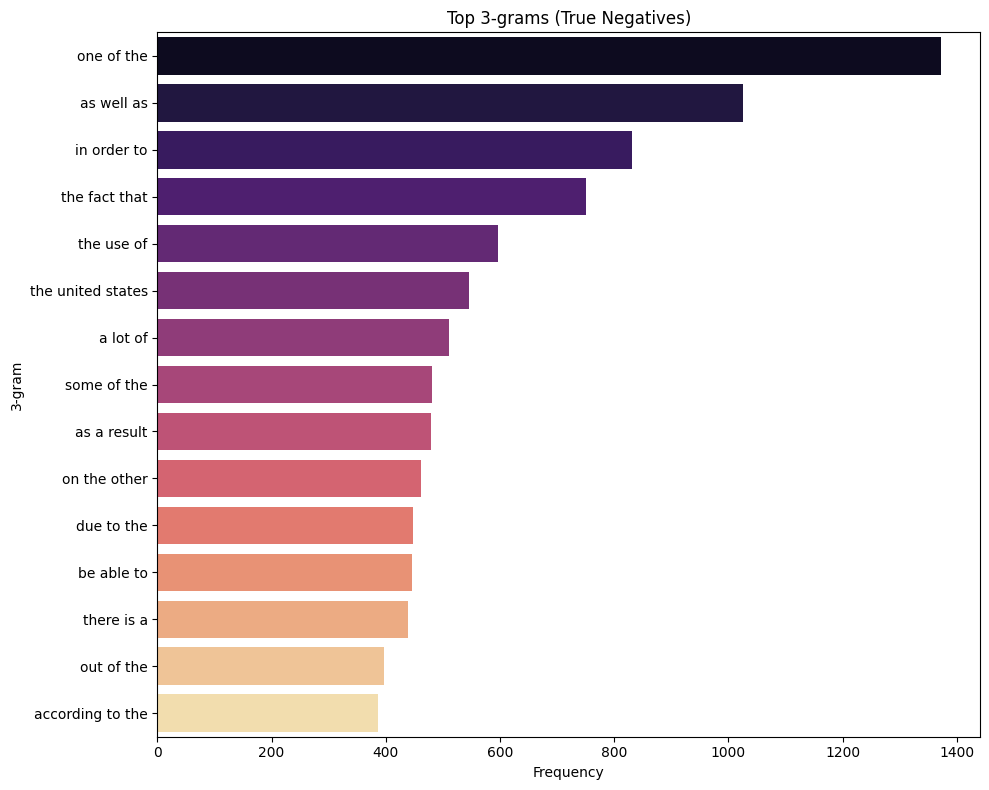

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


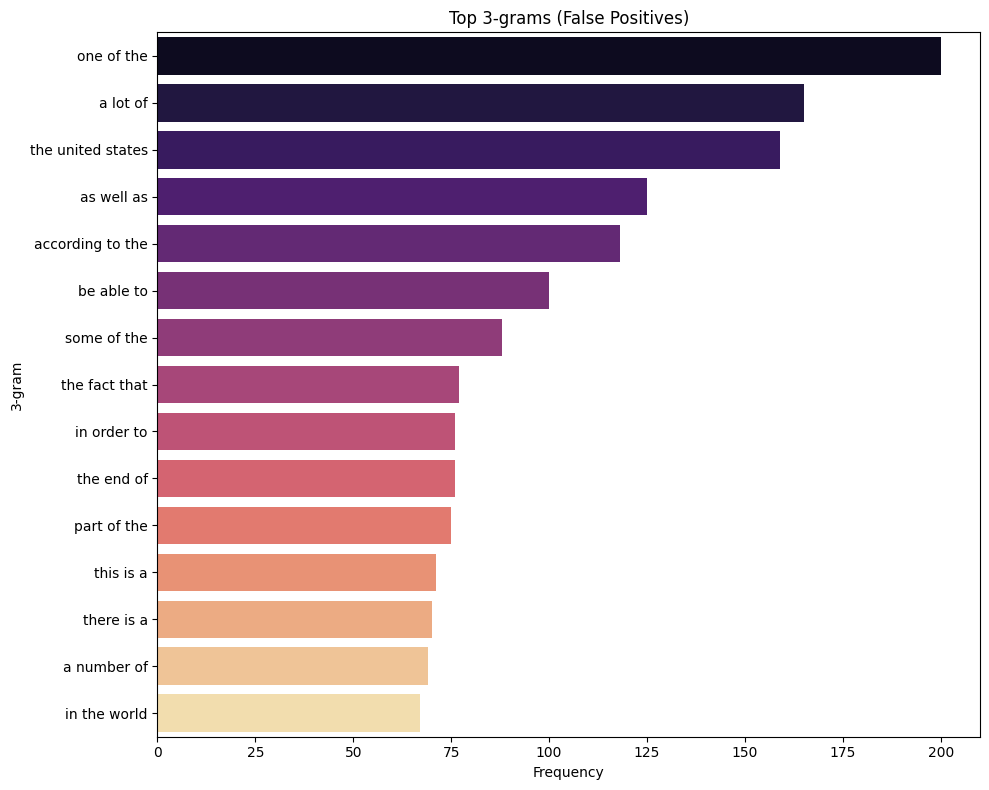

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


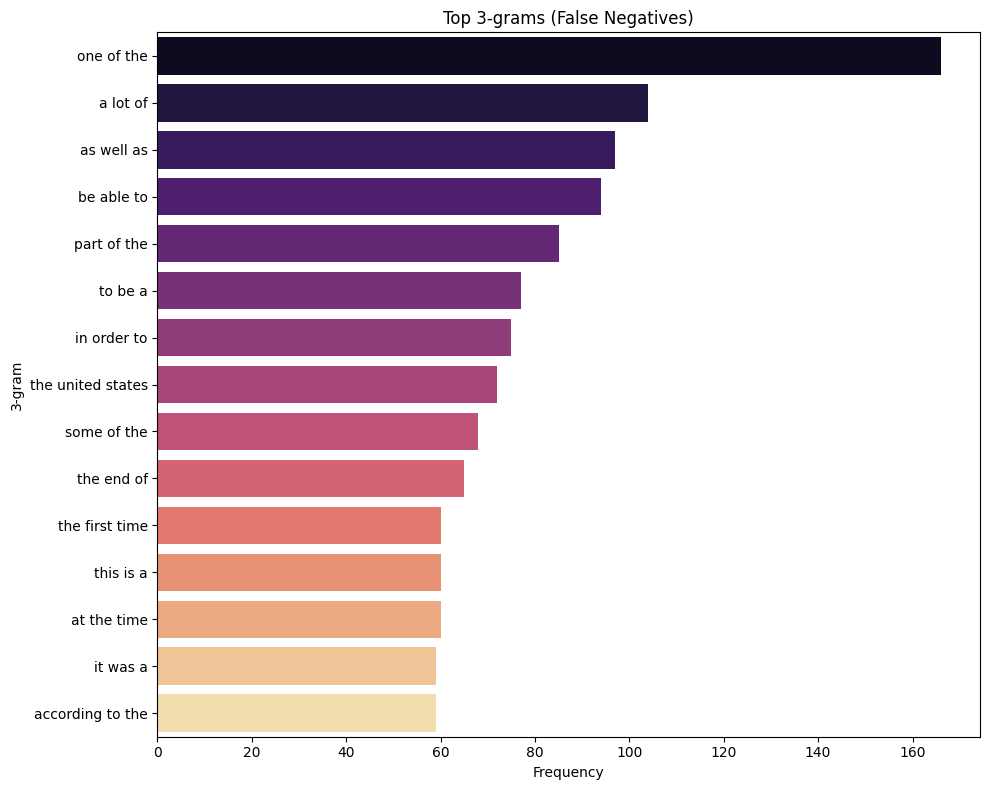

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


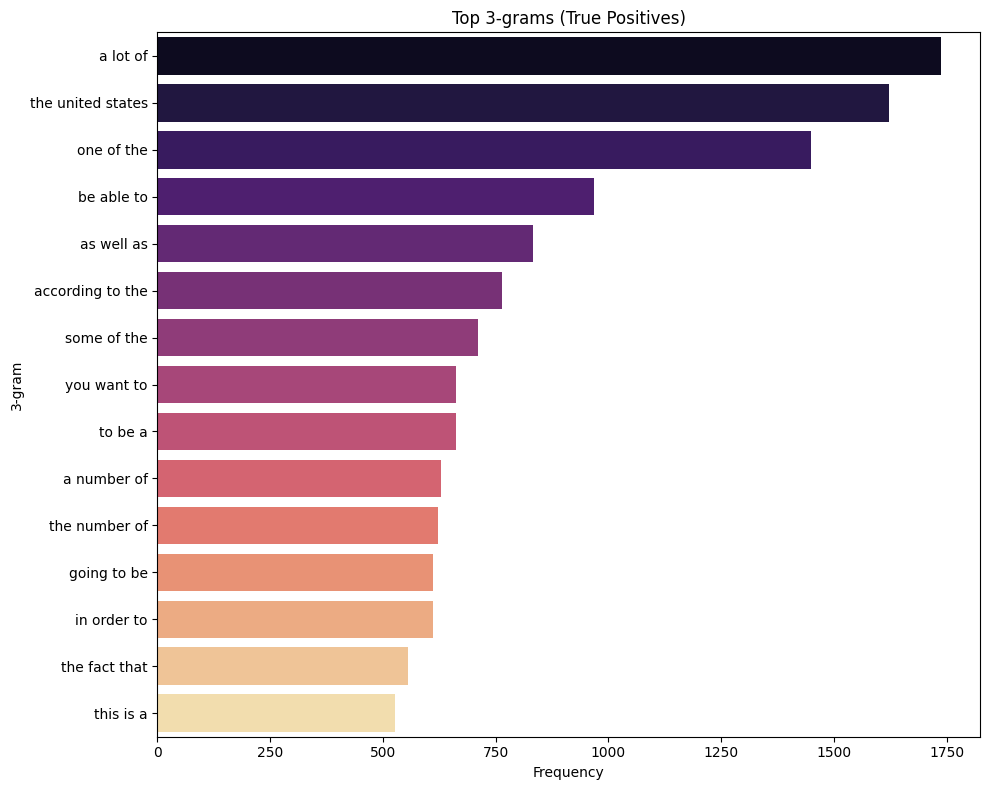


--- Analyzing Prediction Confidence ---


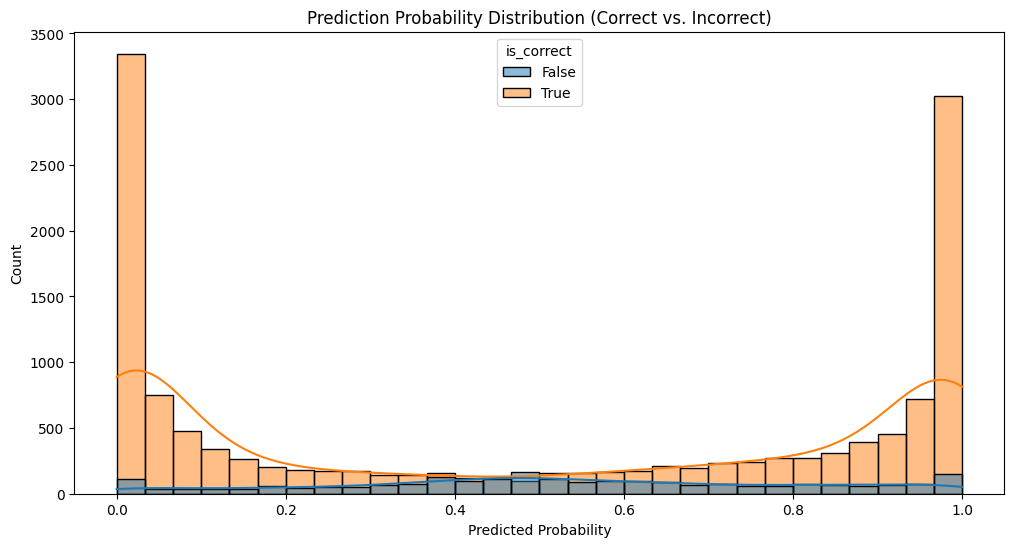


Average Prediction Probability:
is_correct
False    0.533863
True     0.497224
Name: pred_probability, dtype: float64

--- Analyzing Prediction Confidence by result type ---


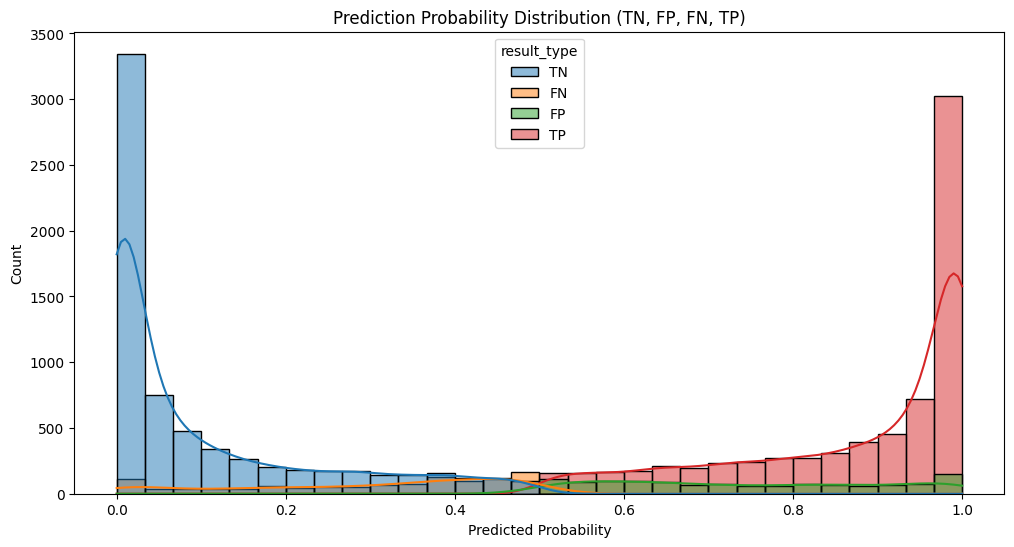


Average Prediction Probability:
result_type
FN    0.298350
FP    0.744435
TN    0.097685
TP    0.879868
Name: pred_probability, dtype: float64

--- Analyzing High-Confidence Errors Examples ---
Found 288 examples where the prediction was incorrect
but the model's confidence in the wrong prediction was > 0.90

--- Top 10 Most Confident Errors ---

--- Example Index: 9850 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 1.0000
  Text Snippet:     the history of the decade essay introduction the tragedy of the had a significant impact on the economical development of the united states as well as its role in the international relations ten years down the line the occurrences of that day are still fresh in peoples minds it is an incident that changed americas history and image within a relatively short period of time in the aftermath of the the united states had to face the challenges of the economical downturn war on terror oil crisis and ...
-------------------------

In [5]:
#### SGD Model Error Analysis(With Features)

print("\n" + "="*80)
print("Running SGD Model Error Analysis")
print("="*80)

for use_features in [True]:
    print(f"\nRunning SGD {'with' if use_features else 'without'} linguistic features")

    #Preprocess data
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = preprocess_data_sgd(
        use_linguistic_features=use_features,
        train_csv_path=train_path,
        val_csv_path=val_path,
        test_csv_path=test_path
    )

    #Train model
    model = train_sgd(X_train, y_train, use_features)

    val_results = evaluate_model_sgd(model, X_val, y_val, "Validation", use_features)
    val_df = pd.read_csv(val_path)
    val_df = val_df.dropna(subset=['text', 'label'])
    val_df['label'] = val_df['label'].astype(int)
    vectorizer = joblib.load("processed_data/sgd_vectorizer.joblib")

    #predict
    if use_features:
        scaler = joblib.load("processed_data/sgd_scaler.joblib")
        text_features = vectorizer.transform(val_df['text']).toarray()
        ling_features = scaler.transform(
            val_df['text'].apply(extract_linguistic_features_sgd).apply(pd.Series)
        )
        combined_features = np.hstack([text_features, ling_features])
        val_df['prediction'] = model.predict(combined_features)
        val_df['pred_probability'] = model.predict_proba(combined_features)[:, 1]
    else:
        text_features = vectorizer.transform(val_df['text']).toarray()
        val_df['prediction'] = model.predict(text_features)
        val_df['pred_probability'] = model.predict_proba(text_features)[:, 1]

    val_df['is_correct'] = val_df['label'] == val_df['prediction']
    val_df['result_type'] = val_df.apply(
        lambda x: 'TP' if x['label']==1 and x['is_correct'] else
                 ('TN' if x['label']==0 and x['is_correct'] else
                 ('FP' if x['label']==0 else 'FN')), axis=1)

    output_dir = os.path.join("results", f"sgd_{'with_features' if use_features else 'no_features'}")
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nRunning error analysis for SGD {'with' if use_features else 'without'} features")
    run_error_analysis(val_df, output_dir, use_features)


Running Naive Bayes Model Error Analysis

Running Naive Bayes without linguistic features

Training Naive Bayes model...
Training completed in 0.11 seconds

Validation Set Performance:
Accuracy: 0.7619
F1 Score: 0.7698
ROC AUC: 0.8228

Confusion Matrix:
[[5821 2097]
 [1713 6369]]


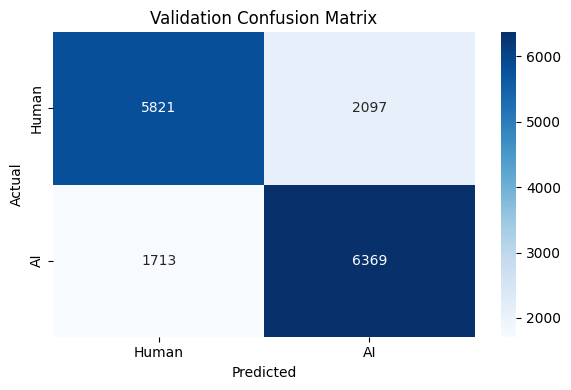


Running error analysis for Naive Bayes without features

--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
Correct Predictions:
 count    12190.000000
mean      2346.276948
std       3004.807188
min          9.000000
25%        896.000000
50%       1077.500000
75%       3414.000000
max      48723.000000
Name: text_length, dtype: float64

Incorrect Predictions:
 count     3810.000000
mean      1851.182152
std       1670.474720
min          5.000000
25%        608.000000
50%       1118.500000
75%       3086.000000
max      26340.000000
Name: text_length, dtype: float64

TN Predictions:
 count     5821.000000
mean      2456.622745
std       4007.984727
min         38.000000
25%        909.000000
50%        949.000000
75%       1698.000000
max      48723.000000
Name: text_length, dtype: float64

FP Predictions:
 count     2097.000000
mean      2036.380544
std       1701.498855
min         40.000000
25%        877.000000
50%       1398.000000
75%       3251.000000
max 

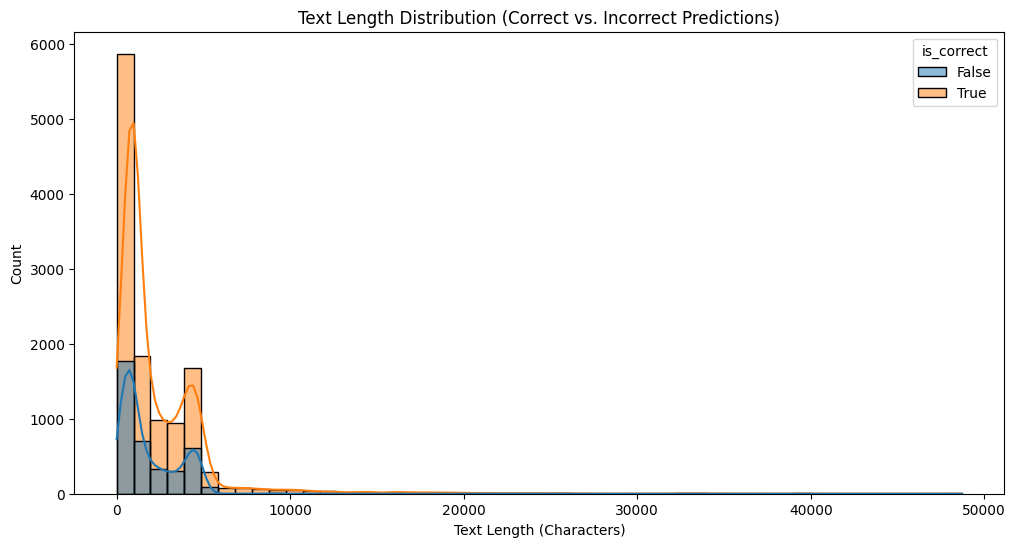

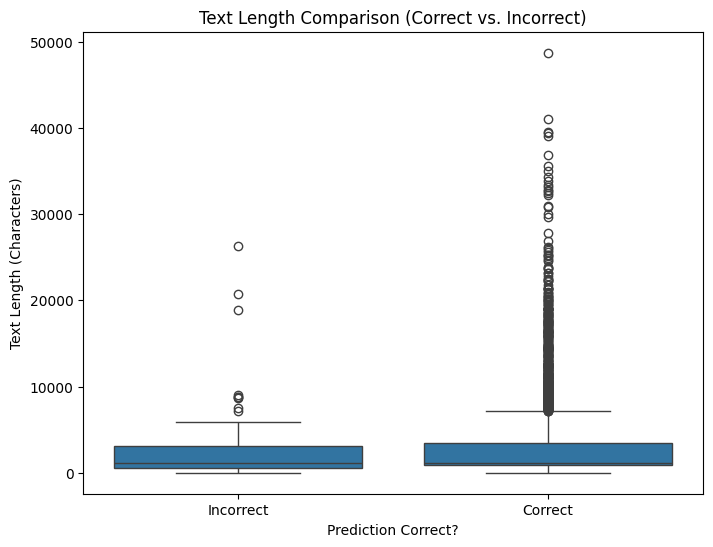

/content/error_analysis.py:182: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Result Type')


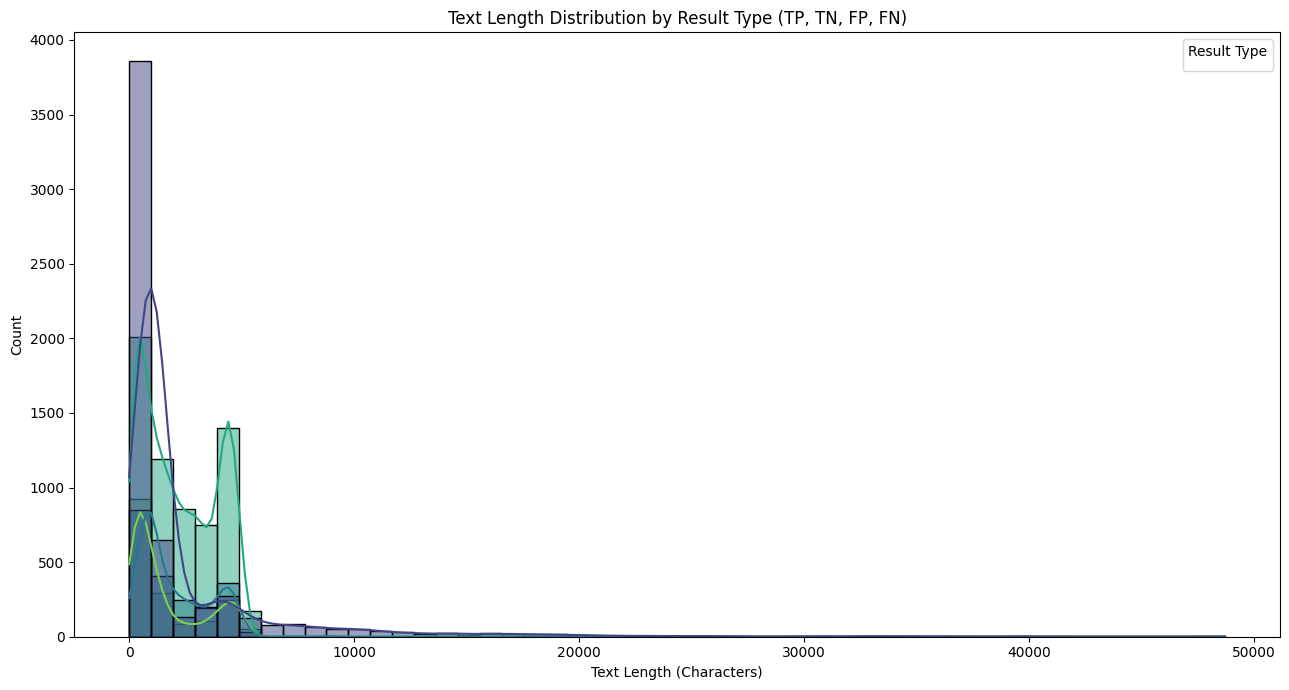

/content/error_analysis.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='result_type', y='text_length',


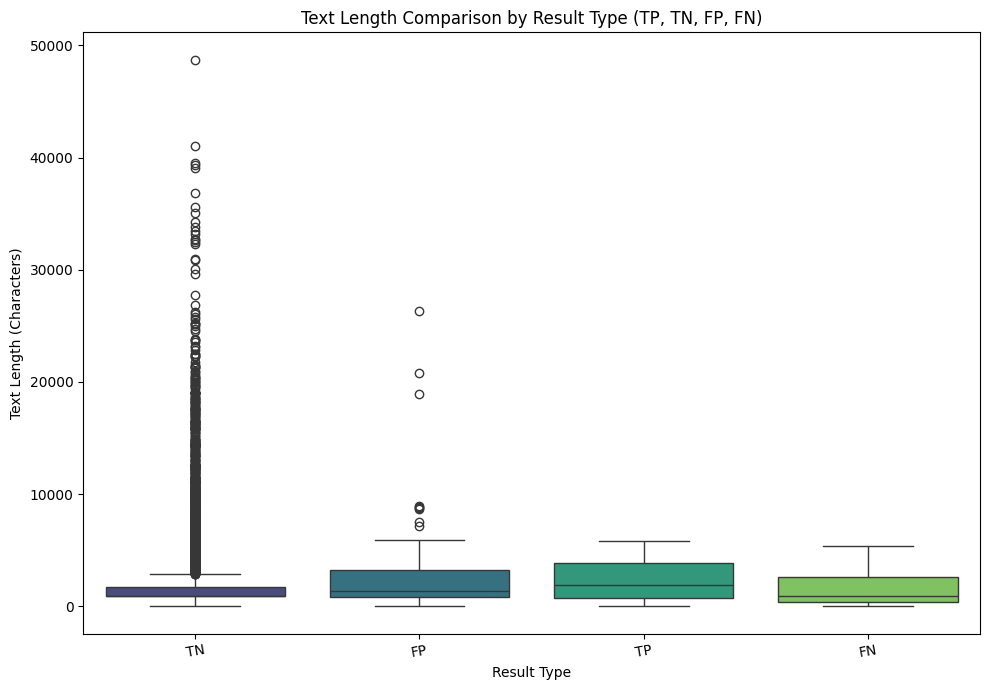


--- Analyzing Text Complexity ---


Calculating Complexity:   0%|          | 0/16000 [00:00<?, ?it/s]


Average Complexity Scores:
            difficult_words
is_correct                 
False             59.193701
True              67.352420


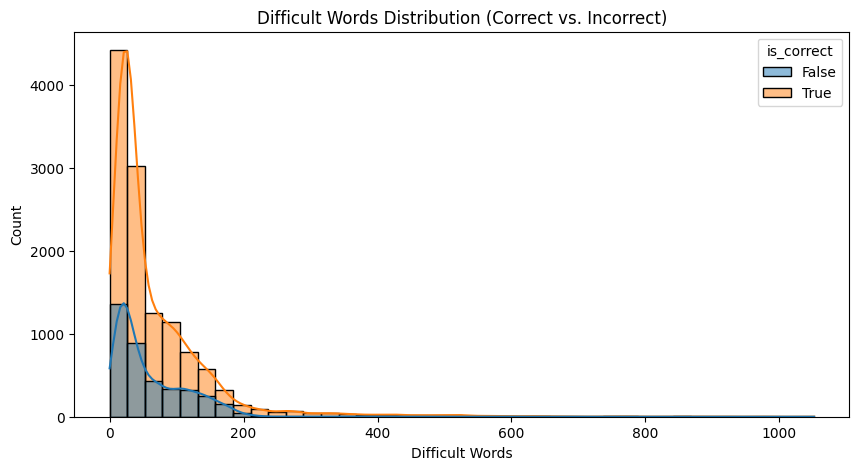


--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---

Descriptive Statistics for Complexity Metrics by Result Type:

--- Difficult Words ---
              count       mean         std  min   25%   50%    75%     max
result_type                                                               
TN           5821.0  72.565710  111.717682  0.0  21.0  28.0   50.0  1052.0
FP           2097.0  67.823557   57.150910  0.0  24.0  48.0  106.0   684.0
TP           6369.0  62.587690   45.778102  0.0  22.0  56.0   95.0   219.0
FN           1713.0  48.629305   45.026729  0.0  15.0  31.0   72.0   203.0


/content/error_analysis.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data_metric, x='result_type', y=metric, order=type_order, palette='viridis')


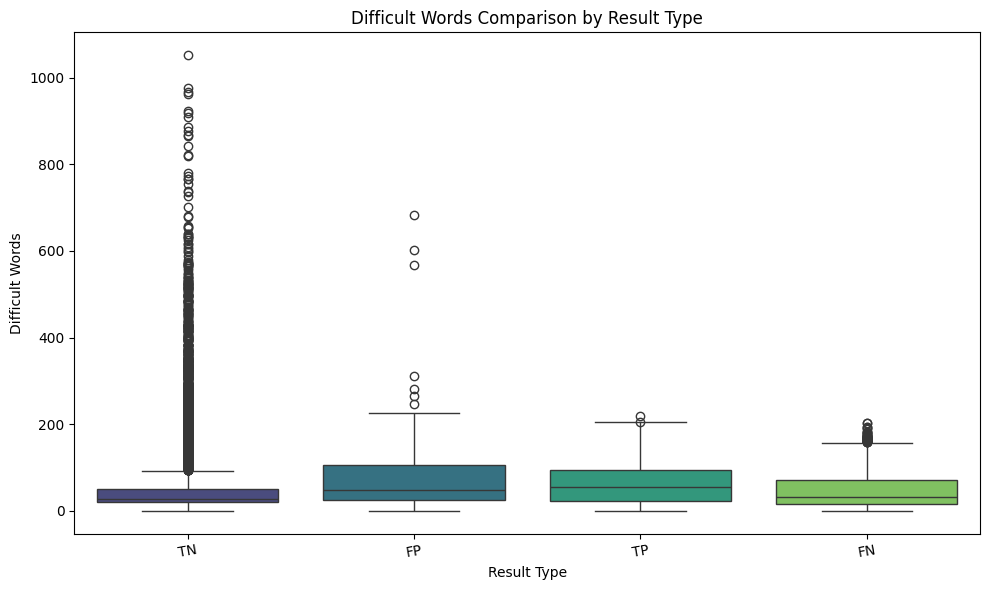

Could not generate legend for difficult_words histogram.


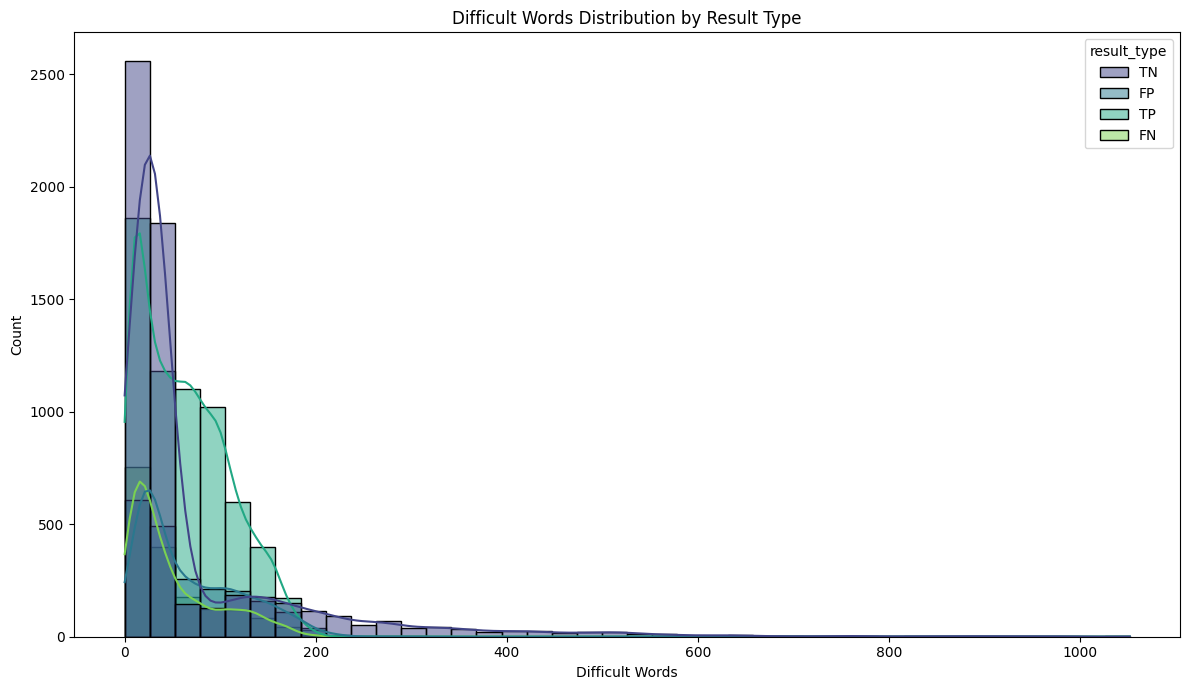


--- Analyzing Top Keywords ---

Top 20 Keywords for Correct Predictions:
   Keyword  Frequency
0     said      12391
1   people      11589
2      new      10847
3     time       8977
4     like       8490
5     just       8228
6     make       6611
7      way       5526
8      use       5442
9     know       5024
10   world       4992
11   years       4729
12    work       4508
13   going       4439
14    good       4428
15    want       4333
16    dont       4319
17    need       4233
18   think       4096
19    used       3985


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


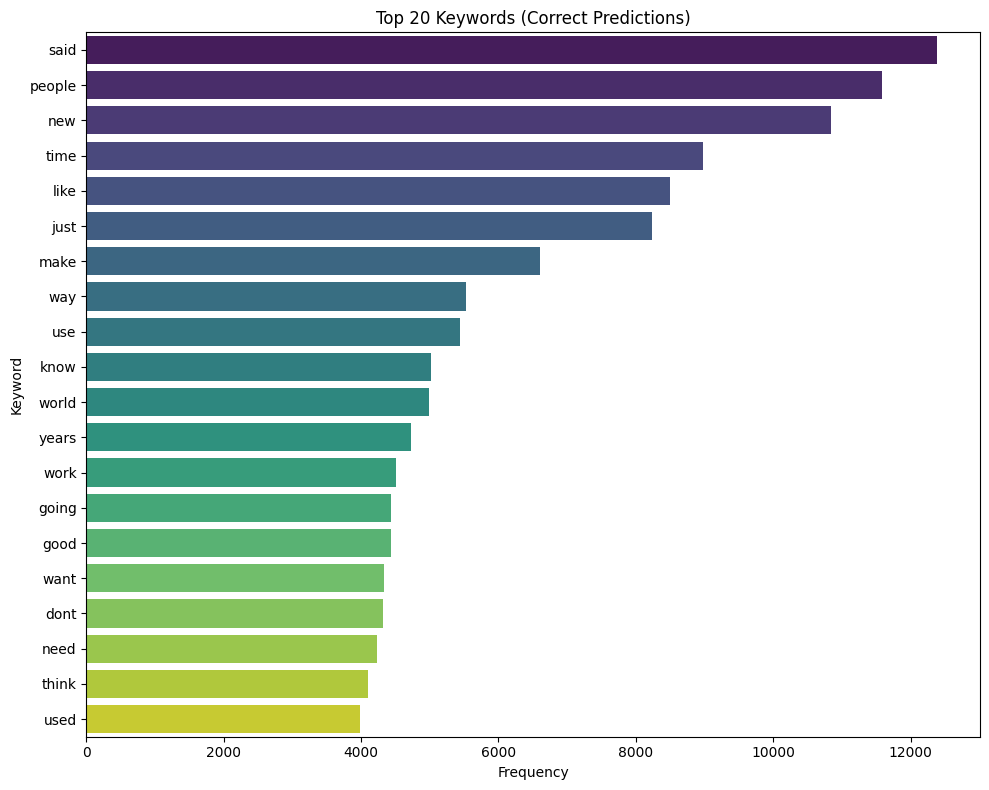


Top 20 Keywords for Incorrect Predictions:
   Keyword  Frequency
0     said       3066
1   people       2680
2      new       2356
3     time       2245
4     just       2108
5     like       2090
6     make       1505
7      use       1435
8      way       1345
9    years       1328
10    know       1193
11   world       1178
12    dont       1170
13    good       1078
14    used       1054
15    year       1051
16    want        975
17    help        973
18    need        959
19   think        950


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


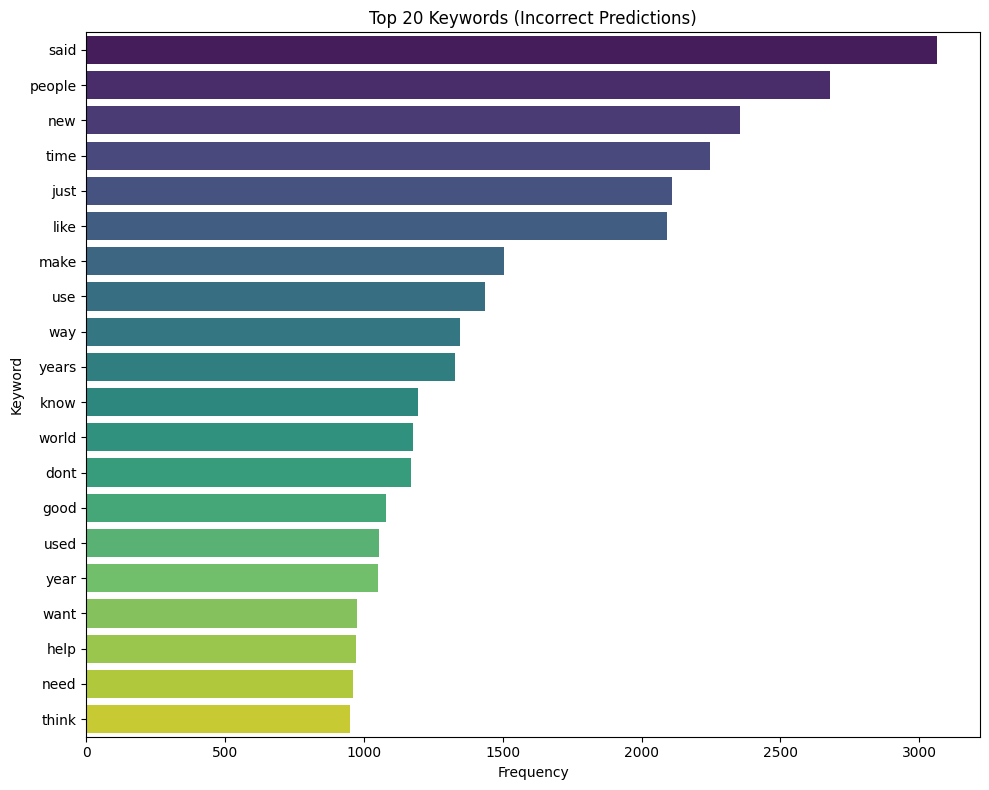


Top 20 Keywords for True Negatives:
       Keyword  Frequency
0       people       4799
1         time       4205
2         like       3735
3         just       3266
4          new       3202
5      company       2852
6        world       2666
7         life       2501
8          way       2454
9          use       2453
10        used       2236
11   different       2233
12        work       2223
13    business       2073
14        make       2036
15        said       2030
16  management       1959
17        know       1955
18       human       1931
19         man       1919


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


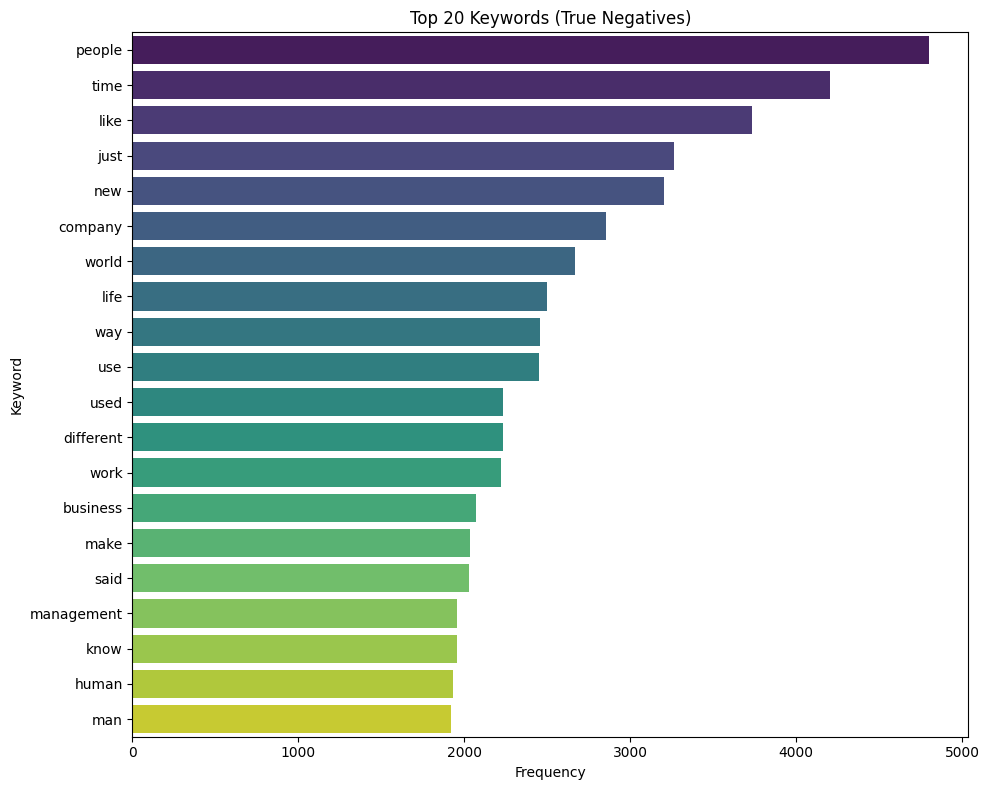


Top 20 Keywords for False Positives:
   Keyword  Frequency
0     said       2550
1     just       1510
2   people       1490
3      new       1470
4     like       1403
5     time       1356
6    years        915
7     dont        888
8     year        843
9     make        835
10    know        821
11     way        714
12    game        712
13  police        691
14    want        668
15   think        648
16     use        644
17   state        634
18    good        619
19      im        613


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


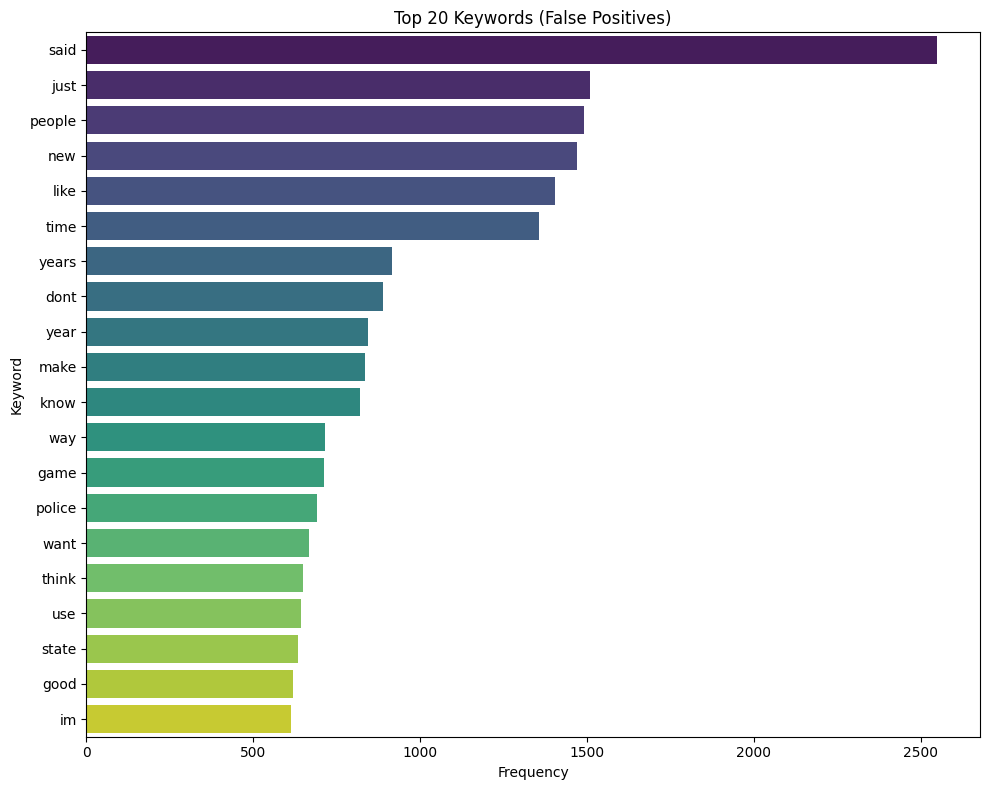


Top 20 Keywords for False Negatives:
      Keyword  Frequency
0      people       1190
1        time        889
2         new        886
3         use        791
4        like        687
5        used        680
6        make        670
7         way        631
8   different        604
9       study        599
10       just        598
11       help        593
12      world        570
13  important        569
14       said        516
15     health        509
16   research        471
17       good        459
18     number        433
19       life        433


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


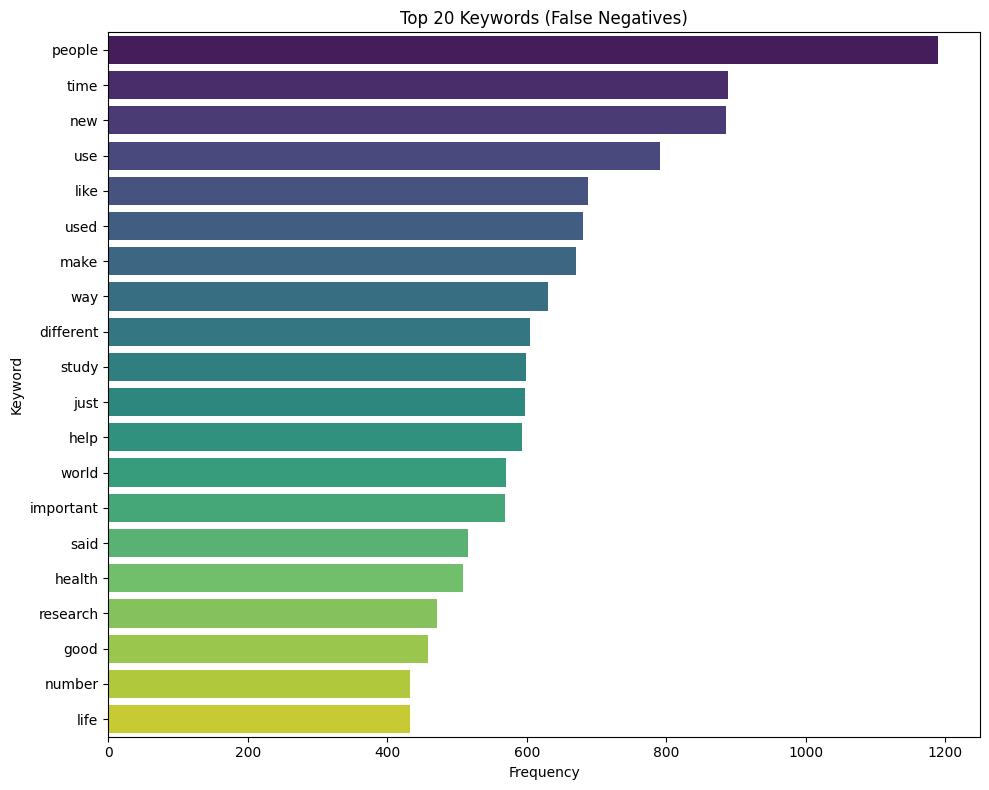


Top 20 Keywords for True Positives:
       Keyword  Frequency
0         said      10361
1          new       7645
2       people       6790
3         just       4962
4         time       4772
5         like       4755
6         make       4575
7         want       3468
8        going       3316
9         dont       3245
10         way       3072
11        know       3069
12        game       3018
13         use       2989
14       think       2982
15        year       2929
16       years       2902
17  government       2813
18        good       2808
19        need       2597


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


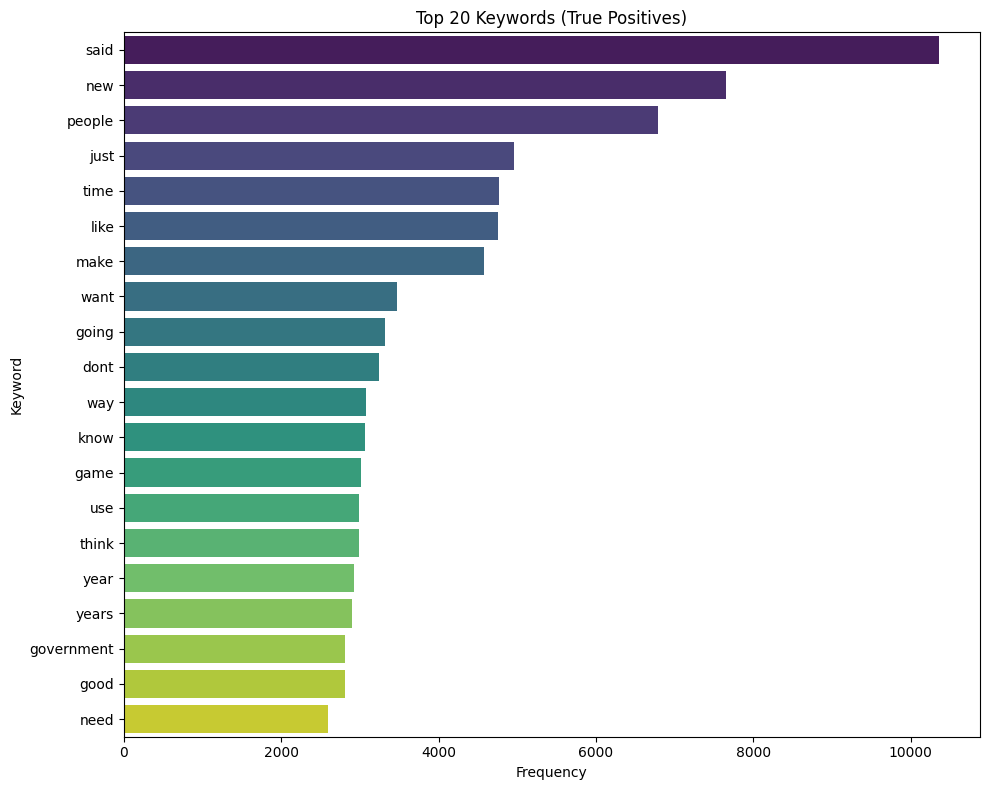


--- Analyzing N-grams ---

-- Top 2-grams --

Top 2-grams for Correct Predictions:
      2-gram  Frequency
0     of the      35574
1     in the      29384
2     to the      15283
3     on the      11926
4    and the       9531
5      to be       9246
6    for the       8864
7   that the       8480
8      it is       7307
9   with the       7186
10      in a       7029
11    at the       6601
12      is a       6327
13  from the       6182
14      of a       5765
15      as a       5424
16    by the       5326
17    it was       5296
18   will be       4456
19    is the       4387


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


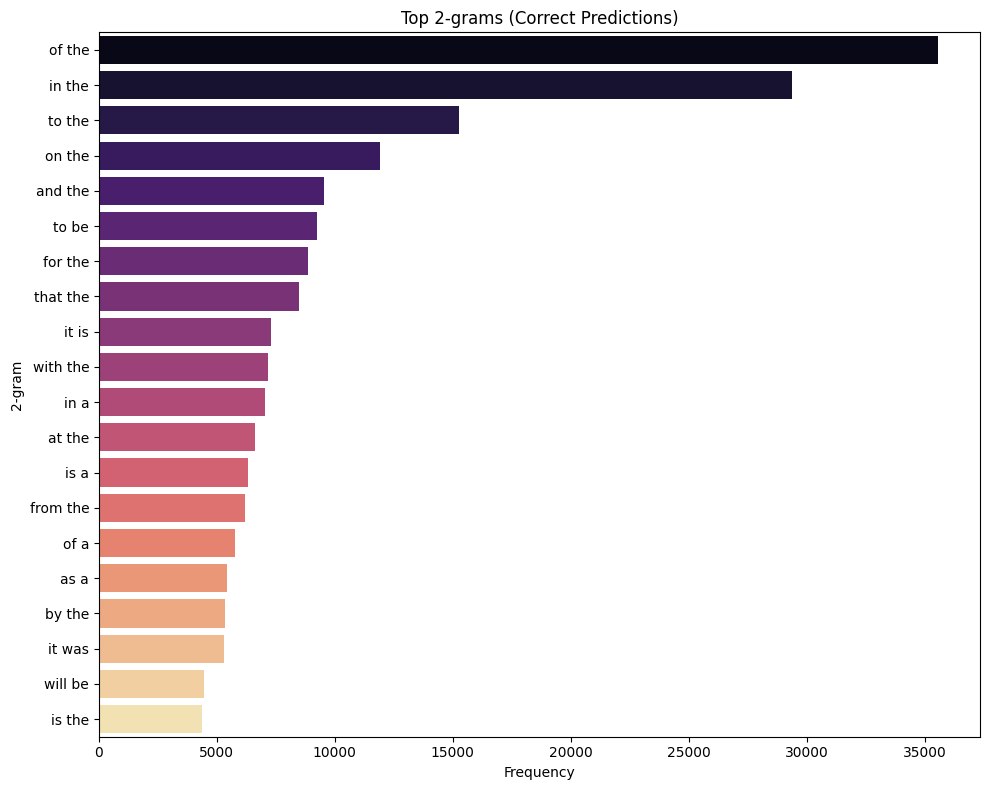


Top 2-grams for Incorrect Predictions:
      2-gram  Frequency
0     of the       7875
1     in the       6667
2     to the       3213
3     on the       2541
4    and the       2167
5    for the       2035
6      to be       2034
7       in a       1874
8       is a       1758
9   that the       1713
10    at the       1694
11     it is       1598
12  with the       1490
13      of a       1458
14  from the       1455
15    by the       1221
16      as a       1219
17    with a       1184
18    is the       1094
19    it was       1004


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


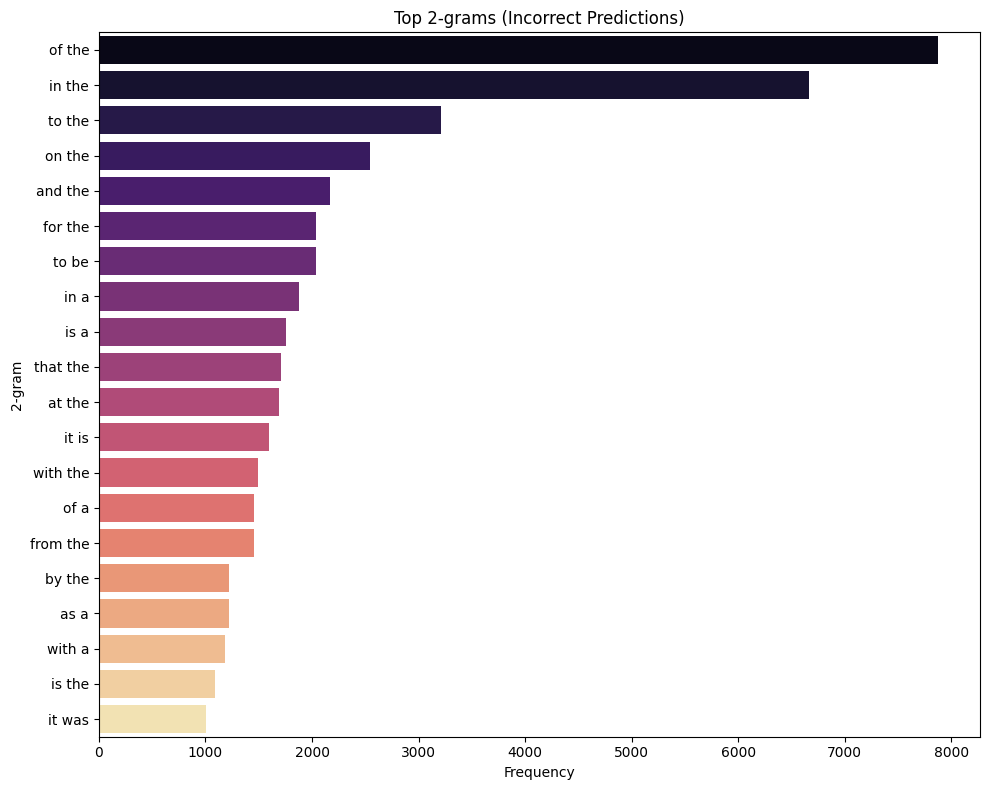

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


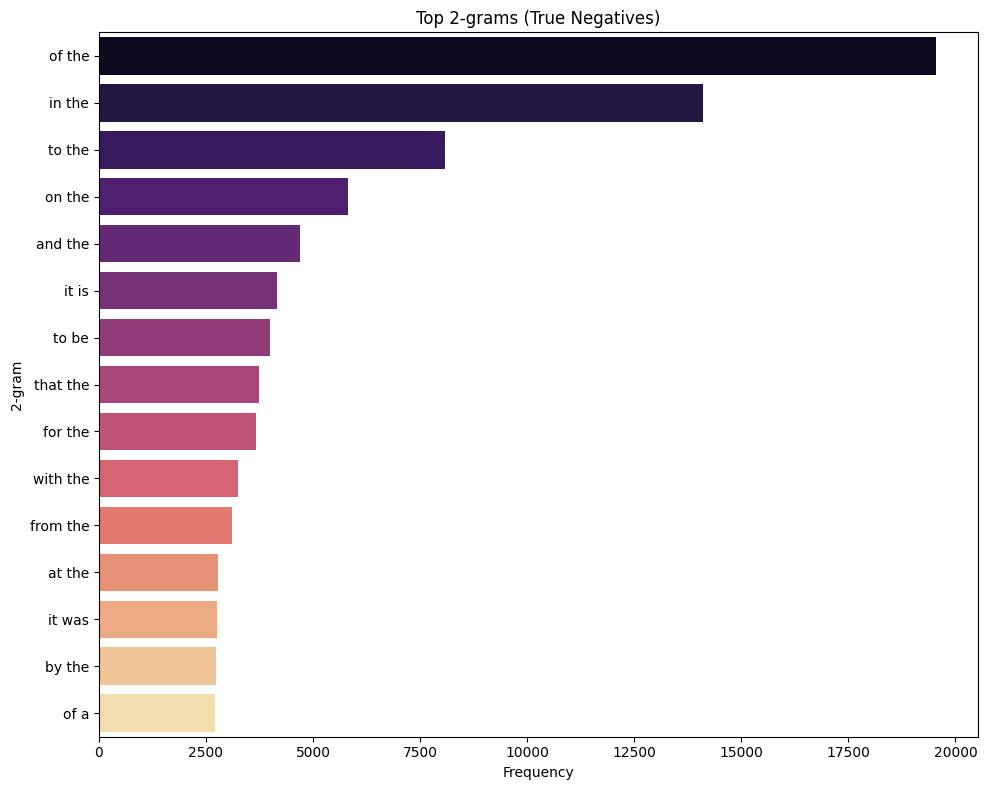

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


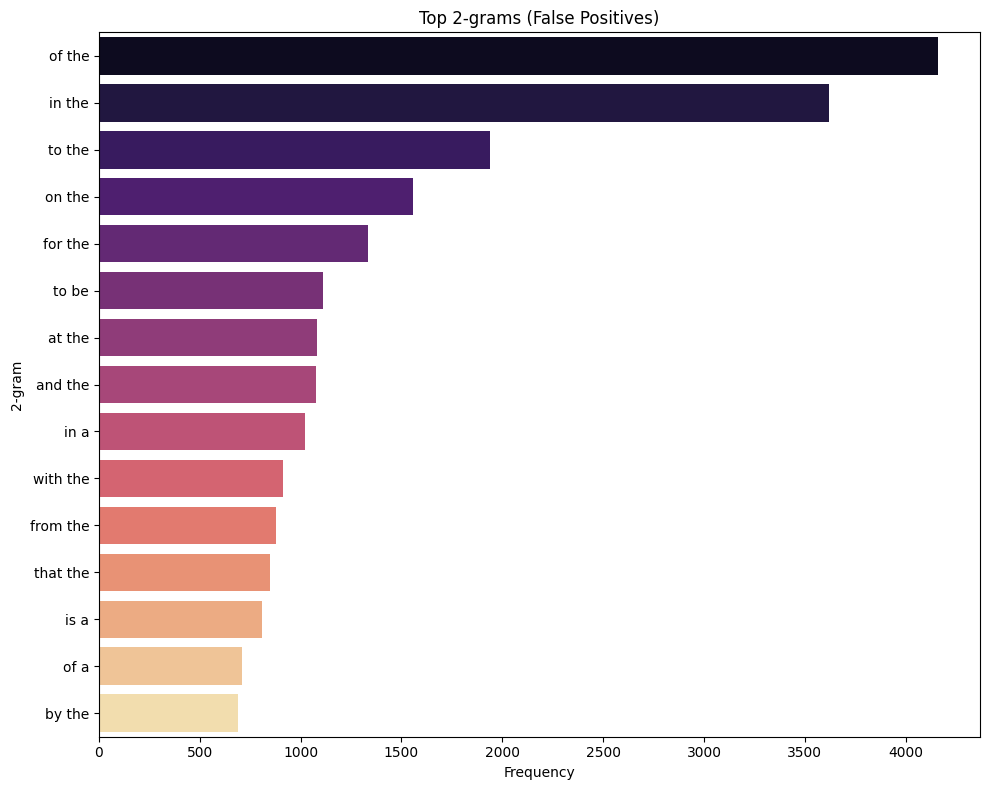

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


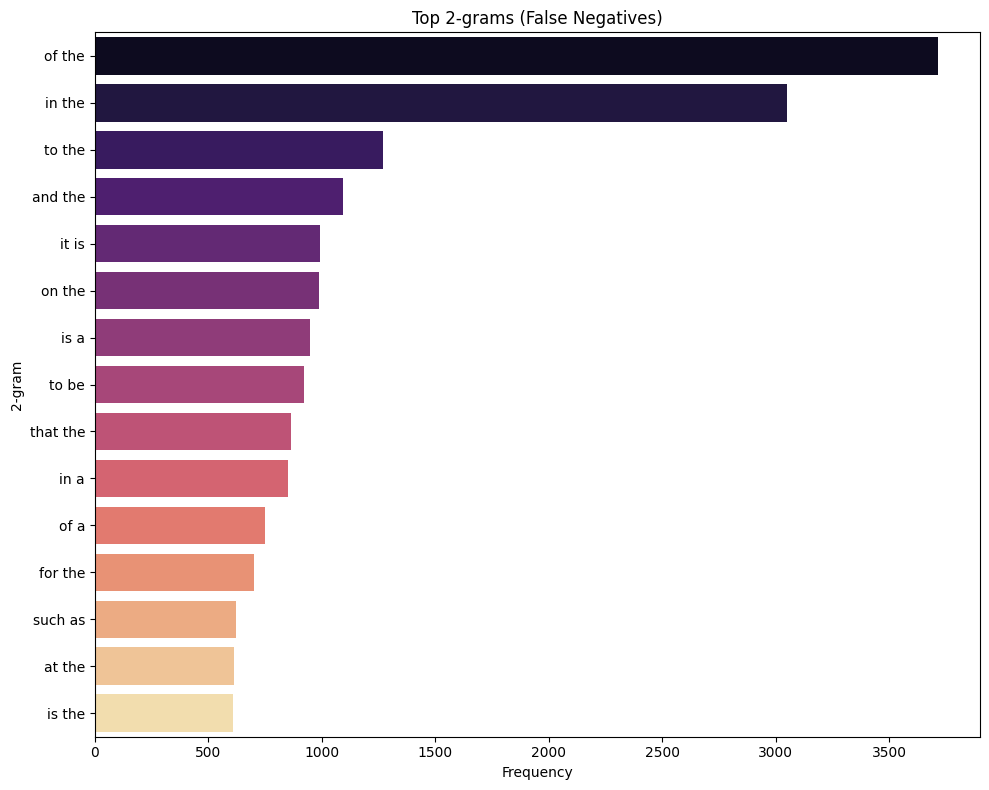

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


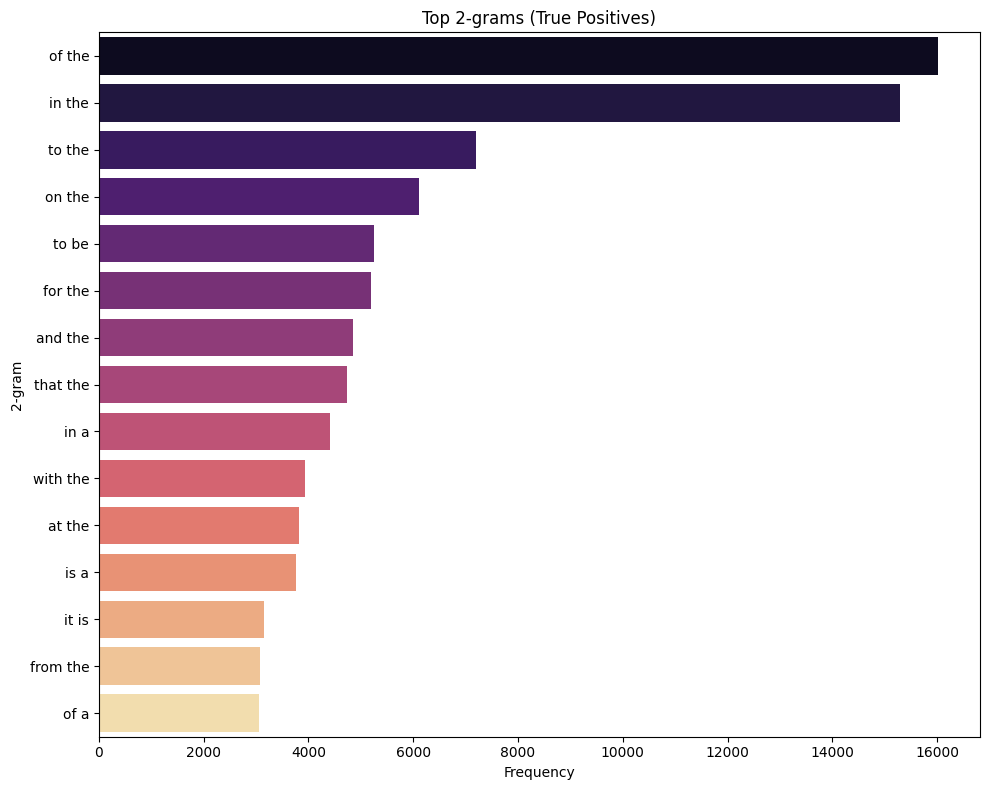


-- Top 3-grams --

Top 3-grams for Correct Predictions:
               3-gram  Frequency
0          one of the       2651
1            a lot of       2137
2   the united states       2061
3          as well as       1689
4         in order to       1362
5          be able to       1322
6       the fact that       1285
7         some of the       1118
8    according to the       1088
9             to be a        945
10        a number of        913
11      the number of        857
12        part of the        839
13         there is a        805
14         the use of        802
15        as a result        762
16         the end of        752
17       in the world        752
18          this is a        743
19        going to be        739


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


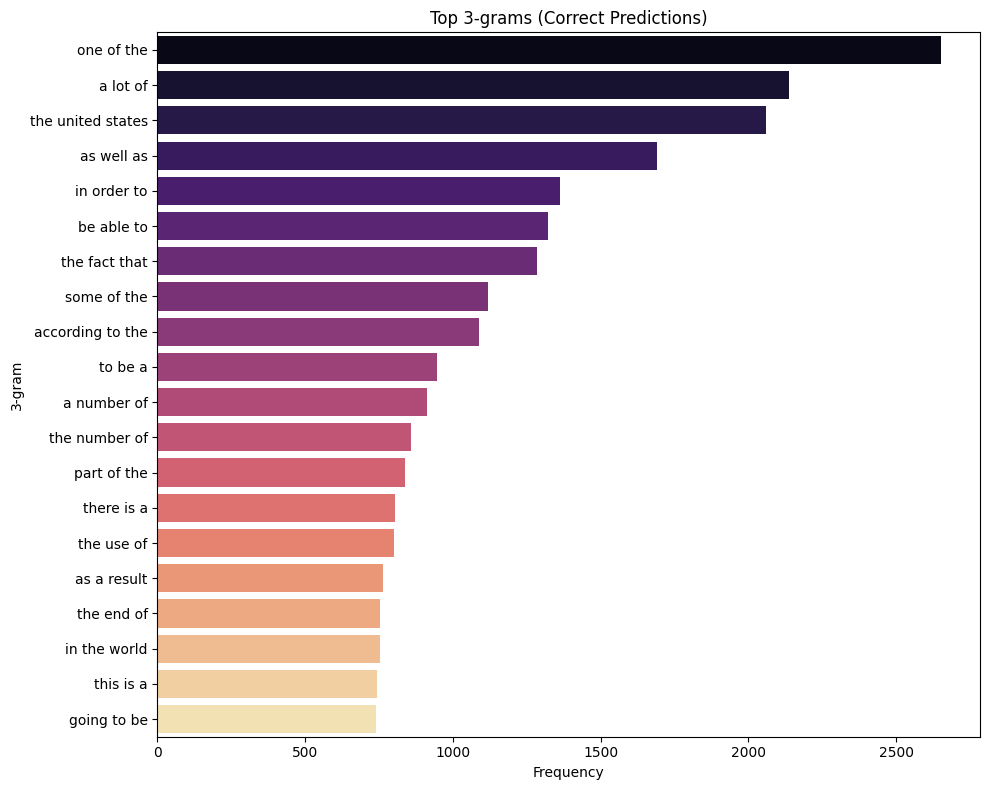


Top 3-grams for Incorrect Predictions:
               3-gram  Frequency
0          one of the        537
1          as well as        392
2            a lot of        380
3   the united states        339
4          be able to        287
5    according to the        239
6         in order to        231
7         some of the        230
8         part of the        215
9         a number of        214
10            to be a        198
11         the end of        194
12         there is a        190
13  the university of        188
14          this is a        186
15      the number of        184
16         out of the        181
17        you want to        161
18       a variety of        154
19        this is the        153


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


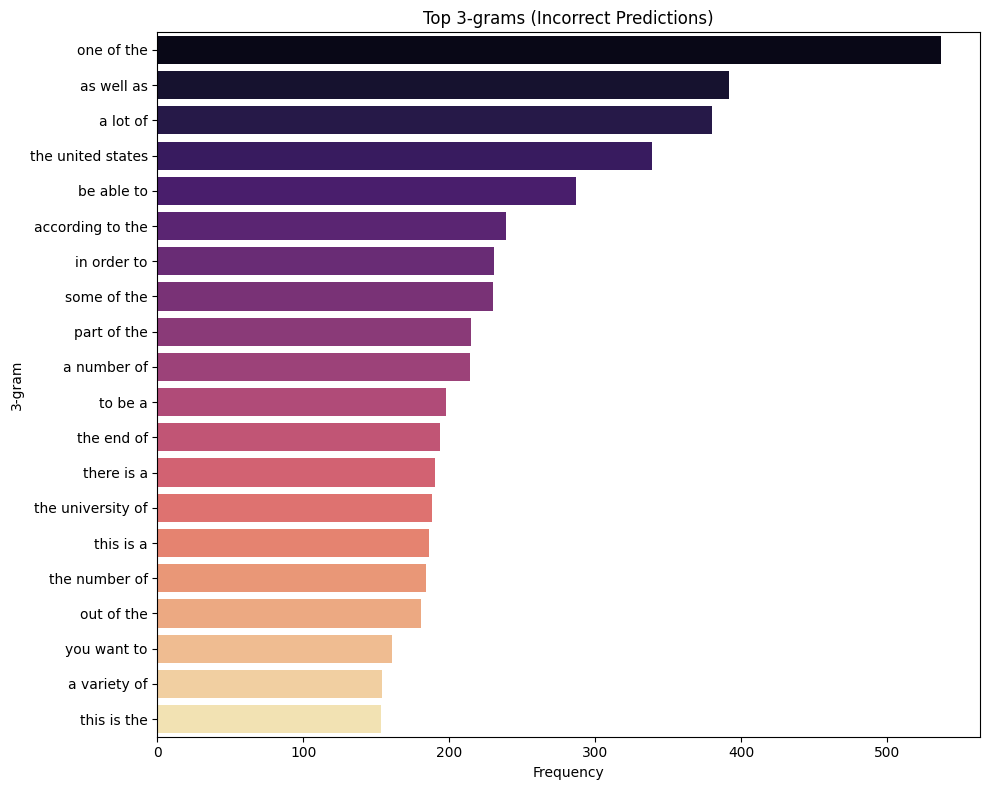

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


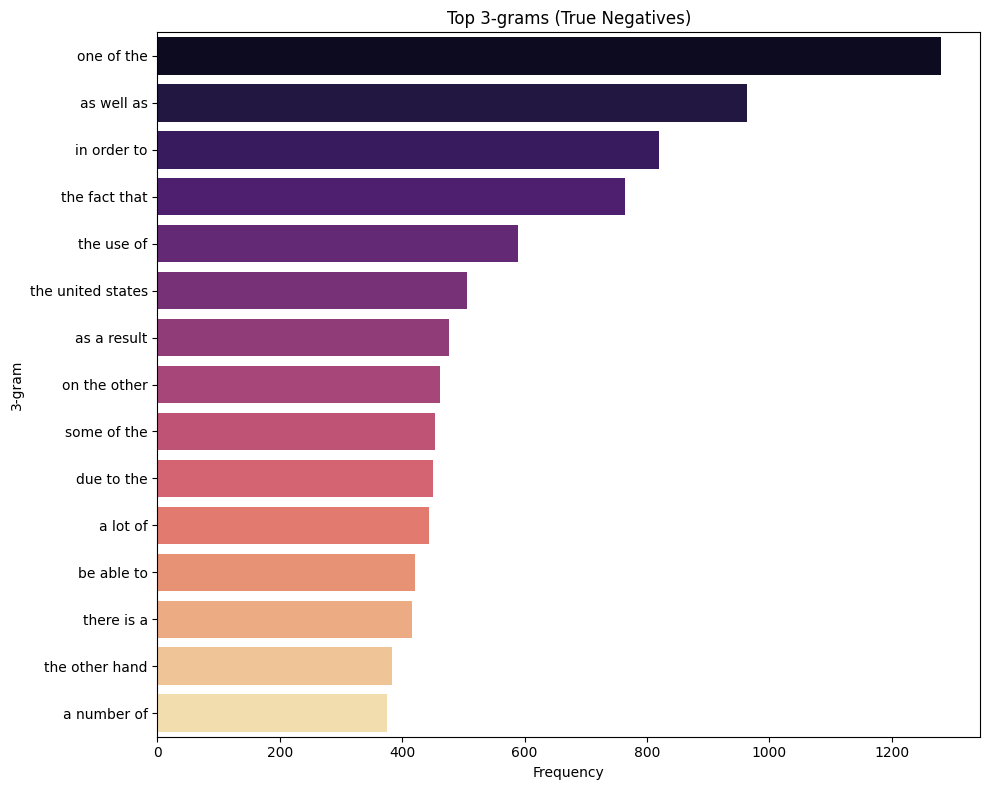

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


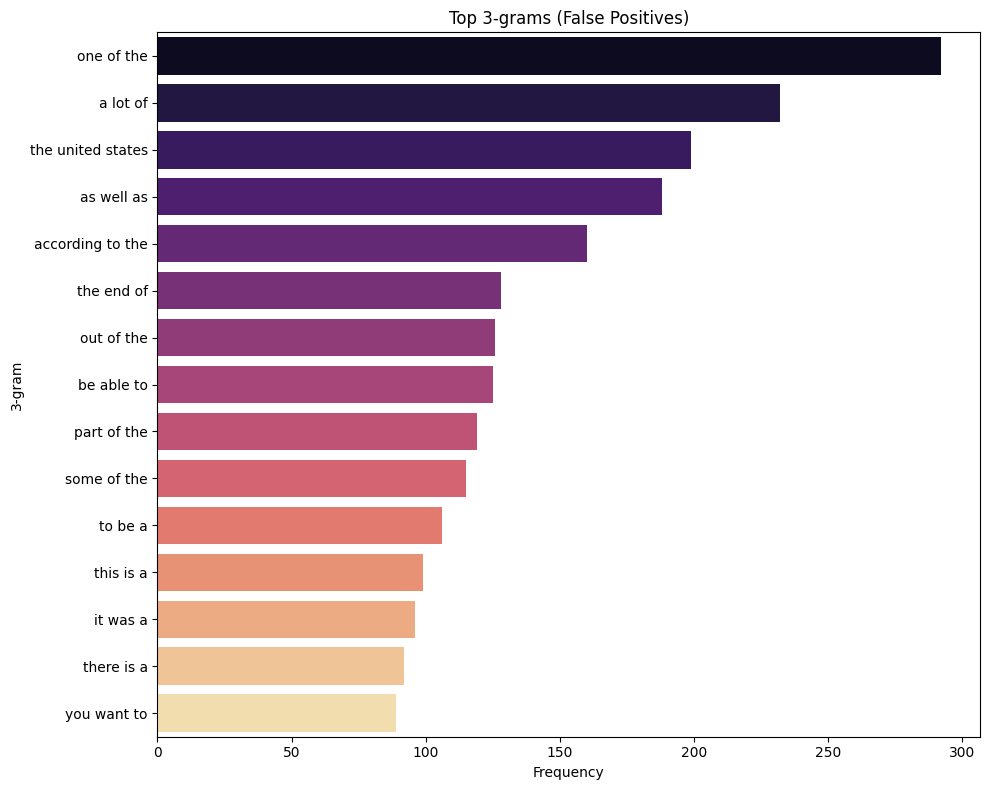

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


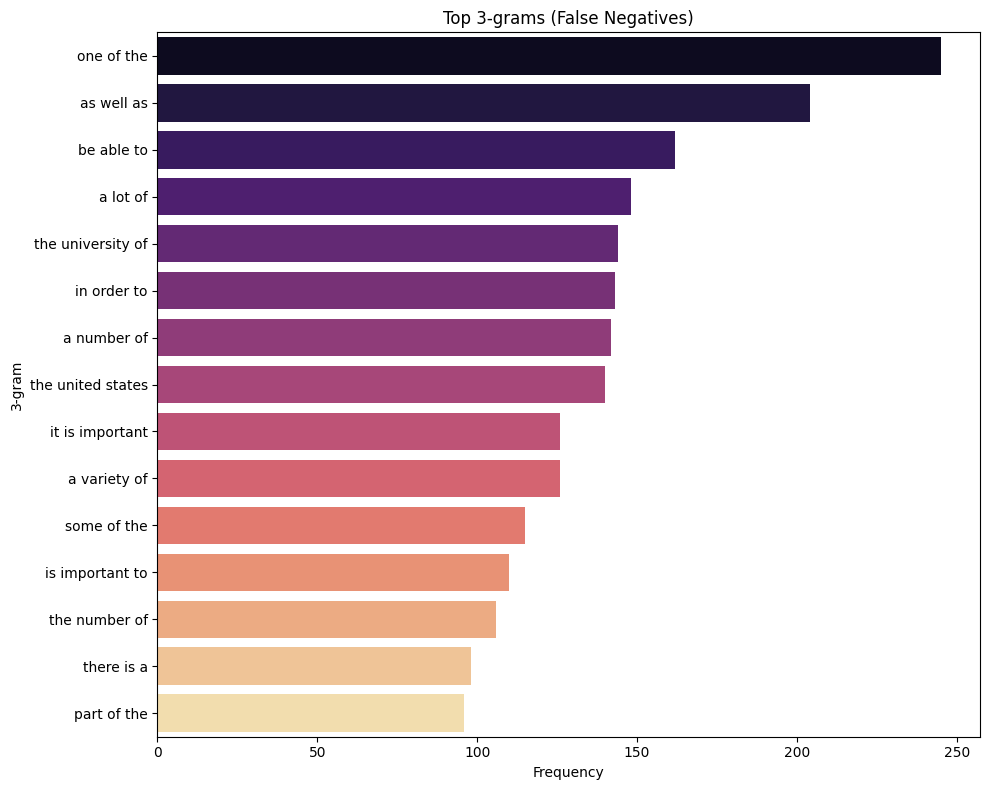

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


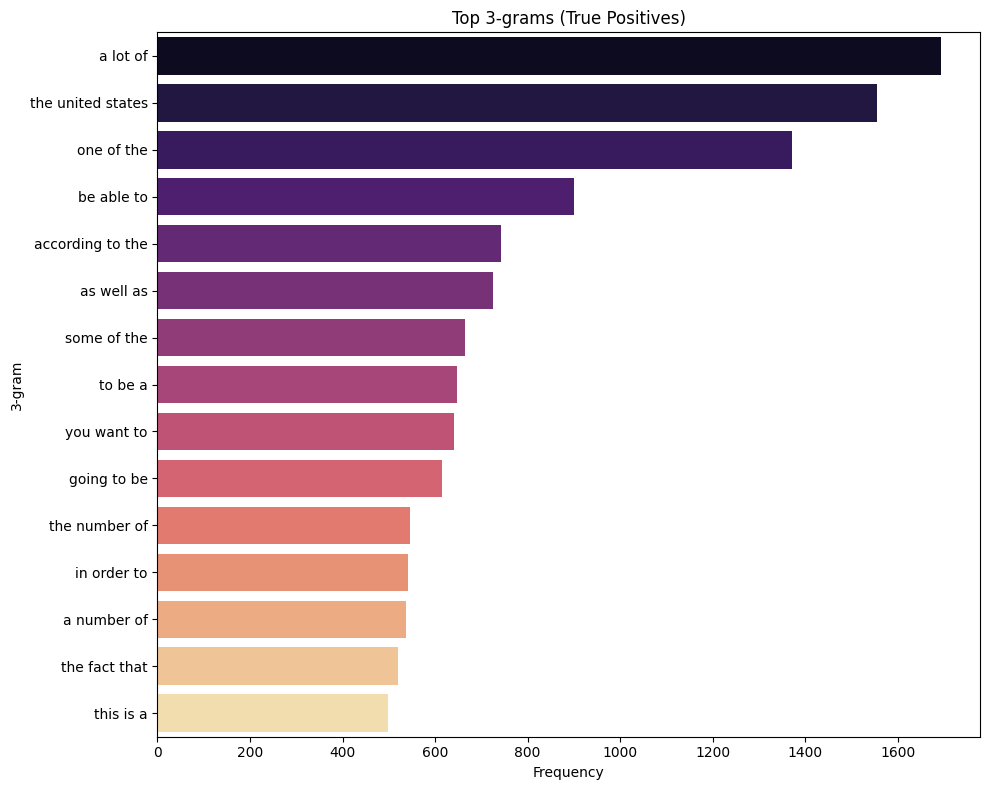


--- Analyzing Prediction Confidence ---


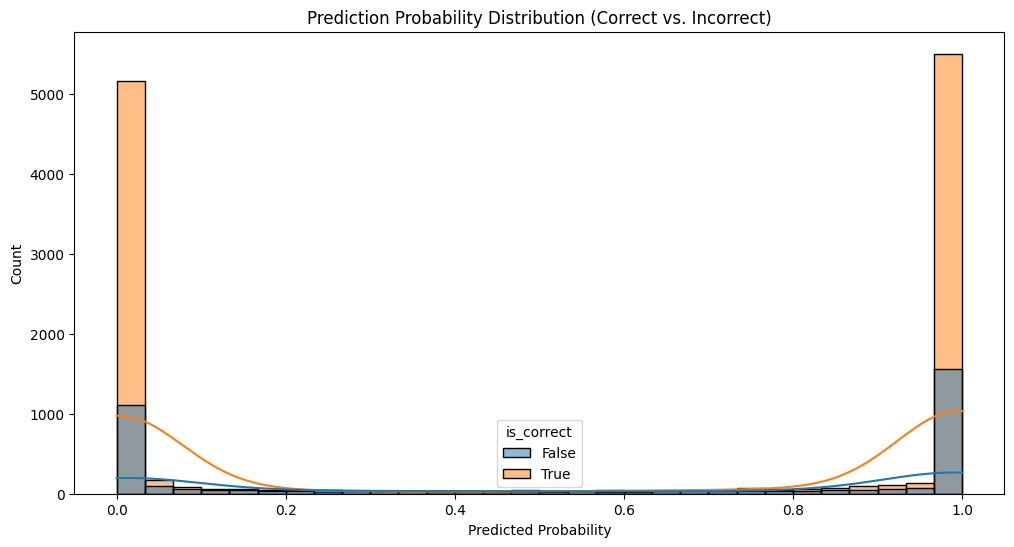


Average Prediction Probability:
is_correct
False    0.557143
True     0.517379
Name: pred_probability, dtype: float64

--- Analyzing Prediction Confidence by result type ---


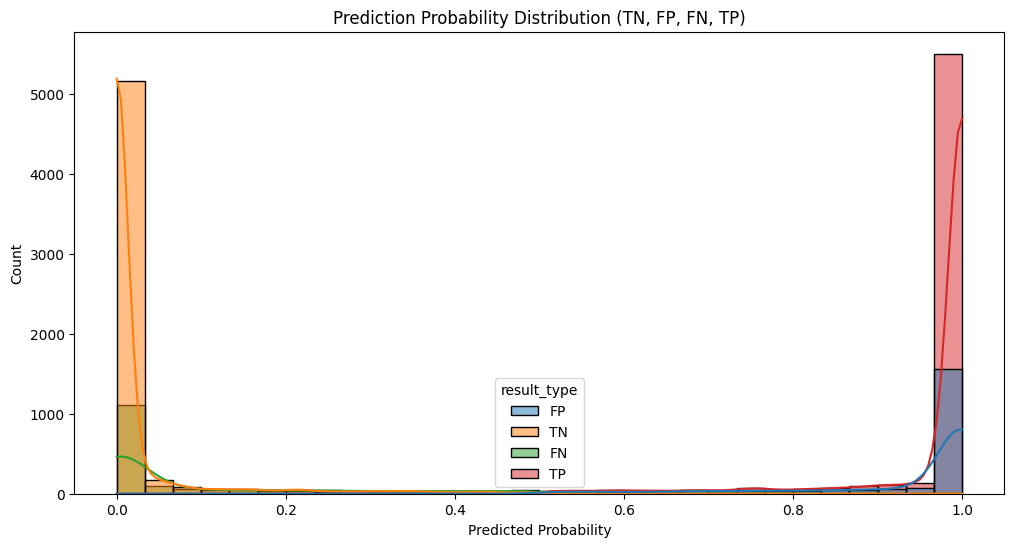


Average Prediction Probability:
result_type
FN    0.086183
FP    0.941862
TN    0.021720
TP    0.970390
Name: pred_probability, dtype: float64

--- Analyzing High-Confidence Errors Examples ---
Found 1700 examples where the prediction was incorrect
but the model's confidence in the wrong prediction was > 0.90

--- Top 10 Most Confident Errors ---

--- Example Index: 3 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 1.0000
  Text Snippet:     at the third presidential debate donald trump invoked a video that says supporters of hillary clinton were paid to incite violence at one of his rallies in chicago it was an attack thread to emphasize that her campaign was sleazy but what trump didnt say is that he has paid the filmmaker who he says uncovered the story the video which was just released earlier this week and made by conservative activist james okeefe of project veritas was paid by the trump foundation in may of one month before t...
---------------------------

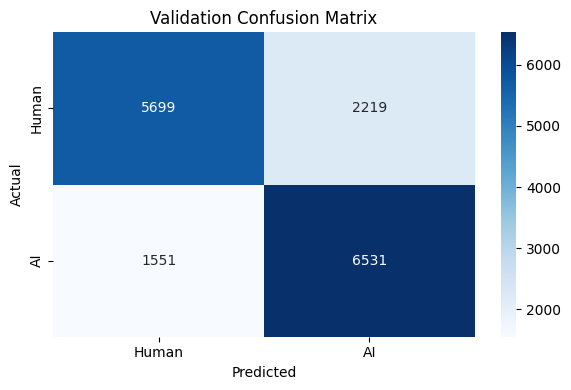


Running error analysis for Naive Bayes with features

--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
Correct Predictions:
 count    12230.000000
mean      2336.342600
std       3004.465647
min          5.000000
25%        892.000000
50%       1067.000000
75%       3401.500000
max      48723.000000
Name: text_length, dtype: float64

Incorrect Predictions:
 count     3770.000000
mean      1878.156499
std       1661.086394
min         12.000000
25%        654.250000
50%       1138.500000
75%       3128.250000
max      26340.000000
Name: text_length, dtype: float64

TN Predictions:
 count     5699.000000
mean      2491.880154
std       4043.591861
min         38.000000
25%        910.000000
50%        950.000000
75%       1728.000000
max      48723.000000
Name: text_length, dtype: float64

FP Predictions:
 count     2219.000000
mean      1968.934655
std       1675.936150
min         40.000000
25%        869.500000
50%       1295.000000
75%       3098.000000
max    

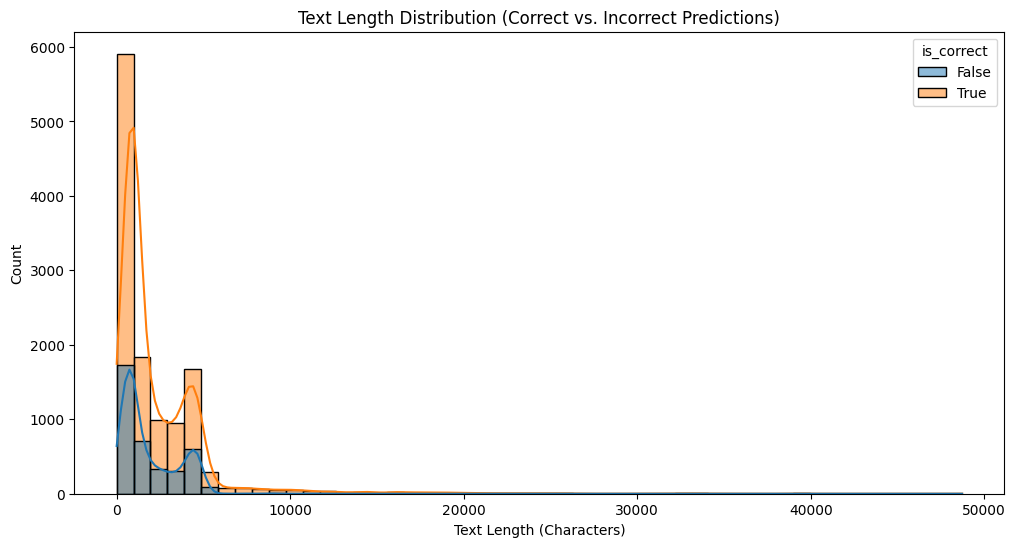

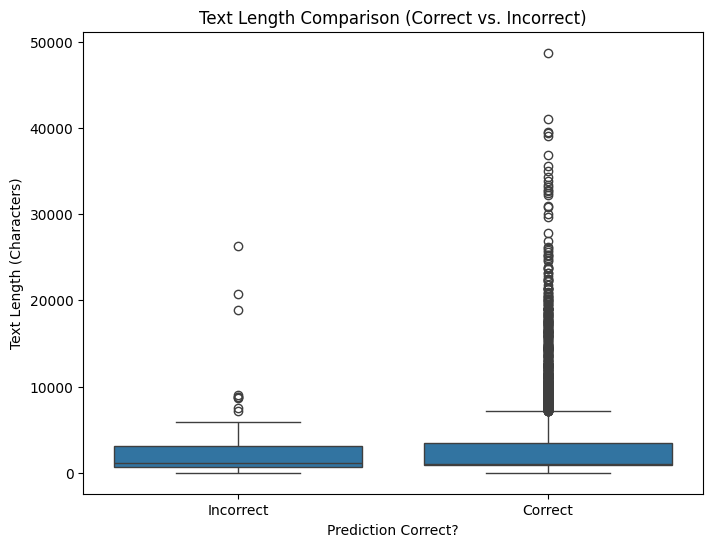

/content/error_analysis.py:182: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Result Type')


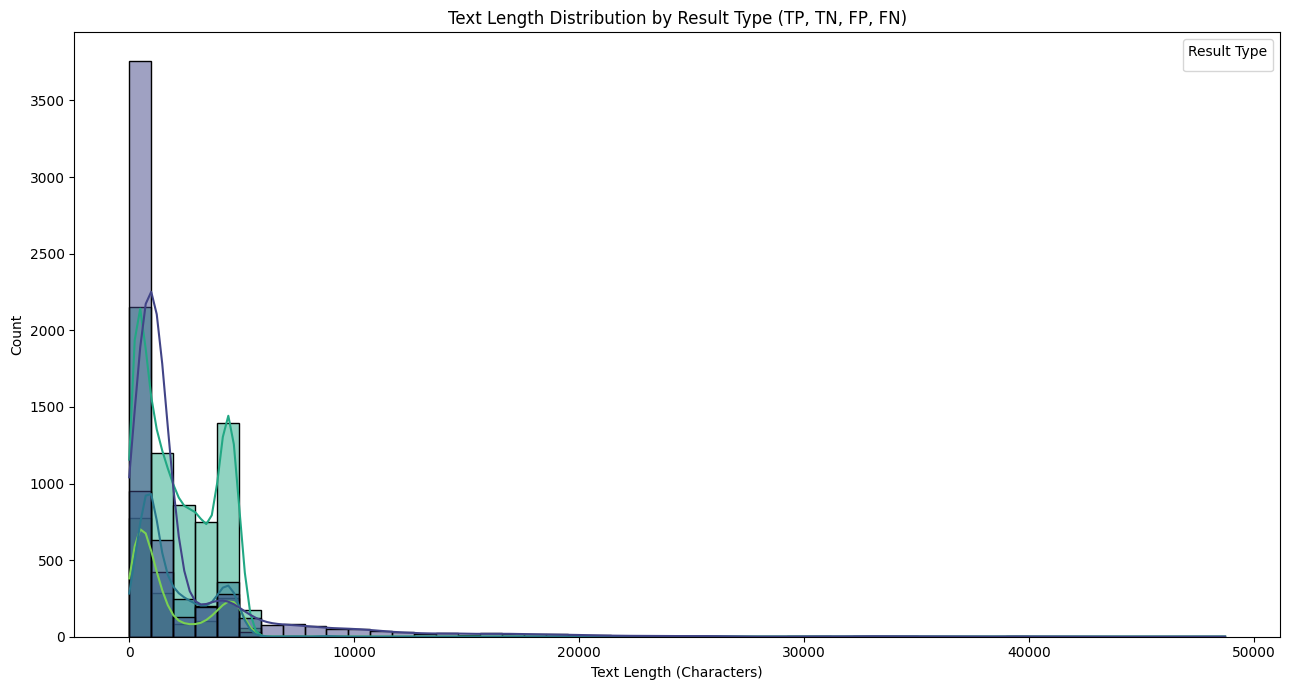

/content/error_analysis.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='result_type', y='text_length',


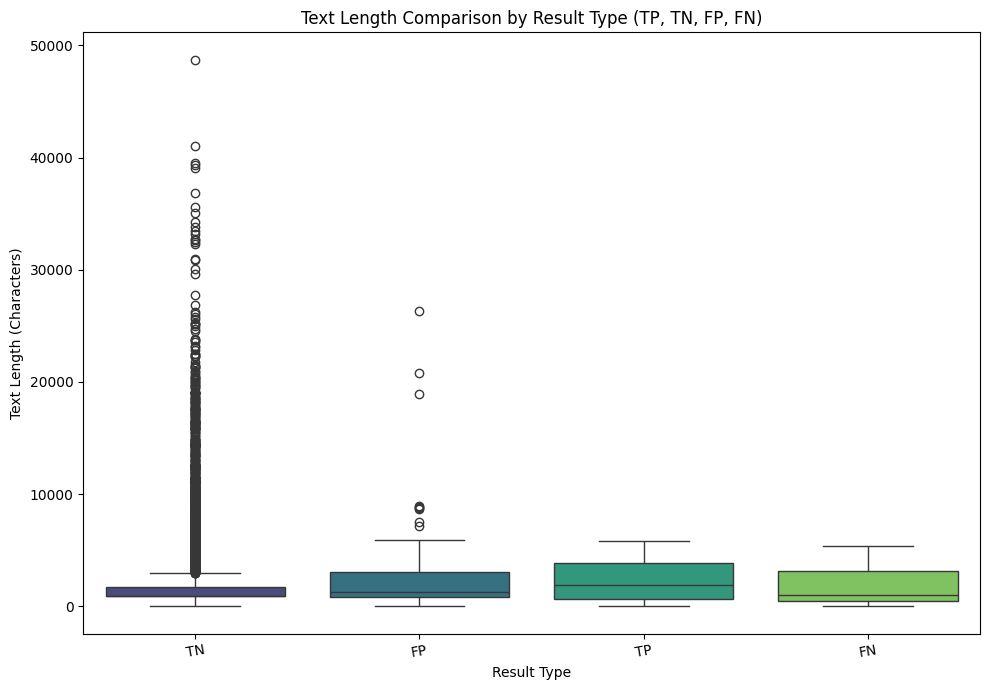


--- Analyzing Text Complexity ---


Calculating Complexity:   0%|          | 0/16000 [00:00<?, ?it/s]


Average Complexity Scores:
            difficult_words
is_correct                 
False             59.987533
True              67.081030


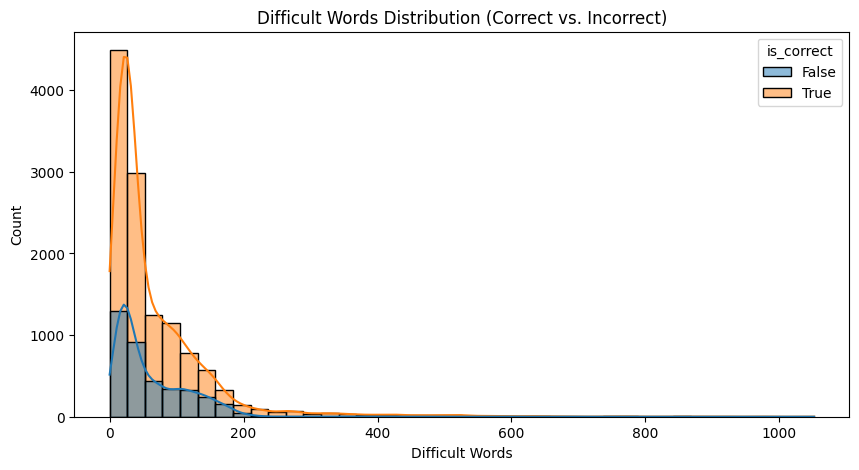


--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---

Descriptive Statistics for Complexity Metrics by Result Type:

--- Difficult Words ---
              count       mean         std  min   25%   50%    75%     max
result_type                                                               
TN           5699.0  73.614318  112.693909  0.0  22.0  29.0   52.0  1052.0
FP           2219.0  65.391167   56.366716  0.0  23.0  43.0  102.0   684.0
TP           6531.0  61.380034   45.868062  0.0  20.0  54.0   94.0   219.0
FN           1551.0  52.256609   45.693791  0.0  17.0  35.0   76.0   203.0


/content/error_analysis.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data_metric, x='result_type', y=metric, order=type_order, palette='viridis')


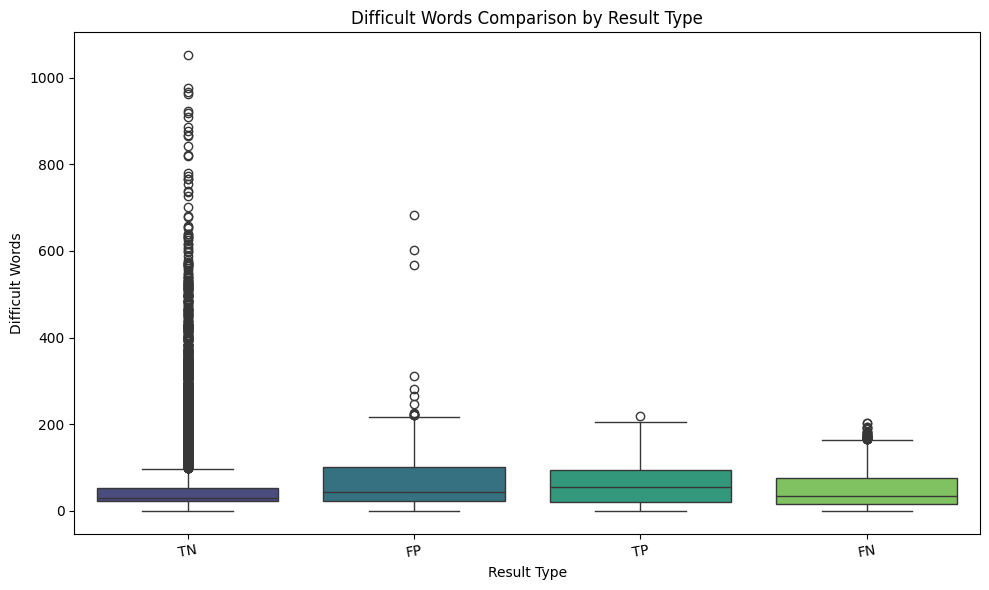

Could not generate legend for difficult_words histogram.


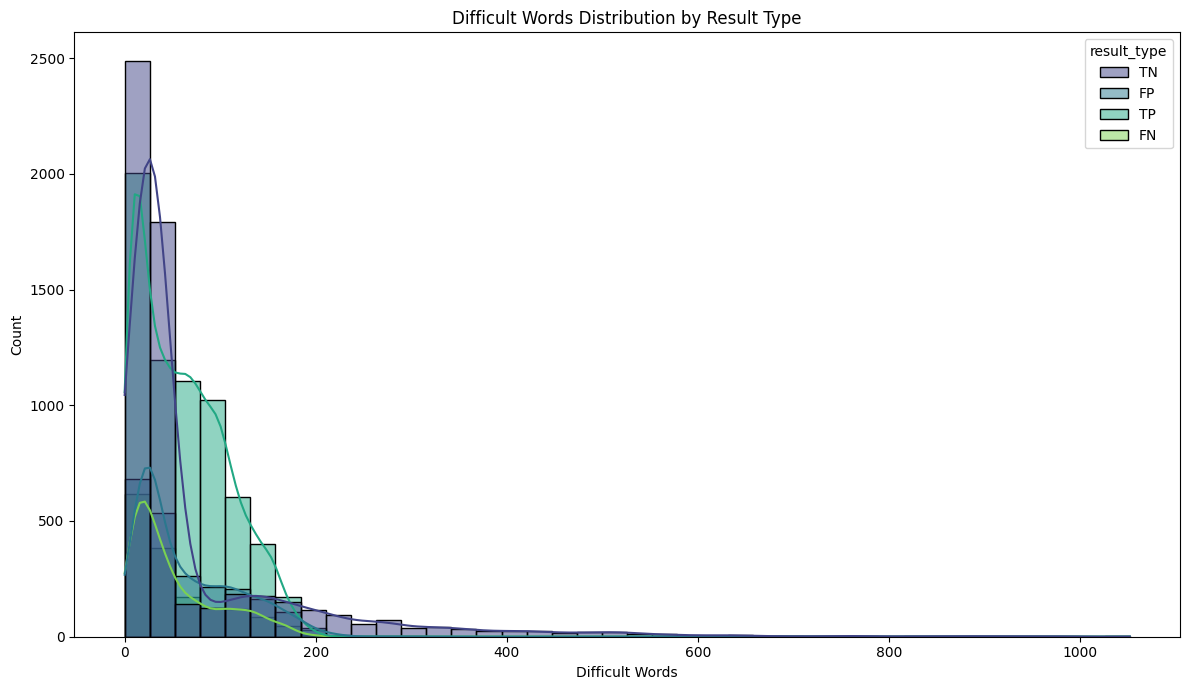


--- Analyzing Top Keywords ---

Top 20 Keywords for Correct Predictions:
   Keyword  Frequency
0     said      12366
1   people      11560
2      new      10855
3     time       8994
4     like       8476
5     just       8194
6     make       6638
7      way       5514
8      use       5463
9     know       5000
10   world       4969
11   years       4708
12    work       4513
13    good       4436
14   going       4409
15    want       4346
16    dont       4295
17    need       4224
18   think       4082
19    used       3986


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


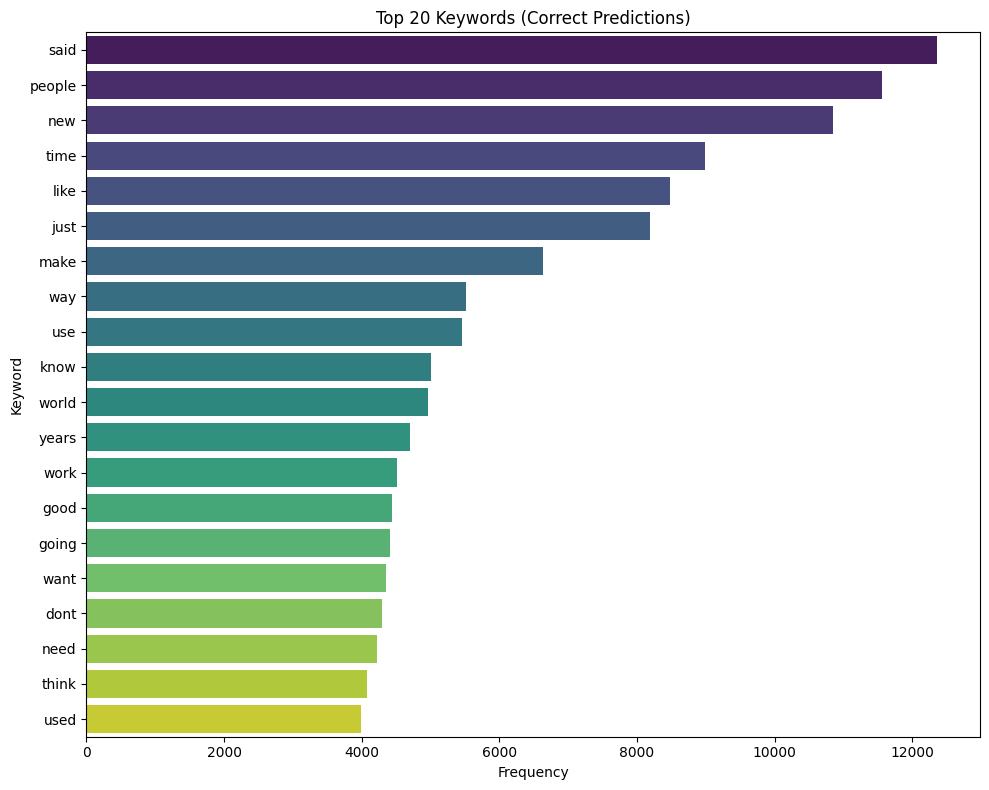


Top 20 Keywords for Incorrect Predictions:
   Keyword  Frequency
0     said       3091
1   people       2709
2      new       2348
3     time       2228
4     just       2142
5     like       2104
6     make       1478
7      use       1414
8      way       1357
9    years       1349
10    know       1217
11   world       1201
12    dont       1194
13    good       1070
14    year       1059
15    used       1053
16    need        968
17   think        964
18    want        962
19    help        960


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


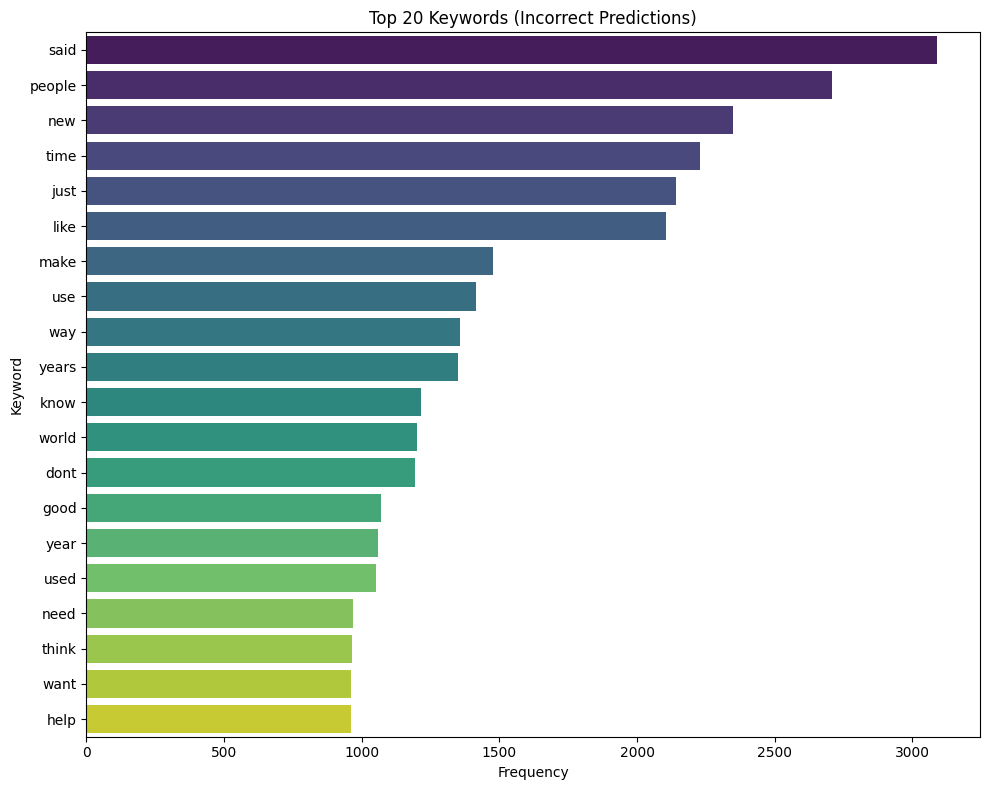


Top 20 Keywords for True Negatives:
       Keyword  Frequency
0       people       4750
1         time       4172
2         like       3686
3         just       3212
4          new       3181
5      company       2845
6        world       2647
7         life       2478
8          use       2449
9          way       2424
10   different       2226
11        used       2219
12        work       2206
13    business       2071
14        make       2018
15        said       1999
16  management       1960
17       human       1923
18        know       1922
19         man       1904


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


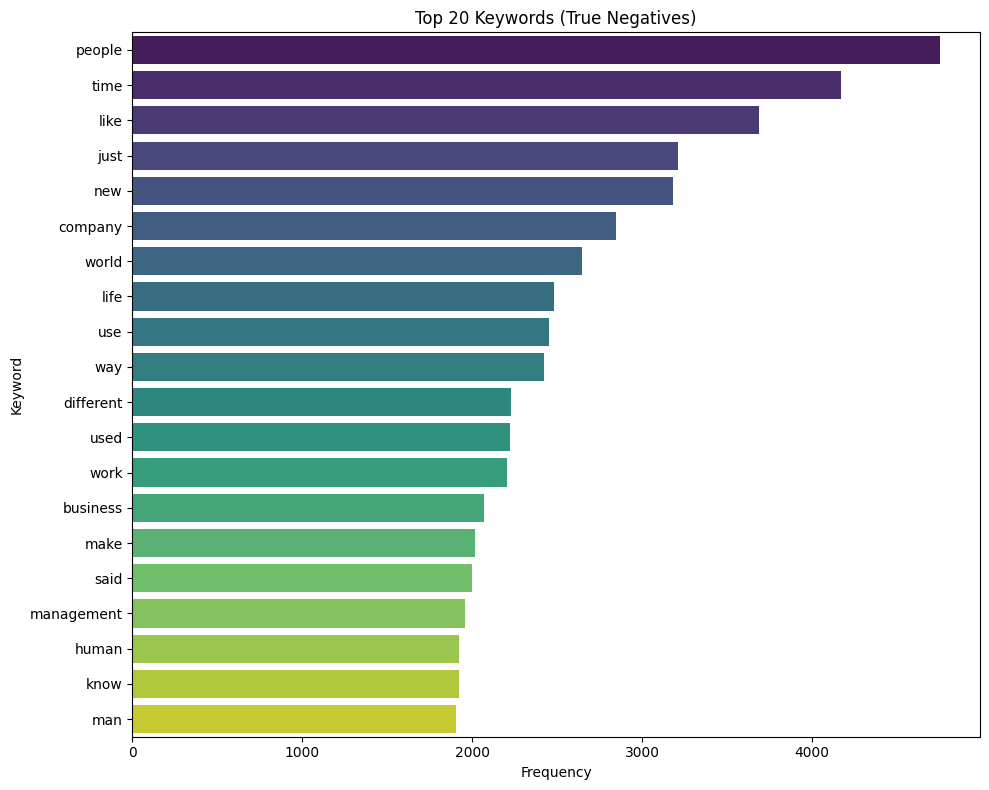


Top 20 Keywords for False Positives:
   Keyword  Frequency
0     said       2581
1     just       1564
2   people       1539
3      new       1491
4     like       1452
5     time       1389
6    years        937
7     dont        919
8     know        854
9     make        853
10    year        853
11     way        744
12    game        718
13  police        693
14    want        682
15   think        674
16      im        660
17     use        648
18    good        638
19   going        636


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


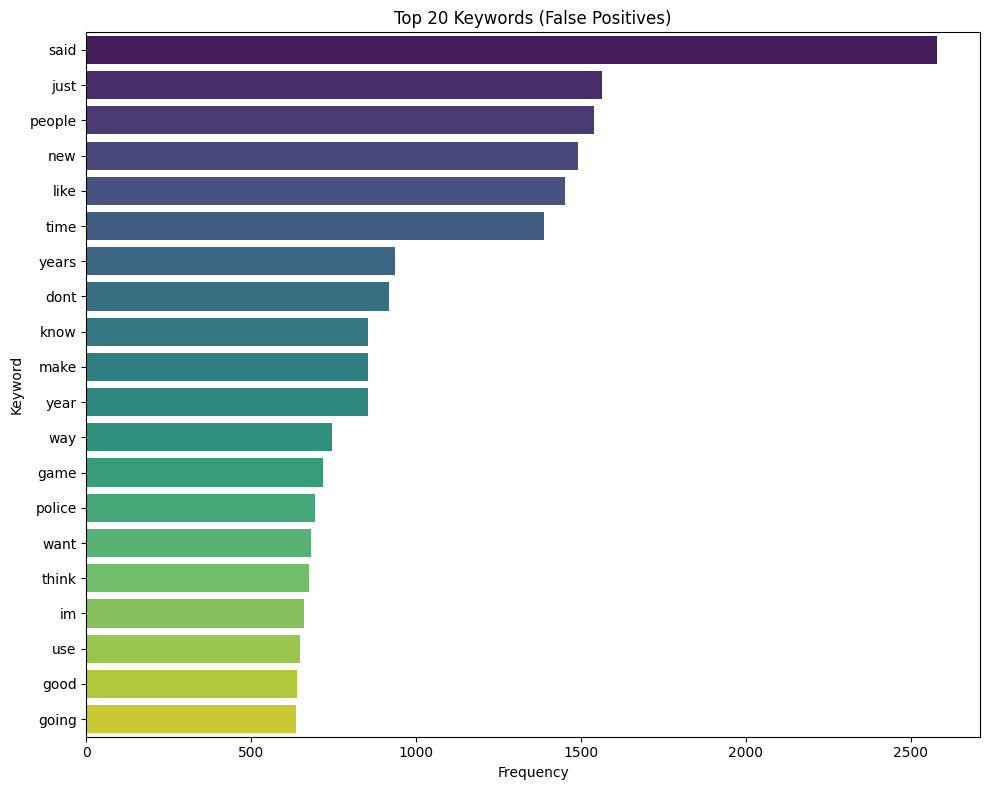


Top 20 Keywords for False Negatives:
      Keyword  Frequency
0      people       1170
1         new        857
2        time        839
3         use        766
4        used        662
5        like        652
6        make        625
7         way        613
8       study        590
9   different        580
10       just        578
11      world        574
12       help        561
13  important        561
14     health        512
15       said        510
16   research        464
17       good        432
18     number        431
19       life        425


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


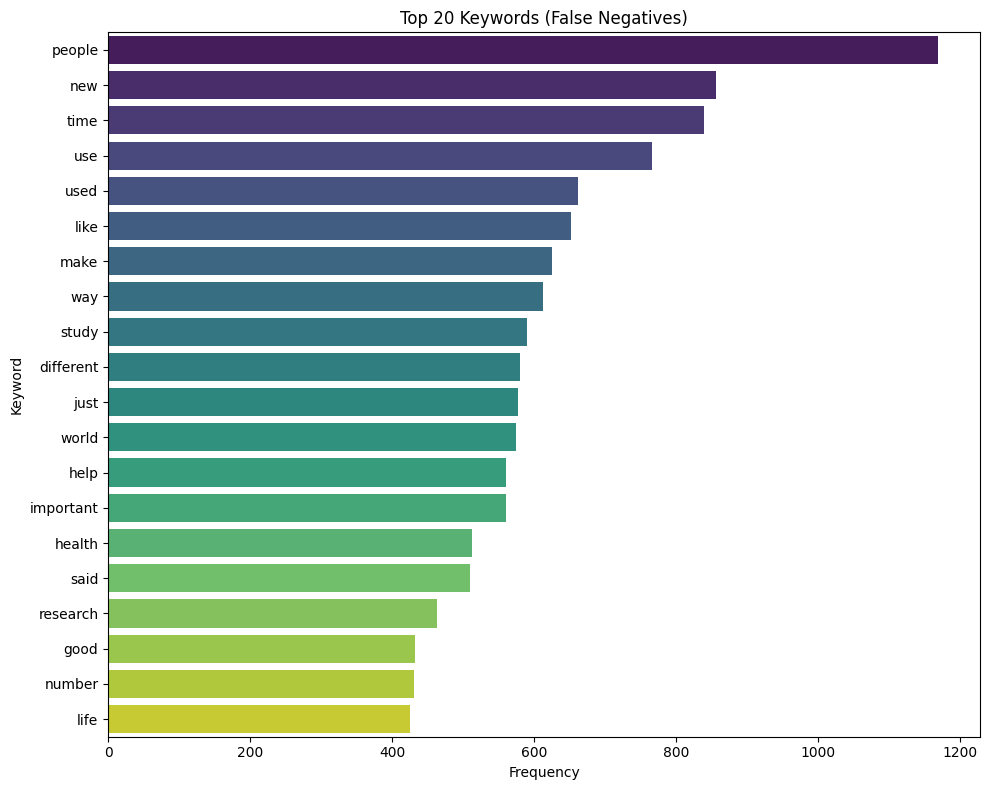


Top 20 Keywords for True Positives:
       Keyword  Frequency
0         said      10367
1          new       7674
2       people       6810
3         just       4982
4         time       4822
5         like       4790
6         make       4620
7         want       3495
8        going       3314
9         dont       3252
10         way       3090
11        know       3078
12        game       3032
13         use       3014
14       think       2994
15        year       2931
16       years       2903
17        good       2835
18  government       2813
19        need       2609


/content/error_analysis.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


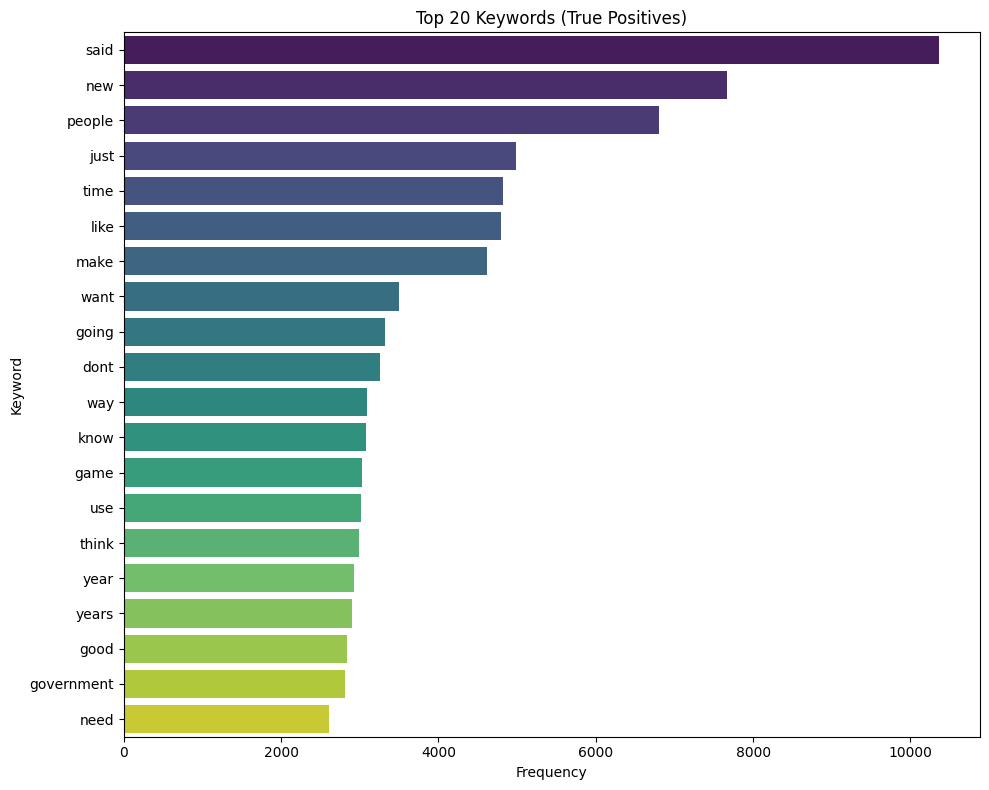


--- Analyzing N-grams ---

-- Top 2-grams --

Top 2-grams for Correct Predictions:
      2-gram  Frequency
0     of the      35574
1     in the      29335
2     to the      15235
3     on the      11920
4    and the       9516
5      to be       9235
6    for the       8872
7   that the       8480
8      it is       7300
9   with the       7192
10      in a       7016
11    at the       6592
12      is a       6341
13  from the       6169
14      of a       5763
15      as a       5420
16    by the       5309
17    it was       5254
18   will be       4467
19    is the       4392


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


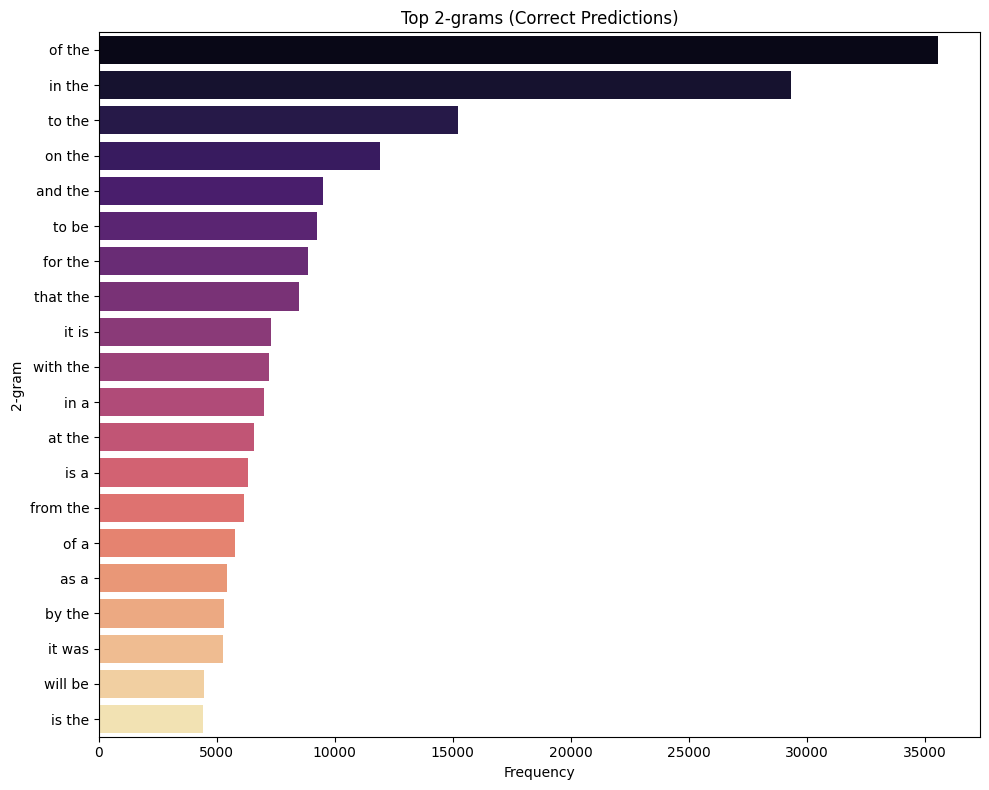


Top 2-grams for Incorrect Predictions:
      2-gram  Frequency
0     of the       7875
1     in the       6716
2     to the       3261
3     on the       2547
4    and the       2182
5      to be       2045
6    for the       2027
7       in a       1887
8       is a       1744
9   that the       1713
10    at the       1703
11     it is       1605
12  with the       1484
13  from the       1468
14      of a       1460
15    by the       1238
16      as a       1223
17    with a       1188
18    is the       1089
19    it was       1046


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


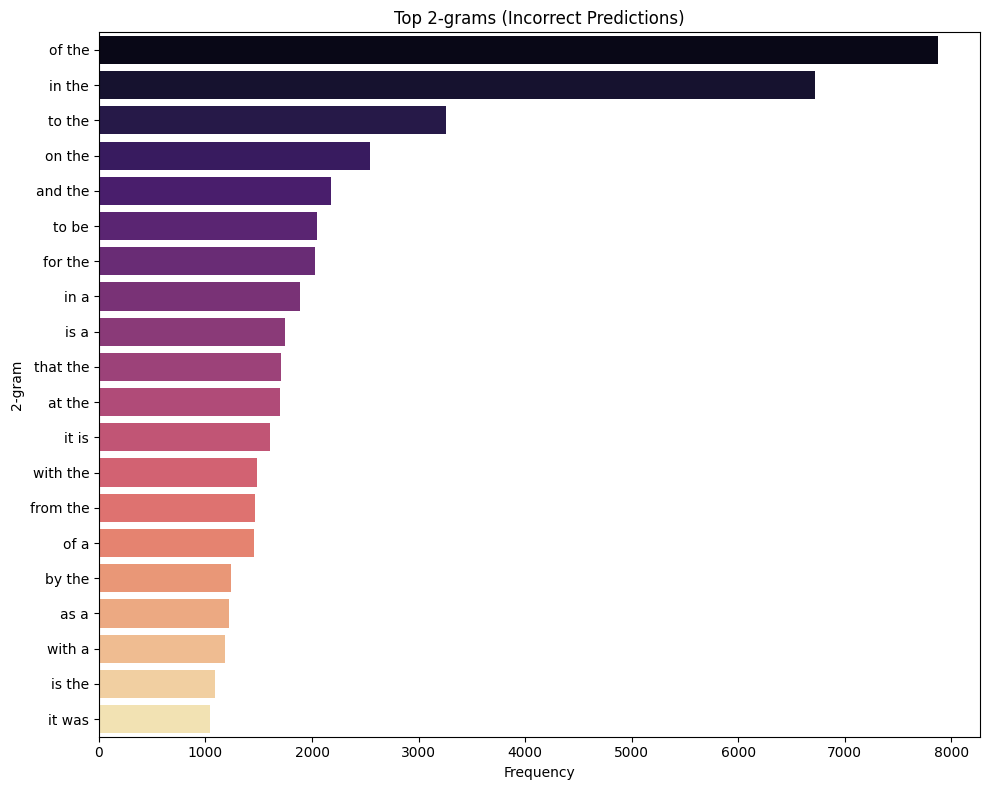

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


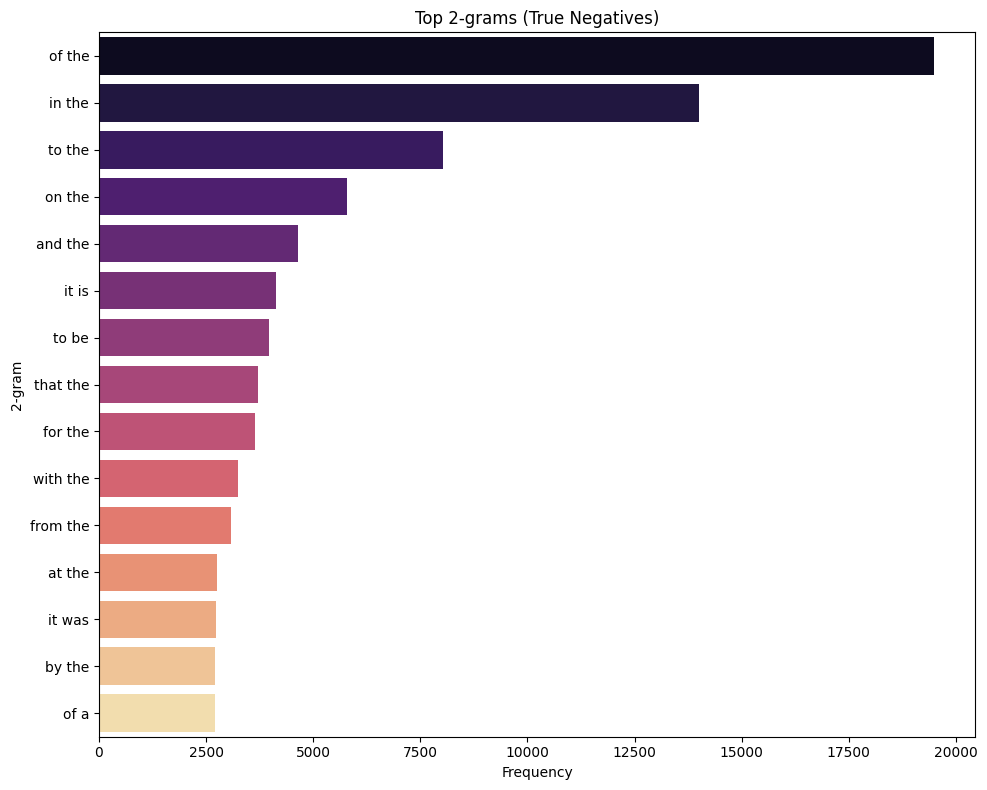

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


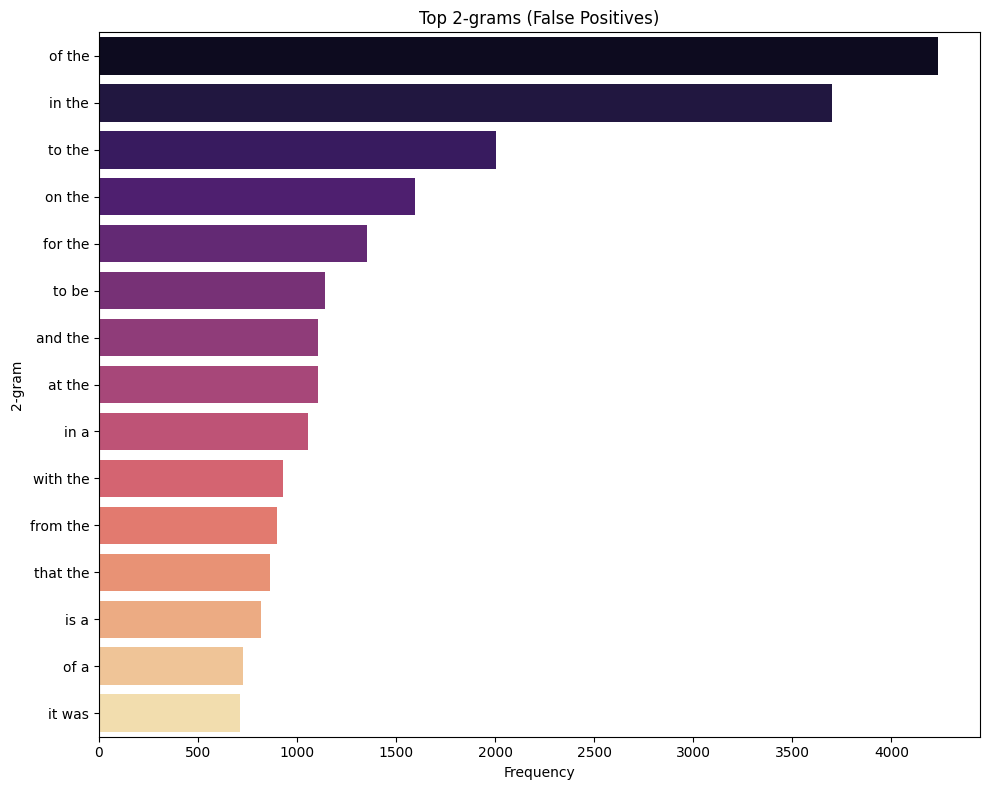

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


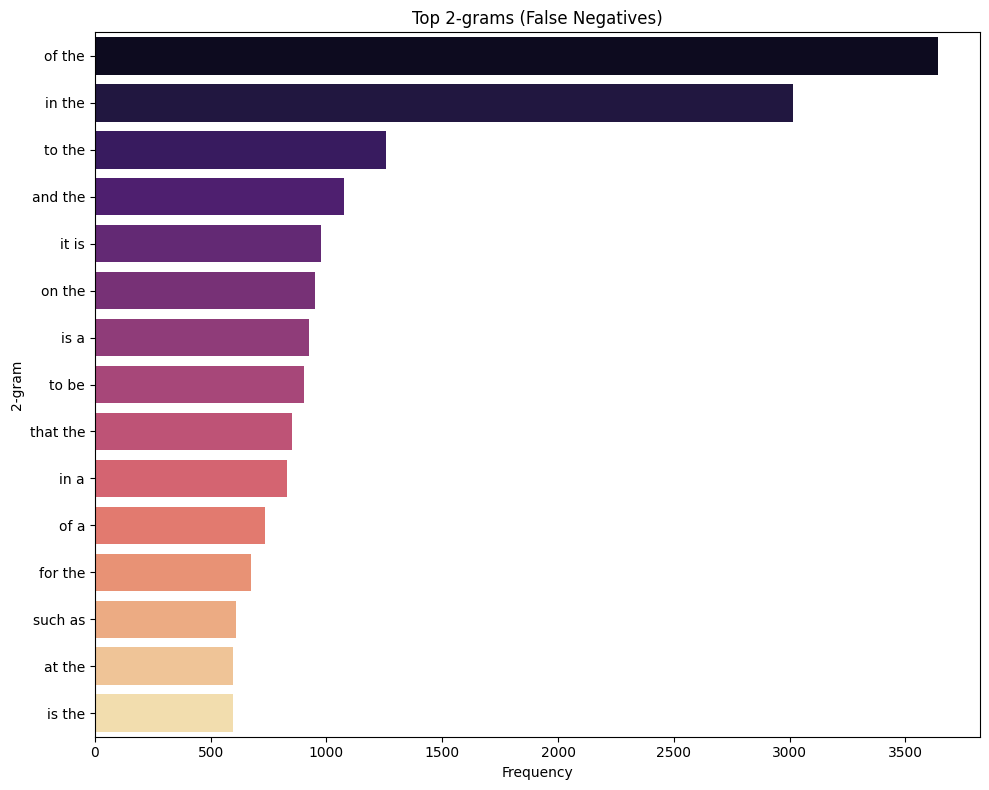

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


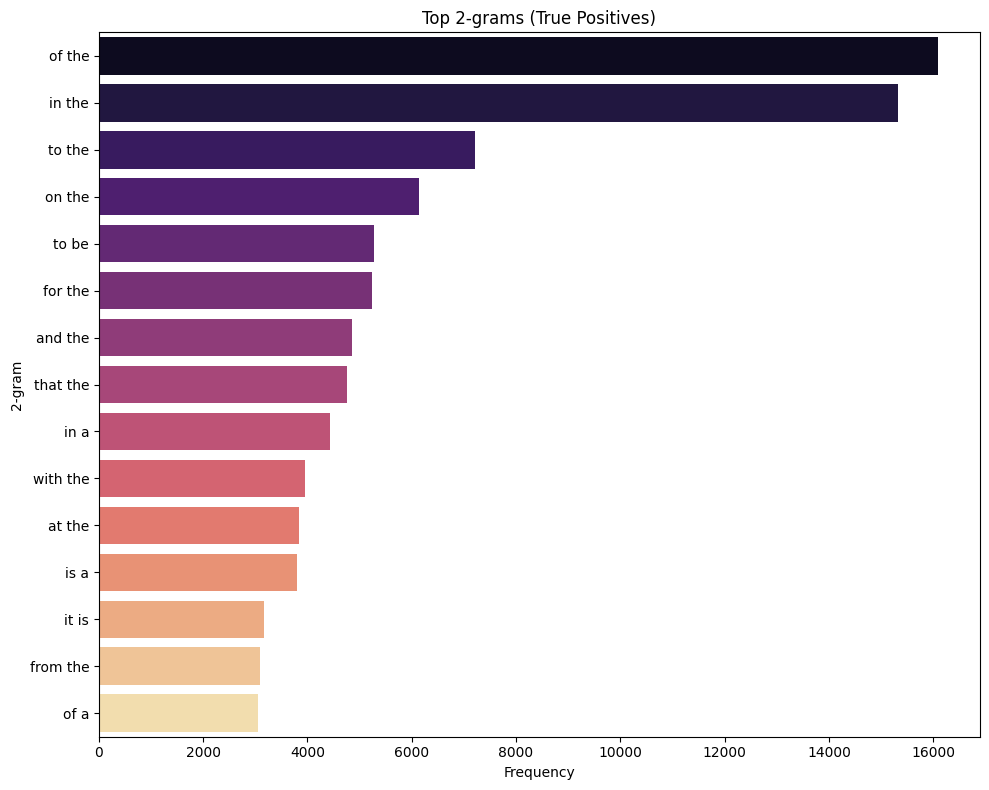


-- Top 3-grams --

Top 3-grams for Correct Predictions:
               3-gram  Frequency
0          one of the       2652
1            a lot of       2137
2   the united states       2054
3          as well as       1685
4         in order to       1364
5          be able to       1324
6       the fact that       1284
7         some of the       1121
8    according to the       1085
9             to be a        942
10        a number of        912
11      the number of        855
12        part of the        840
13         there is a        804
14         the use of        804
15        as a result        764
16          this is a        745
17         the end of        744
18       in the world        742
19      in the united        739


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


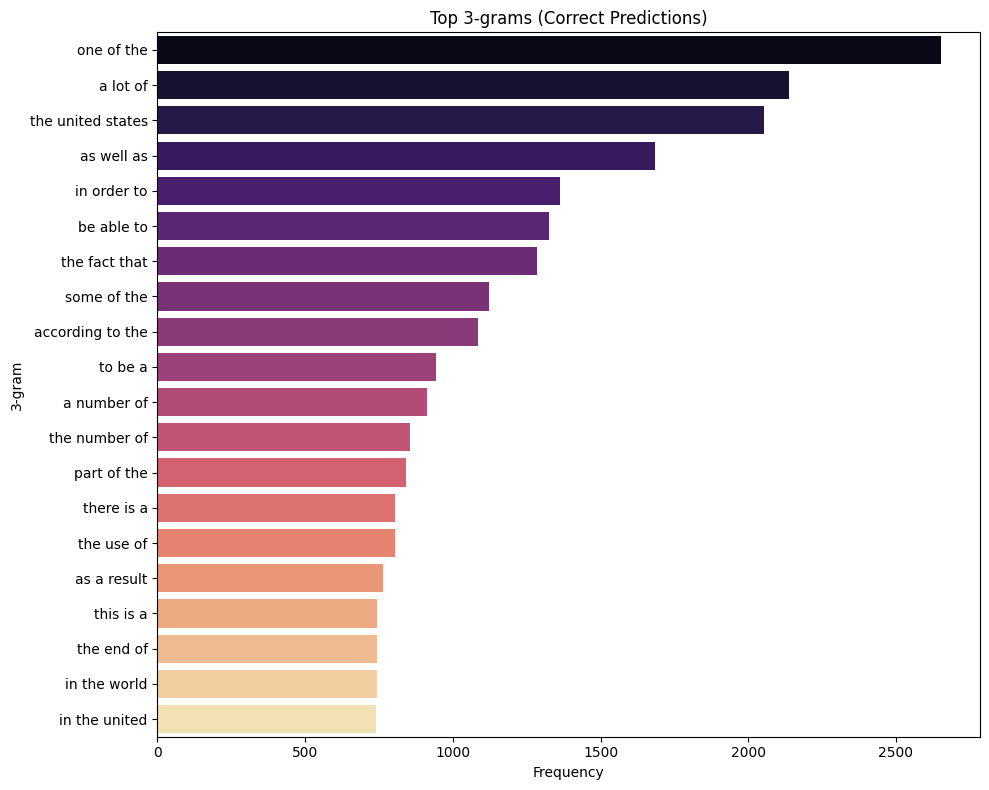


Top 3-grams for Incorrect Predictions:
               3-gram  Frequency
0          one of the        536
1          as well as        396
2            a lot of        380
3   the united states        346
4          be able to        285
5    according to the        242
6         in order to        229
7         some of the        227
8         a number of        215
9         part of the        214
10         the end of        202
11            to be a        201
12         there is a        191
13  the university of        188
14      the number of        186
15         out of the        185
16          this is a        184
17       in the world        159
18        this is the        154
19        you want to        153


/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


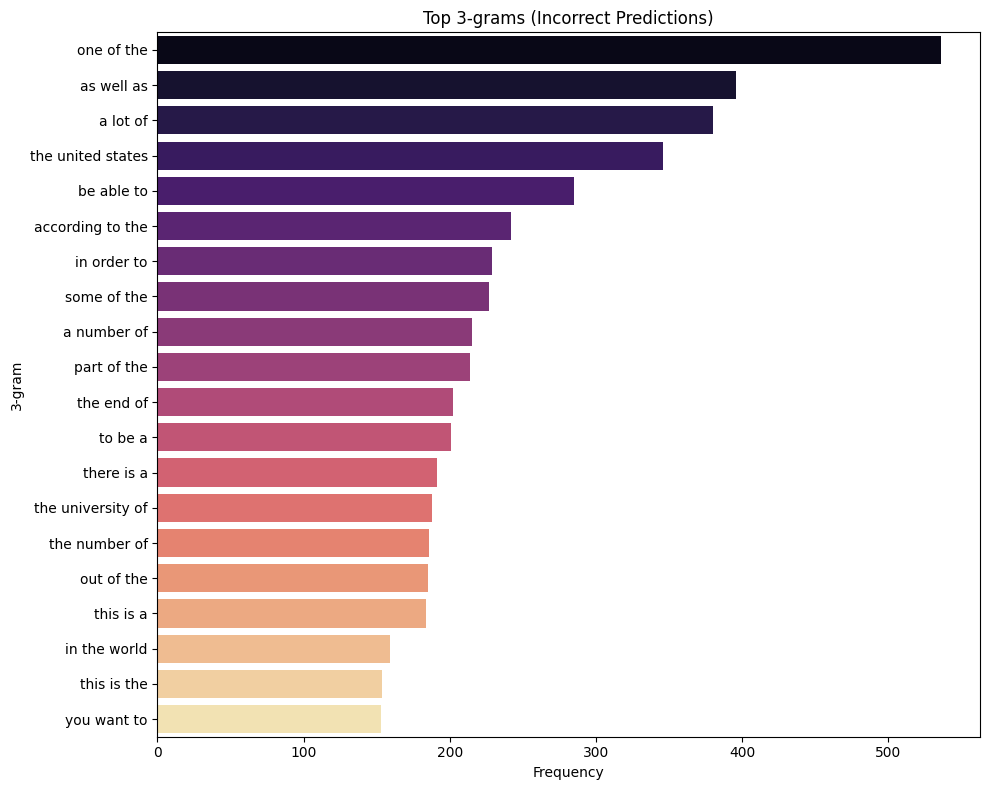

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


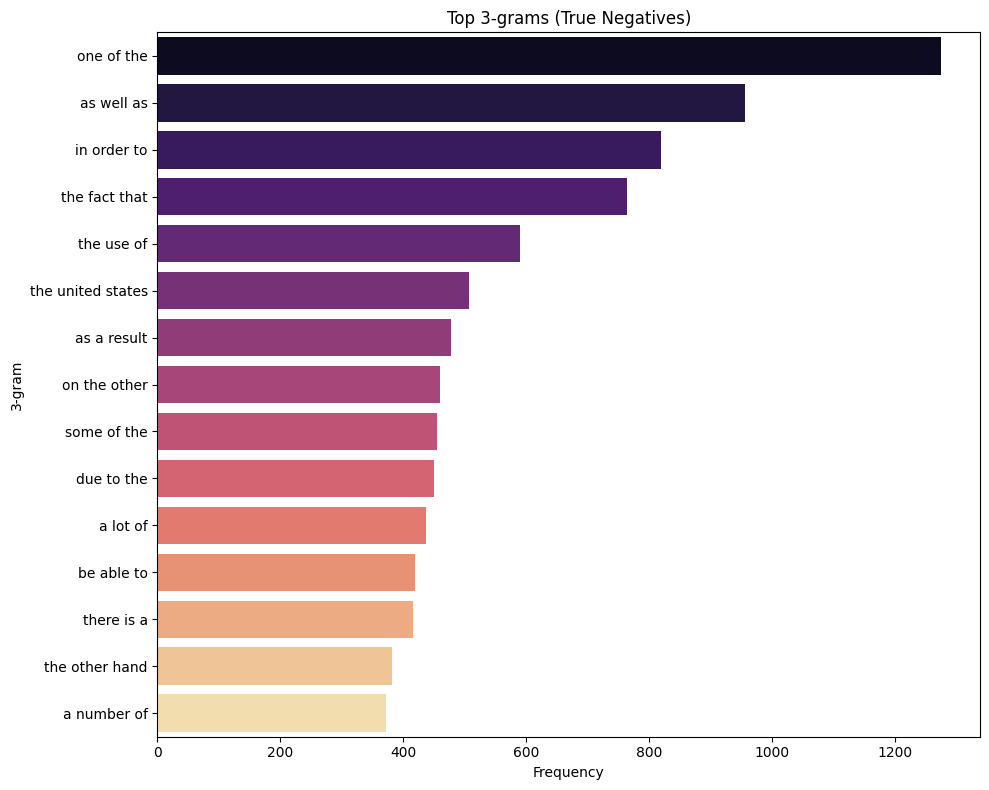

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


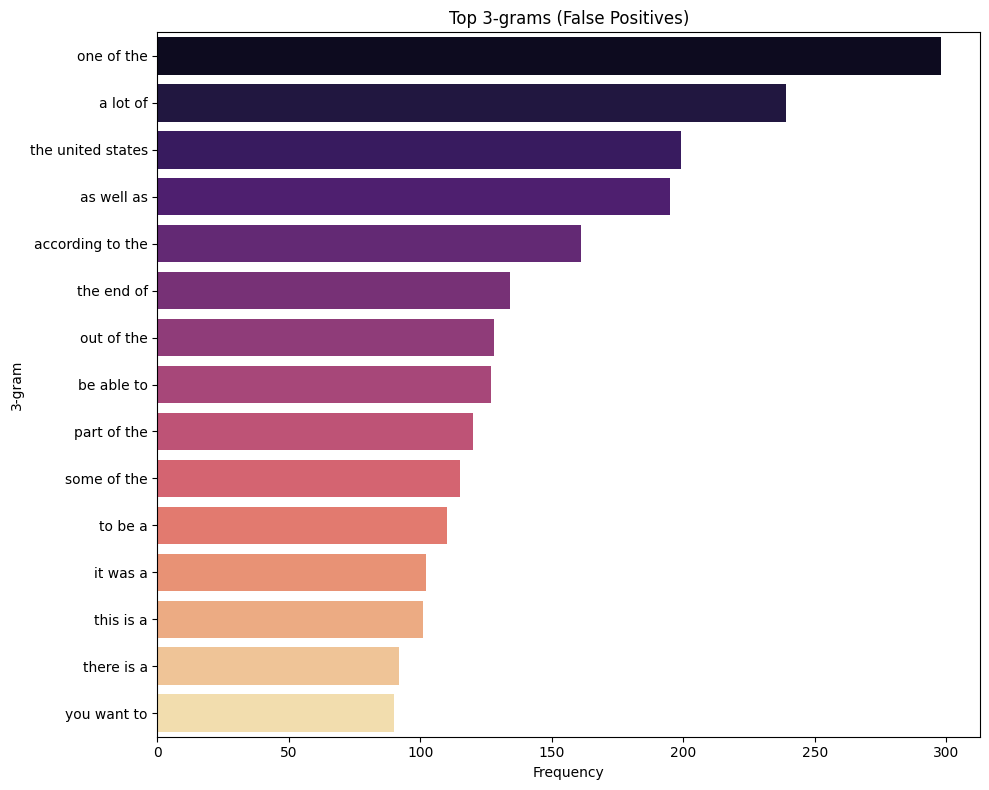

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


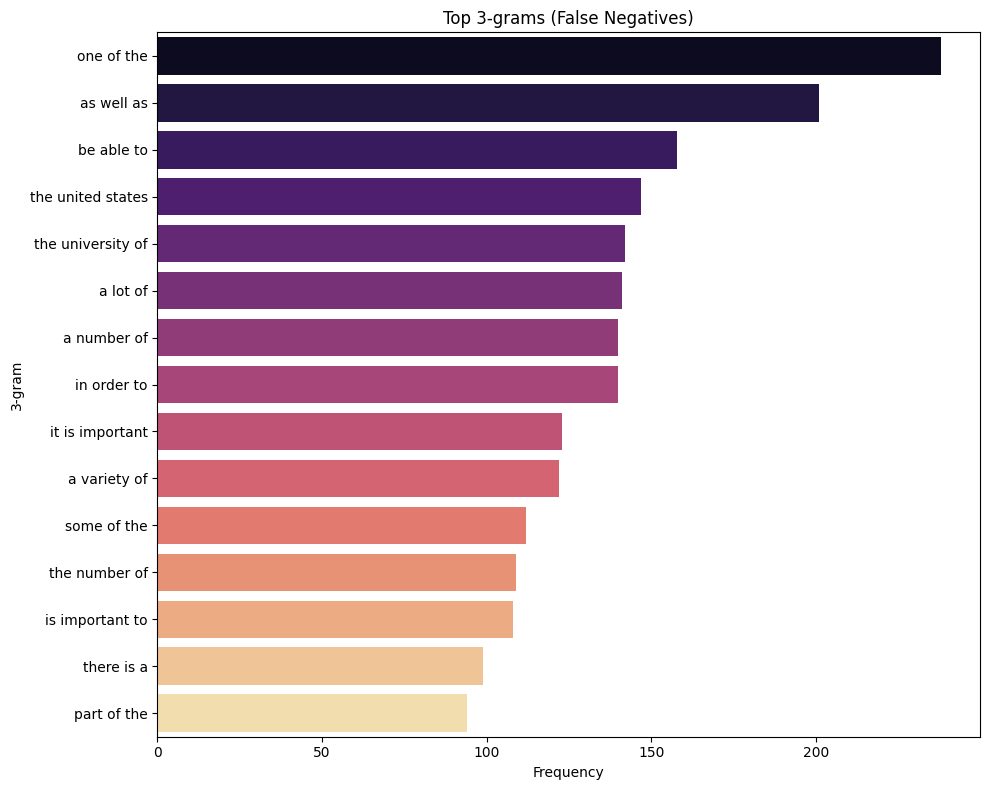

/content/error_analysis.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


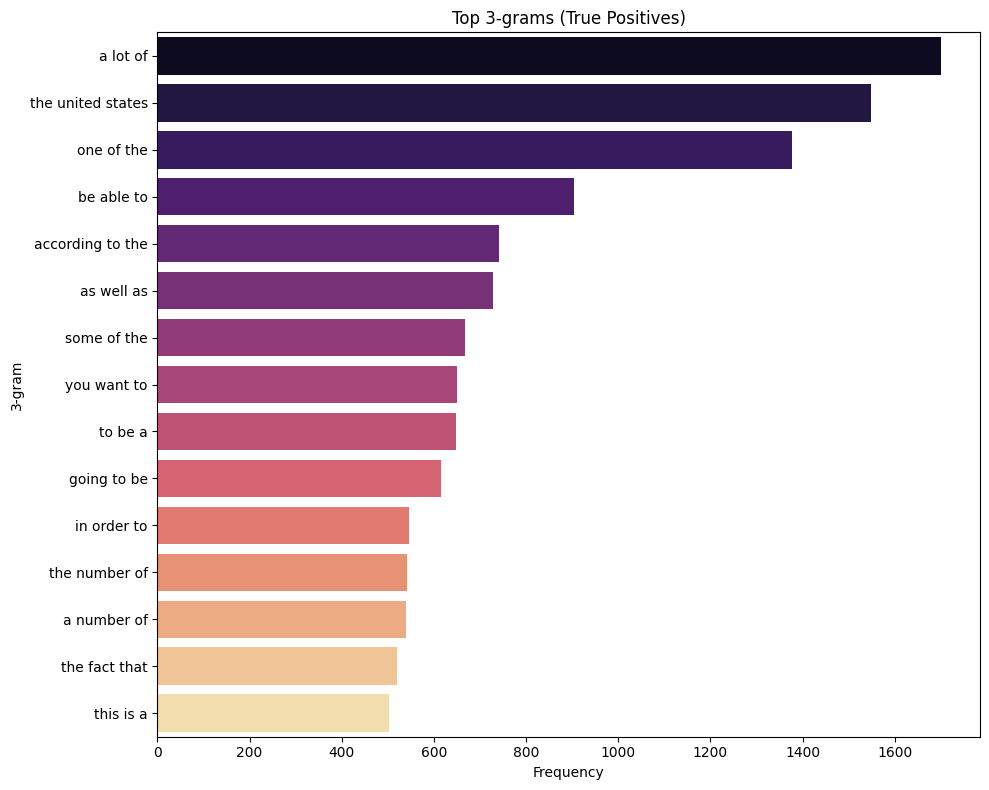


--- Analyzing Prediction Confidence ---


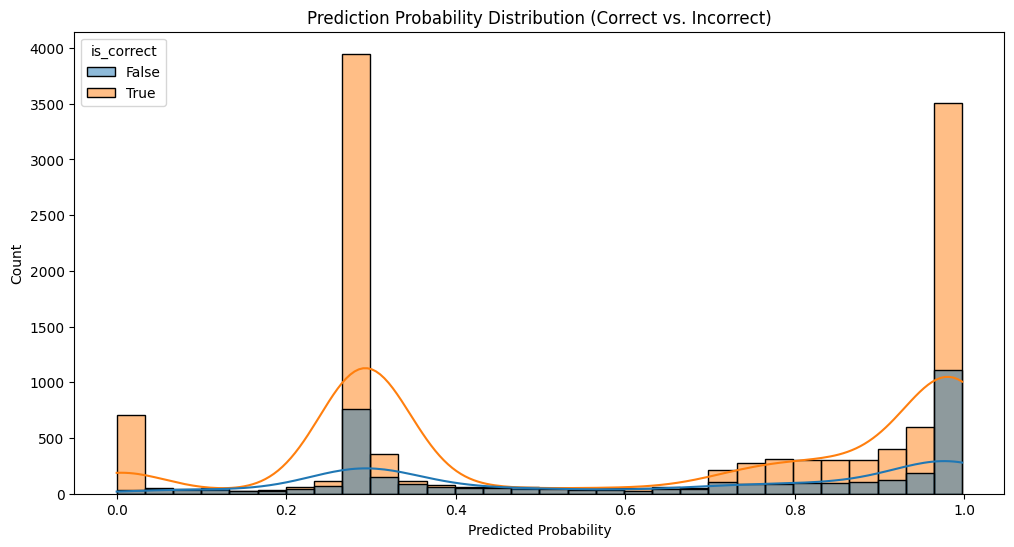


Average Prediction Probability:
is_correct
False    0.643144
True     0.608081
Name: pred_probability, dtype: float64

--- Analyzing Prediction Confidence by result type ---


/content/error_analysis.py:338: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(output_dir, f"{prefix}confidence_histogram_by_type.png"))


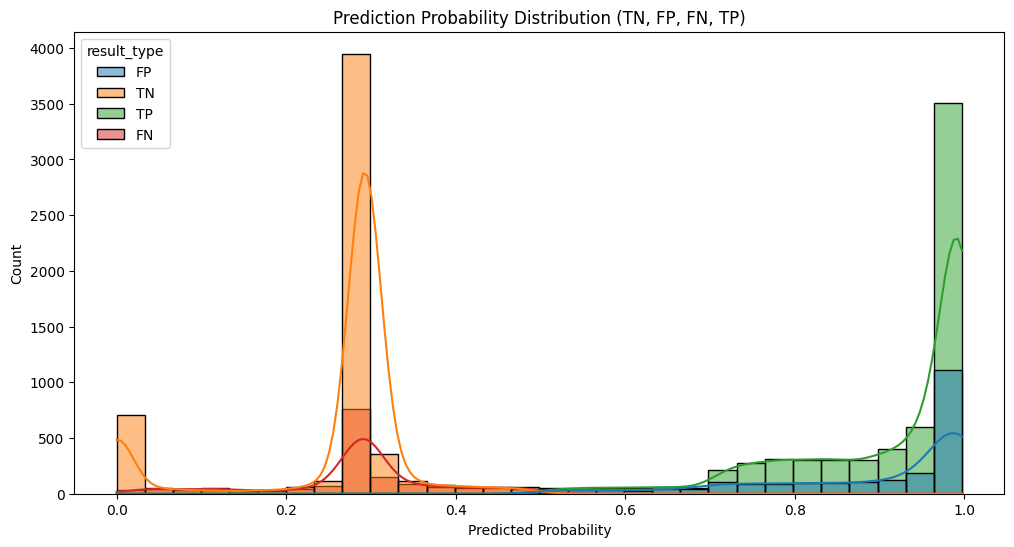


Average Prediction Probability:
result_type
FN    0.284400
FP    0.893893
TN    0.257133
TP    0.914320
Name: pred_probability, dtype: float64

--- Analyzing High-Confidence Errors Examples ---
Found 1414 examples where the prediction was incorrect
but the model's confidence in the wrong prediction was > 0.90

--- Top 10 Most Confident Errors ---

--- Example Index: 13640 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 0.9974
  Text Snippet:     souleymane was denied access to metro train by fans the man denied access to a paris metro train by chelsea supporters has hit out at an invitation for him to attend a match at stamford bridge claiming he cant be bought with a little piece of paper souleymane s born in paris to mauritanian parents was pushed back by a group of chelsea fans chanting were racist and thats the way we like it as he tried to board a train ahead of last months champions league round of first leg between paris saintger...
-----------------------

In [2]:
#### Naive Bayes Model Error Analysis(Without and With Features)
print("\n" + "="*80)
print("Running Naive Bayes Model Error Analysis")
print("="*80)

#both with and without features
for use_features in [False, True]:
    print(f"\nRunning Naive Bayes {'with' if use_features else 'without'} linguistic features")

    #Preprocess data
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = preprocess_data_nb(
        use_linguistic_features=use_features,
        train_csv_path=train_path,
        val_csv_path=val_path,
        test_csv_path=test_path
    )

    #Train model
    model = train_naive_bayes(X_train, y_train, use_features)

    val_results = evaluate_model_nb(model, X_val, y_val, "Validation", use_features)
    val_df = pd.read_csv(val_path)
    val_df = val_df.dropna(subset=['text', 'label'])
    val_df['label'] = val_df['label'].astype(int)

    vectorizer = joblib.load("processed_data/nb_vectorizer.joblib")
    if use_features:
        scaler = joblib.load("processed_data/nb_scaler.joblib")

    #predict
    if use_features:
        text_features = vectorizer.transform(val_df['text'])
        ling_features = scaler.transform(
            val_df['text'].apply(extract_linguistic_features_nb).apply(pd.Series))
        val_df['prediction'] = model.predict((text_features, ling_features))
        val_df['pred_probability'] = model.predict_proba((text_features, ling_features))[:, 1]
    else:
        val_df['prediction'] = model.predict(vectorizer.transform(val_df['text']))
        val_df['pred_probability'] = model.predict_proba(vectorizer.transform(val_df['text']))[:, 1]

    val_df['is_correct'] = val_df['label'] == val_df['prediction']
    val_df['result_type'] = val_df.apply(
        lambda x: 'TP' if x['label']==1 and x['is_correct'] else
                 ('TN' if x['label']==0 and x['is_correct'] else
                 ('FP' if x['label']==0 else 'FN')), axis=1)
    output_dir = os.path.join("results", f"nb_{'with_features' if use_features else 'no_features'}")
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nRunning error analysis for Naive Bayes {'with' if use_features else 'without'} features")
    run_error_analysis(val_df, output_dir, use_features)

print("\nAll error analysis complete! Results saved to the 'results' directory.")